In [1]:
import pandas as pd
import polars as pl
import numpy as np
import os
import gc
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, log_evaluation, record_evaluation
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
#from sklearn.impute import IterativeImputer
import pickle
import optuna
from optuna.visualization import plot_slice, plot_param_importances
import shap

gc.enable()

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)

polars.config.Config

In [2]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [3]:
path = 'I:/Kaggle/jane-street-real-time-market-data-forecasting/'

In [4]:
os.listdir(path)

['features.csv',
 'kaggle_evaluation',
 'lags.parquet',
 'my_folder',
 'responders.csv',
 'sample_submission.csv',
 'team_folder',
 'test.parquet',
 'train.parquet']

In [5]:
train_df = pl.read_parquet(path + 'train.parquet/').select(pl.all().shrink_dtype())
lags_df = train_df.with_columns(pl.col('date_id') + 1).drop(['weight', 'partition_id'] + [col for col in train_df.columns if 'feature' in col]).rename({f'responder_{x}': f'responder_{x}_lag_1' for x in range(9)})
train_df = train_df.drop(['responder_0', 'responder_1', 'responder_2', 'responder_3', 'responder_4', 'responder_5', 'responder_7', 'responder_8', 'partition_id']).select(pl.all().shrink_dtype())
train_df = train_df.join(lags_df, on=['date_id', 'time_id', 'symbol_id'], how='left').select(pl.all().shrink_dtype())
del lags_df
gc.collect()
print(train_df.shape)
train_df.head()

(47127338, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,1,3.889038,null,null,null,null,null,0.851033,0.242971,0.2634,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,null,-0.169586,null,-1.335938,-1.707803,0.91013,null,1.636431,1.522133,-1.551398,-0.229627,null,null,1.378301,-0.283712,0.123196,null,null,null,0.28118,0.269163,0.349028,-0.012596,-0.225932,null,-1.073602,null,null,-0.181716,null,null,null,0.564021,2.088506,0.832022,null,0.204797,null,null,-0.808103,null,-2.037683,0.727661,null,-0.989118,-0.345213,-1.36224,null,null,null,null,null,-1.251104,-0.110252,-0.491157,-1.02269,0.152241,-0.659864,null,null,-0.261412,-0.211486,-0.335556,-0.281498,0.775981,null,null,null,null,null,null,null,null,null
0,0,7,1.370613,null,null,null,null,null,0.676961,0.151984,0.192465,-0.521729,11,7,76,-0.865307,-0.225629,-0.582163,null,0.317467,null,-1.250016,-1.682929,1.412757,null,0.520378,0.744132,-0.788658,0.641776,null,null,0.2272,0.580907,1.128879,null,null,null,-1.512286,-1.414357,-1.823322,-0.082763,-0.184119,null,null,null,null,null,null,null,null,-10.835207,-0.002704,-0.621836,null,1.172836,null,null,-1.625862,null,-1.410017,1.063013,null,0.888355,0.467994,-1.36224,null,null,null,null,null,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,null,null,-0.281207,-0.182894,-0.245565,-0.302441,0.703665,null,null,null,null,null,null,null,null,null
0,0,9,2.285698,null,null,null,null,null,1.056285,0.187227,0.249901,-0.77305,11,7,76,-0.675719,-0.199404,-0.586798,null,-0.814909,null,-1.296782,-2.040234,0.639589,null,1.597359,0.657514,-1.350148,0.364215,null,null,-0.017751,-0.317361,-0.122379,null,null,null,-0.320921,-0.95809,-2.436589,0.070999,-0.245239,null,null,null,null,null,null,null,null,-1.420632,-3.515137,-4.67776,null,0.535897,null,null,-0.72542,null,-2.29417,1.764551,null,-0.120789,-0.063458,-1.36224,null,null,null,null,null,-0.882604,-0.072482,-0.617934,-0.86323,-0.241892,-0.709919,null,null,0.377131,0.300724,-0.106842,-0.096792,2.109352,null,null,null,null,null,null,null,null,null
0,0,10,0.690606,null,null,null,null,null,1.139366,0.273328,0.306549,-1.262223,42,5,150,-0.694008,3.004091,0.114809,null,-0.251882,null,-1.902009,-0.979447,0.241165,null,-0.392359,-0.224699,-2.129397,-0.855287,null,null,0.404142,-0.578156,0.105702,null,null,null,0.544138,-0.087091,-1.500147,-0.201288,-0.038042,null,null,null,null,null,null,null,null,0.382074,2.669135,0.611711,null,2.413415,null,null,1.313203,null,-0.810125,2.939022,null,3.988801,1.834661,-1.36224,null,null,null,null,null,-0.697595,1.074309,-0.206929,-0.530602,4.765215,0.571554,null,null,-0.226891,-0.251412,-0.215522,-

In [6]:
train_scan = pl.scan_parquet(path + 'train.parquet/')
test_scan = pl.scan_parquet(path + 'test.parquet/')

In [7]:
train_symbol_ids_list = sorted(train_scan.select('symbol_id').unique().collect()['symbol_id'].to_list())
test_symbol_ids_list = sorted(test_scan.select('symbol_id').unique().collect()['symbol_id'].to_list())
unique_symbol_ids_list = sorted(list(set(train_symbol_ids_list + test_symbol_ids_list)))
unique_symbol_ids_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [8]:
def one_hot_cat_cols(df):
    for v in tqdm(unique_symbol_ids_list):
        new_col_name = 'symbol_id_' + str(v)
        #df[new_col_name] = (df['symbol_id'] == v).astype(int)
        df = df.with_columns((pl.col('symbol_id') == v).cast(pl.Int8).alias(new_col_name))

    
    #df = df.drop('symbol_id', axis=1)

    return df.select(pl.all().shrink_dtype())

In [9]:
train_df.estimated_size() / 1e9

17.032444032

In [10]:
models_path = path + 'my_folder/models/20250104_02/'

In [ ]:
def lgb_online_learning(train_data):
    weights = train_data['weight']
    y = train_data['responder_6']

    unique_date_ids = train_data['date_id'].unique()    
    train_date_id_cut = 1300

    print('max date:', unique_date_ids.max())
    print('date id cut:', train_date_id_cut)

    X_train = train_data.filter(pl.col('date_id') <= train_date_id_cut).drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()
    X_val = train_data.filter(pl.col('date_id') > train_date_id_cut).drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()

    print(X_train.shape[0] / train_data.shape[0])

    y_train = y[:X_train.shape[0]].to_pandas()
    y_val = y[X_train.shape[0]:].to_pandas()

    weights_train = weights[:X_train.shape[0]].to_pandas()
    weights_val = weights[X_train.shape[0]:].to_pandas()

    print(X_train.shape)
    display(X_train.head())
    display(X_train.tail())
    

    #train_dataset = lgb.Dataset(data=X_train, label=y_train, weight=weights_train)
    #val_dataset = lgb.Dataset(data=X_val, label=y_val, weight=weights_val)

    base_params = {
        'verbosity': -1,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'device': 'gpu',
        'early_stopping_round': 30,
        'lambda_l2': 100,
        #'metric': 'r2',
        #'seed': 42
    }

    '''model = lgb.train(
        params=base_params,
        train_set=train_dataset,
        num_boost_round=90
    )'''

    model = LGBMRegressor(
        **base_params,
        n_estimators=90000
    )

    model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_sample_weight=[weights_train, weights_val], callbacks=[log_evaluation(period=10)])#, init_model=current_model)
    #model.fit(X_train, y_train, sample_weight=weights_train)

    best_iteration = model.best_iteration_
    print(f"Best iteration: {best_iteration}")

    plt.figure()
    lgb.plot_metric(model)
    plt.ylim(0, 2)
    plt.show()

    val_preds = model.predict(X_val)

    print('Val Weighted R2 score is:', r2_score(y_val, val_preds, sample_weight=weights_val))

    return model

    val_date_ids = sorted(train_data.filter(pl.col('date_id') > train_date_id_cut)['date_id'].unique())
    
    for date_id_v in val_date_ids:
        for time_id_v in sorted(train_data.filter(pl.col('date_id') == date_id_v)['time_id'].unique()):
            time_id_df = train_data.filter((pl.col('date_id') == date_id_v) & (pl.col('time_id') == time_id_v))

            print(time_id_df.shape)
            display(time_id_df)

            time_id_X_train = time_id_df.drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()
            time_id_y_train = time_id_df['responder_6'].to_pandas()
            time_id_weights_train = time_id_df['weight'].to_pandas()

            val_data_df = train_data.filter(pl.col('date_id') >= date_id_v)[time_id_df.shape[0]:]

            return




    return
    
    '''weights = train_data['weight']
    y = train_data['responder_6']
    
    unique_date_ids = train_data['date_id'].unique()
    train_date_id_cut = int(unique_date_ids.max() - 10)

    print('max date:', unique_date_ids.max())
    print('date id cut:', train_date_id_cut)
    
    X_train = train_data.filter(pl.col('date_id') <= train_date_id_cut).drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()
    X_val = train_data.filter(pl.col('date_id') > train_date_id_cut).drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()

    print(X_train.shape[0] / train_data.shape[0])
    
    y_train = y[:X_train.shape[0]].to_pandas()
    y_val = y[X_train.shape[0]:].to_pandas()
    
    weights_train = weights[:X_train.shape[0]].to_pandas()
    weights_val = weights[X_train.shape[0]:].to_pandas()

    print(X_train.shape)
    display(X_train.head())

    base_params = {
        'verbosity': -1,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'device': 'gpu',
        'early_stopping_round': 30,
        'lambda_l2': 100
    }
    
    model = LGBMRegressor(
        **base_params,
        n_estimators=100000
    )

    model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_sample_weight=[weights_train, weights_val], callbacks=[log_evaluation(period=50)])#, categorical_feature=['symbol_id'])

    best_iteration = model.best_iteration_
    print(f"Best iteration: {best_iteration}")

    val_preds = model.predict(X_val)

    plt.figure()
    lgb.plot_metric(model)
    plt.ylim(0, 1)
    plt.show()    

    if not os.path.exists(models_path):
        os.makedirs(models_path)

    with open(models_path + "lgb_model.pkl", 'wb') as file:
        pickle.dump(model, file)

    print('Val Weighted R2 score is:', r2_score(y_val, val_preds, sample_weight=weights_val))

    sample_val = X_val.sample(frac=0.001)
    sample_y = y_val.loc[sample_val.index]

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X=sample_val, y=sample_y)
    shap_importance = np.abs(shap_values).mean(axis=0)

    del X_train, y_train, X_val, y_val, weights_train, weights_val
    gc.collect()

    # Retraining on the full dataset using best_iteration
    X_full = train_data.drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()
    y_full = y.to_pandas()
    weights_full = weights.to_pandas()

    base_params.pop('early_stopping_round')

    model_full = LGBMRegressor(
        **base_params,
        n_estimators=best_iteration
    )
    
    model_full.fit(X_full, y_full, sample_weight=weights_full)

    with open(models_path + "lgb_model_full.pkl", 'wb') as file:
        pickle.dump(model_full, file)

    print("Retraining complete. Model saved as 'lgb_model_full.pkl'.")

    return shap_importance'''

In [ ]:
lgb_model = lgb_online_learning(train_df)

In [ ]:
lgb_model

In [ ]:
if not os.path.exists(models_path):
    os.makedirs(models_path)

In [ ]:
# save model
with open(models_path + "lgb_model.pkl", 'wb') as file:
    pickle.dump(lgb_model, file)

In [11]:
# load model
with open(f"{models_path}/lgb_model.pkl", "rb") as f:
    lgb_model = pickle.load(f)

In [12]:
lgb_model

I:\Kaggle\kaggle_venvs\ml\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMRegressor(device='gpu', early_stopping_round=30, feature_fraction=0.8,
              lambda_l2=100, learning_rate=0.05, n_estimators=90000,
              verbosity=-1)

In [13]:
lgb_params_df = pd.read_csv(models_path + 'lgb_params.csv')

In [14]:
def create_params_dict(params_df):
    params_dict = {}
    for col in params_df.columns:
        v = params_df[col][0]
        if type(v) == np.int64:
            v = int(v)
        params_dict[col] = v

    return params_dict

In [15]:
lgb_params_dict = create_params_dict(lgb_params_df)
lgb_params_dict

{'learning_rate': 0.0165906302870542,
 'min_data_in_leaf': 241,
 'num_leaves': 2822,
 'max_depth': 1,
 'min_gain_to_split': 0.2396736352623271,
 'lambda_l1': 2.2680332774514707,
 'lambda_l2': 1001.1216661814742}

In [16]:
val_df = train_df.filter(pl.col('date_id') > 1300)
print(val_df.shape)
val_df.head()

(14631320, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1301,0,0,4.534279,-0.626509,1.168237,0.841137,-0.164749,-2.617933,0.747355,0.742167,0.70665,-0.529501,11,7,76,-0.830131,1.07705,-0.343497,null,-0.336991,null,-1.35938,-1.810651,0.278623,0.10855,1.462774,1.040918,0.357053,0.191162,1.282461,0.990893,0.054168,-0.439425,-0.690112,0.077168,null,null,0.267566,0.544378,0.806811,-0.158676,-0.521487,null,0.807561,null,null,-0.636782,null,-1.488725,1.106105,0.710943,1.472678,1.39684,null,0.814154,null,null,-0.637685,null,-0.97244,1.921358,null,1.513703,0.942349,0.266662,-0.409555,-0.455251,-0.267179,-2.112979,-1.745011,-0.753951,0.736045,-0.394136,-0.835504,1.251009,-0.33446,null,null,-0.262358,-0.216814,-0.251791,-0.183686,0.20301,-0.704964,-0.160847,-0.044657,1.217636,0.277669,0.697407,1.427713,0.359709,1.585158
1301,0,1,5.797275,-0.356928,1.140389,-0.342267,-0.235083,-2.594887,1.120063,1.246772,0.816427,-0.621949,11,7,76,-0.733625,-0.157744,-0.970641,null,-0.426202,null,-1.394881,-1.095173,-0.914965,0.404173,1.313849,1.457173,-1.106613,-1.251292,0.487547,1.170769,1.105058,-0.802217,-0.551586,0.34285,null,null,0.097886,0.223581,0.572655,-0.0558,-0.42355,null,0.202044,null,null,-0.018392,null,-1.858036,0.969326,1.016119,0.025655,0.396607,null,0.825236,null,null,0.39417,null,-1.532965,1.740133,null,0.916378,0.525666,0.266662,-0.386195,-0.353637,-0.243203,-1.556582,-1.406703,-1.031861,-0.16505,-0.216324,-0.872458,-0.092202,-0.468728,null,null,-0.333664,-0.222176,-0.306501,-0.313284,1.473158,-0.755937,-0.32146,-0.138505,0.312424,-0.277708,0.674516,1.270492,-0.069541,1.568219
1301,0,2,1.530522,0.117436,1.086291,0.145496,-0.653965,-2.838544,1.39474,1.086029,0.75445,-0.640794,81,2,59,-1.151384,0.391417,-0.455426,null,0.45713,null,-2.589605,-1.367003,0.165818,-0.140906,-0.641746,-0.858845,-0.267364,-1.141551,0.864914,0.401389,0.111483,-0.528512,-0.489764,-0.294506,null,null,0.730083,0.1292,1.140404,-0.26318,-0.545856,null,1.261461,null,null,-0.136209,null,-0.25403,1.605022,1.374636,5.794483,2.691928,null,2.346244,null,null,0.080502,null,-0.221826,2.661624,null,8.443212,3.469574,0.266662,-0.431326,-0.194226,-0.348176,-2.158284,-1.227555,-0.763014,-0.286154,-0.532978,-0.783536,1.160471,-0.337264,null,null,2.17335,1.761504,0.409557,0.420885,1.101417,-0.285868,-0.168308,-0.0038,2.159699,0.377885,-0.293271,3.735605,0.770461,-0.519129
1301,0,3,1.400832,-0.599904,1.460633,-0.225356,-1.264623,-2.860769,0.837587,0.797671,0.567392,-0.520822,4,3,11,-1.291897,0.024346,-0.573059,null,-0.138923,null,-2.093665,-1.051413,0.270792,0.099605,-0.804024,-0.971089,0.986695,1.050429,-0.412731,-0.79

In [17]:
def val_online_learning(val_data, current_model, optuna_n_trials, params_dict=None):
    val_data = val_data.clone()
    print('this is the initial validation data')
    print(val_data.shape)
    display(val_data.head())
    display(val_data.tail())
    val_date_ids = sorted(val_data['date_id'].unique())
    for i, date_id_v in enumerate(val_date_ids):
        date_id_df = val_data.filter(pl.col('date_id') == date_id_v)
        print('this is date_id_df')
        print(date_id_df.shape)
        display(date_id_df.head())
        display(date_id_df.tail())
        
        X_train = date_id_df.drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()
        y_train = date_id_df['responder_6'].to_pandas()
        weights_train = date_id_df['weight'].to_pandas()

        #train_dataset = lgb.Dataset(data=X_train, label=y_train, weight=weights_train)

        val_data = val_data[date_id_df.shape[0]:]
        print('this is updated validation data')
        print(val_data.shape)
        display(val_data.head())
        display(val_data.tail())

        X_val = val_data.drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()
        y_val = val_data['responder_6'].to_pandas()
        weights_val = val_data['weight'].to_pandas()

        base_params = {
            'verbosity': -1,
            #'learning_rate': 0.05,
            #'feature_fraction': 0.8,
            'device': 'gpu',
            'early_stopping_round': 10,
            #'lambda_l2': 100,
            #'seed': 42
        }

        params_dict = params_dict.copy()

        online_model = LGBMRegressor(
            **base_params,
            **params_dict,
            n_estimators=6
        )

        if i == 0:
            updated_model = online_model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_sample_weight=[weights_train, weights_val], init_model=current_model)
            #online_model.fit(X_val, y_val, sample_weight=weights_val, eval_set=[(X_val, y_val), (X_train, y_train)], eval_sample_weight=[weights_val, weights_train], callbacks=[log_evaluation(period=10)], init_model=current_model)
        else:
            updated_model = online_model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_sample_weight=[weights_train, weights_val], init_model=updated_model)

        plt.figure()
        lgb.plot_metric(online_model)
        plt.ylim(0, 1)
        plt.show()

        best_iteration = online_model.best_iteration_
        print(f"Best iteration: {best_iteration}")
        
        print(online_model.best_score_['valid_1']['l2'])

        val_preds = online_model.predict(X_val)

        val_r2_score = r2_score(y_val, val_preds, sample_weight=weights_val)

        print('Val Weighted R2 score is:', val_r2_score)

        if i == 100:
            return

        #return online_model

this is the initial validation data
(14631320, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1301,0,0,4.534279,-0.626509,1.168237,0.841137,-0.164749,-2.617933,0.747355,0.742167,0.70665,-0.529501,11,7,76,-0.830131,1.07705,-0.343497,null,-0.336991,null,-1.35938,-1.810651,0.278623,0.10855,1.462774,1.040918,0.357053,0.191162,1.282461,0.990893,0.054168,-0.439425,-0.690112,0.077168,null,null,0.267566,0.544378,0.806811,-0.158676,-0.521487,null,0.807561,null,null,-0.636782,null,-1.488725,1.106105,0.710943,1.472678,1.39684,null,0.814154,null,null,-0.637685,null,-0.97244,1.921358,null,1.513703,0.942349,0.266662,-0.409555,-0.455251,-0.267179,-2.112979,-1.745011,-0.753951,0.736045,-0.394136,-0.835504,1.251009,-0.33446,null,null,-0.262358,-0.216814,-0.251791,-0.183686,0.20301,-0.704964,-0.160847,-0.044657,1.217636,0.277669,0.697407,1.427713,0.359709,1.585158
1301,0,1,5.797275,-0.356928,1.140389,-0.342267,-0.235083,-2.594887,1.120063,1.246772,0.816427,-0.621949,11,7,76,-0.733625,-0.157744,-0.970641,null,-0.426202,null,-1.394881,-1.095173,-0.914965,0.404173,1.313849,1.457173,-1.106613,-1.251292,0.487547,1.170769,1.105058,-0.802217,-0.551586,0.34285,null,null,0.097886,0.223581,0.572655,-0.0558,-0.42355,null,0.202044,null,null,-0.018392,null,-1.858036,0.969326,1.016119,0.025655,0.396607,null,0.825236,null,null,0.39417,null,-1.532965,1.740133,null,0.916378,0.525666,0.266662,-0.386195,-0.353637,-0.243203,-1.556582,-1.406703,-1.031861,-0.16505,-0.216324,-0.872458,-0.092202,-0.468728,null,null,-0.333664,-0.222176,-0.306501,-0.313284,1.473158,-0.755937,-0.32146,-0.138505,0.312424,-0.277708,0.674516,1.270492,-0.069541,1.568219
1301,0,2,1.530522,0.117436,1.086291,0.145496,-0.653965,-2.838544,1.39474,1.086029,0.75445,-0.640794,81,2,59,-1.151384,0.391417,-0.455426,null,0.45713,null,-2.589605,-1.367003,0.165818,-0.140906,-0.641746,-0.858845,-0.267364,-1.141551,0.864914,0.401389,0.111483,-0.528512,-0.489764,-0.294506,null,null,0.730083,0.1292,1.140404,-0.26318,-0.545856,null,1.261461,null,null,-0.136209,null,-0.25403,1.605022,1.374636,5.794483,2.691928,null,2.346244,null,null,0.080502,null,-0.221826,2.661624,null,8.443212,3.469574,0.266662,-0.431326,-0.194226,-0.348176,-2.158284,-1.227555,-0.763014,-0.286154,-0.532978,-0.783536,1.160471,-0.337264,null,null,2.17335,1.761504,0.409557,0.420885,1.101417,-0.285868,-0.168308,-0.0038,2.159699,0.377885,-0.293271,3.735605,0.770461,-0.519129
1301,0,3,1.400832,-0.599904,1.460633,-0.225356,-1.264623,-2.860769,0.837587,0.797671,0.567392,-0.520822,4,3,11,-1.291897,0.024346,-0.573059,null,-0.138923,null,-2.093665,-1.051413,0.270792,0.099605,-0.804024,-0.971089,0.986695,1.050429,-0.412731,-0.79

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1698,967,34,3.242493,2.52516,-0.721981,2.544025,2.477615,0.417557,0.785812,1.117796,2.199436,0.415427,42,5,150,0.804403,1.157257,1.031543,-0.671189,-0.3286,-0.486132,1.730176,-0.006173,-0.001144,-0.213062,0.932618,1.367338,-0.238197,-0.692615,-0.121163,1.090798,1.444294,-0.675626,-1.013264,-0.242888,3.427639,-0.958278,3.139836,3.416278,-1.655316,-0.59944,-0.932876,2.493458,0.969462,1.102016,0.158982,-0.496177,0.036177,1.309866,0.828025,1.577955,1.040802,1.255398,2.577441,0.057455,0.953005,1.377051,-0.396358,0.520262,1.179617,1.127657,2.231928,0.614652,2.412886,-1.101531,-0.384833,-0.275818,-0.40804,2.427115,-0.108427,0.739734,0.830205,0.366287,1.33325,1.075499,1.798264,-0.183443,-0.190222,0.234211,0.347142,-0.044463,0.016936,-0.132337,0.501321,0.905332,-0.819582,-0.564046,-0.223018,-0.283954,-0.045938,0.009797,-0.102538
1698,967,35,1.079139,1.857906,-0.790646,2.745439,2.339877,0.845065,0.65137,1.180301,1.966379,0.321543,25,7,195,-0.075294,-0.152726,-0.20417,-0.421137,0.21708,-0.258775,1.874978,0.19988,-0.199219,-0.125619,-1.004547,-0.051933,0.450905,0.009246,0.164127,-0.939974,-1.143421,-0.320071,-0.379835,-0.142429,3.862469,-1.451786,3.477489,2.861663,0.763459,0.075972,-0.119677,0.626035,0.148815,0.653281,0.059313,-0.845099,0.098528,0.409564,-0.675728,-0.011334,0.930534,0.83198,0.808955,0.219276,-0.315776,0.687755,-1.189577,0.180146,-0.175486,-1.60435,-0.209283,0.249847,0.288816,-1.101531,-0.343868,-0.253991,-0.278832,2.050639,-0.059506,-0.029396,-0.101381,-0.187759,-0.180839,-0.0861,-0.153405,-0.196077,-0.175292,1.04578,0.739733,0.03372,0.05086,-0.249584,-1.113053,0.69719,-1.619031,-1.222743,-0.706082,-0.291133,0.167733,0.099704,0.32461
1698,967,36,1.033172,2.515527,-0.672298,2.28925,2.521592,0.255077,0.919892,1.172018,2.180496,0.24846,49,7,297,1.026715,-0.096892,0.224309,-0.528109,-0.704952,-0.704818,2.312482,0.32804,-0.108193,null,-0.945684,-0.244173,0.205989,-0.357343,null,null,-1.11075,-0.580242,-0.400568,null,2.397877,-0.637258,3.260638,3.046786,0.440965,0.234842,-0.17558,1.022406,-0.500069,2.071033,0.413488,-0.450016,-0.156616,-0.253755,-0.769588,0.066086,0.047826,1.713707,0.772772,-0.549192,1.338474,0.933568,0.032978,-0.519118,-0.290343,-0.806786,0.106295,0.183461,1.830421,-1.101531,-0.341991,-0.249132,-0.34365,2.251358,0.601888,1.035051,-0.283241,0.107244,0.86016,0.024223,0.374852,-0.220933,-0.161584,0.032771,0.036888,0.168908,0.152333,-0.065355,-1.019353,-0.460962,-2.026678,-0.848606,-0.305448,-1.256913,-0.109359,-0.027474,-0.253956
1698,967,37,1.243116,2.663298,-0.889112,2.313155,3.101428,0.324454,

this is date_id_df
(37752, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1301,0,0,4.534279,-0.626509,1.168237,0.841137,-0.164749,-2.617933,0.747355,0.742167,0.70665,-0.529501,11,7,76,-0.830131,1.07705,-0.343497,null,-0.336991,null,-1.35938,-1.810651,0.278623,0.10855,1.462774,1.040918,0.357053,0.191162,1.282461,0.990893,0.054168,-0.439425,-0.690112,0.077168,null,null,0.267566,0.544378,0.806811,-0.158676,-0.521487,null,0.807561,null,null,-0.636782,null,-1.488725,1.106105,0.710943,1.472678,1.39684,null,0.814154,null,null,-0.637685,null,-0.97244,1.921358,null,1.513703,0.942349,0.266662,-0.409555,-0.455251,-0.267179,-2.112979,-1.745011,-0.753951,0.736045,-0.394136,-0.835504,1.251009,-0.33446,null,null,-0.262358,-0.216814,-0.251791,-0.183686,0.20301,-0.704964,-0.160847,-0.044657,1.217636,0.277669,0.697407,1.427713,0.359709,1.585158
1301,0,1,5.797275,-0.356928,1.140389,-0.342267,-0.235083,-2.594887,1.120063,1.246772,0.816427,-0.621949,11,7,76,-0.733625,-0.157744,-0.970641,null,-0.426202,null,-1.394881,-1.095173,-0.914965,0.404173,1.313849,1.457173,-1.106613,-1.251292,0.487547,1.170769,1.105058,-0.802217,-0.551586,0.34285,null,null,0.097886,0.223581,0.572655,-0.0558,-0.42355,null,0.202044,null,null,-0.018392,null,-1.858036,0.969326,1.016119,0.025655,0.396607,null,0.825236,null,null,0.39417,null,-1.532965,1.740133,null,0.916378,0.525666,0.266662,-0.386195,-0.353637,-0.243203,-1.556582,-1.406703,-1.031861,-0.16505,-0.216324,-0.872458,-0.092202,-0.468728,null,null,-0.333664,-0.222176,-0.306501,-0.313284,1.473158,-0.755937,-0.32146,-0.138505,0.312424,-0.277708,0.674516,1.270492,-0.069541,1.568219
1301,0,2,1.530522,0.117436,1.086291,0.145496,-0.653965,-2.838544,1.39474,1.086029,0.75445,-0.640794,81,2,59,-1.151384,0.391417,-0.455426,null,0.45713,null,-2.589605,-1.367003,0.165818,-0.140906,-0.641746,-0.858845,-0.267364,-1.141551,0.864914,0.401389,0.111483,-0.528512,-0.489764,-0.294506,null,null,0.730083,0.1292,1.140404,-0.26318,-0.545856,null,1.261461,null,null,-0.136209,null,-0.25403,1.605022,1.374636,5.794483,2.691928,null,2.346244,null,null,0.080502,null,-0.221826,2.661624,null,8.443212,3.469574,0.266662,-0.431326,-0.194226,-0.348176,-2.158284,-1.227555,-0.763014,-0.286154,-0.532978,-0.783536,1.160471,-0.337264,null,null,2.17335,1.761504,0.409557,0.420885,1.101417,-0.285868,-0.168308,-0.0038,2.159699,0.377885,-0.293271,3.735605,0.770461,-0.519129
1301,0,3,1.400832,-0.599904,1.460633,-0.225356,-1.264623,-2.860769,0.837587,0.797671,0.567392,-0.520822,4,3,11,-1.291897,0.024346,-0.573059,null,-0.138923,null,-2.093665,-1.051413,0.270792,0.099605,-0.804024,-0.971089,0.986695,1.050429,-0.412731,-0.79

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1301,967,34,2.45995,-0.301703,1.524837,-0.741696,-0.472761,1.103523,6.034438,1.268887,1.077001,-4.436974,42,5,150,0.546467,-0.026394,0.27429,-0.690773,-0.46121,-0.831294,-0.646007,2.593897,-0.228115,-0.143398,-0.224455,-0.907007,0.414587,-0.059748,-0.903288,0.494894,1.545285,-1.057911,-0.523003,-0.183856,-0.625412,1.286939,-0.195896,-0.860275,1.485993,-1.971049,-2.702533,2.005132,0.866515,-0.0723,-0.279459,-0.482433,-1.426941,1.860471,0.587012,2.805188,-0.836013,0.539597,2.213666,0.225059,-0.276897,0.19701,0.065536,-0.679007,2.002607,0.89329,3.350389,0.092817,0.759533,0.266662,-0.412533,-0.253908,-0.498298,-0.22325,2.966916,0.247889,0.029942,0.141767,0.904854,-0.120442,0.32,0.701671,0.881342,1.217979,2.10945,0.345351,0.745286,-0.148636,0.598341,0.283475,0.261575,-0.252084,-0.079342,-0.025004,-0.092365,-0.014037,-0.102207
1301,967,35,1.747149,-0.112433,1.523696,-0.533213,-0.839201,0.652976,3.70994,0.670943,0.802119,-3.053888,11,7,76,1.436856,4.813715,2.608264,1.629789,0.882405,3.709886,1.101663,2.686646,-0.013334,0.918552,-0.315042,1.350466,0.742669,1.484382,0.087675,-1.967543,-2.160296,1.330536,1.050848,1.157978,0.329145,0.758481,-0.329031,-0.440772,-2.457829,-1.259556,-1.906444,2.67225,-1.278618,-1.100248,-2.531111,-1.368976,-2.150779,2.597645,-1.310749,4.338666,-5.111111,-1.797984,3.373999,1.58189,0.310331,-1.914863,-2.798744,-2.794499,2.109047,-0.4313,4.826211,-3.711839,-0.383029,0.266662,-0.003447,0.104107,0.177598,1.317429,2.954459,1.134608,2.53343,2.707004,1.723623,3.156784,2.508037,-0.364092,-0.063291,-0.179794,-0.0216,-0.265485,-0.018802,-1.455333,0.172601,1.182003,-0.532813,0.297626,0.188477,0.49447,-0.071965,0.001134,-0.123658
1301,967,36,1.853111,-0.169887,1.580184,-0.610999,-0.541258,0.373469,3.219179,0.648375,0.812618,-1.669128,68,6,388,0.56497,0.468409,0.571699,-0.129343,-0.16058,-0.252277,0.324904,3.518273,-0.415085,0.501178,-0.531485,1.248924,2.886461,2.335389,-0.364989,-1.788909,-1.710622,0.492545,-0.109321,0.692064,-0.114883,0.817674,-0.337403,-0.450814,1.183383,-1.12645,-1.82801,2.00601,1.046892,0.064663,-0.050304,-0.278312,0.081718,1.22119,1.090397,1.784971,-0.01193,0.334379,2.199544,1.302989,0.786247,0.067011,-1.358823,-0.635446,1.758311,0.995689,2.841893,0.130975,0.310304,0.266662,-0.373373,-0.09658,-0.163177,-0.325476,3.430978,0.360595,0.41461,0.395113,1.014772,0.085434,0.42223,-0.264122,-0.128216,-0.143372,0.037309,-0.25584,-0.050078,-0.030973,-1.130314,-0.183542,0.634808,0.231291,0.113807,0.491772,-0.048582,-0.010872,-0.161924
1301,967,37,1.118587,-0.528694,1.317093,-0.760452,-0.672542

this is updated validation data
(14593568, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1302,0,0,3.906331,-1.794024,1.620793,-1.400158,-1.69738,1.937306,1.760533,0.326642,2.124821,-0.475833,11,7,76,-0.407901,2.468801,0.271242,null,0.063476,null,-1.948161,-0.783262,0.412748,0.098309,1.049864,1.413159,0.376349,0.10799,1.302953,0.851631,0.043329,-0.3833,-0.560871,0.055453,null,null,-0.929577,-1.283467,0.456204,-0.137662,0.397857,null,0.944654,null,null,-0.977762,null,-1.092937,1.220715,-0.102575,1.617146,1.074374,null,2.496131,null,null,-1.187544,null,-0.777672,1.616441,null,3.471144,1.5513,1.344964,-0.29493,-0.163634,-0.346436,-2.285648,-1.322838,-0.705406,2.248816,0.269209,-0.932899,2.777192,0.265799,null,null,2.923078,2.226119,0.316346,0.598115,-0.1987,-0.301571,-0.062928,-0.250865,0.023525,-0.1359,0.07287,0.20301,-0.05056,0.440378
1302,0,1,5.05312,-1.10459,0.762159,-1.14742,-1.343009,2.30505,1.897101,0.319412,3.426389,-0.859158,11,7,76,-0.440694,9.550902,1.101264,null,-0.309991,null,-1.637701,-1.441753,-0.898358,0.278866,1.400944,0.988504,-0.944699,-1.021618,0.4074,2.092035,0.678855,-0.781349,-0.426404,0.371238,null,null,-0.985925,-1.526342,-1.787444,-0.072728,3.386007,null,0.290168,null,null,-0.634615,null,-2.061056,0.629062,-4.183554,-0.724215,-0.767806,null,1.422024,null,null,-1.41068,null,-2.450871,0.735713,null,0.498104,0.481491,1.344964,-0.458682,-0.408728,-0.328404,-1.758115,-1.69633,-0.46296,4.008308,0.476346,-0.297632,6.974867,1.895344,null,null,-0.144038,-0.305661,-0.305823,-0.442855,1.043291,-0.091463,-0.012453,-0.391784,1.248448,0.501747,1.153719,1.473158,0.47282,1.175669
1302,0,2,1.839592,-1.557027,1.372378,-1.5262,-1.592326,1.801422,1.824752,0.562601,3.81376,-0.761065,81,2,59,-1.192446,0.440127,-0.551748,null,2.030352,null,-2.443922,-1.889671,0.144041,-0.248928,-0.648701,-0.620545,-0.545699,-0.625252,0.883632,0.516426,0.09042,-0.575459,-0.491985,-0.207413,null,null,-1.937081,-1.686028,1.995375,-0.289757,-0.587831,null,1.216915,null,null,-1.838225,null,-0.745194,0.703424,2.169499,-0.612918,1.903752,null,2.468092,null,null,-3.199993,null,-1.164341,0.271832,null,1.034839,1.524374,1.344964,0.461926,-0.230309,-0.126904,-1.906419,-2.124494,-1.112929,0.1706,-0.491505,-1.463558,0.358084,-0.488234,null,null,7.510787,8.168211,1.858599,1.769807,-1.422248,-0.559386,-0.43486,-0.54861,0.811398,-0.110127,1.060903,1.101417,0.122875,2.584967
1302,0,3,1.304885,-1.401025,1.072523,-1.23421,-1.255453,2.370477,0.985541,0.276002,2.372737,-0.434517,4,3,11,-0.943725,1.306945,-0.211239,null,0.749365,null,-1.834839,-1.415685,0.079902,0.095822,-0.845697,-0.741291,1.811574,1.45618,-0.455749,-1.023914,-1.131063

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1698,967,34,3.242493,2.52516,-0.721981,2.544025,2.477615,0.417557,0.785812,1.117796,2.199436,0.415427,42,5,150,0.804403,1.157257,1.031543,-0.671189,-0.3286,-0.486132,1.730176,-0.006173,-0.001144,-0.213062,0.932618,1.367338,-0.238197,-0.692615,-0.121163,1.090798,1.444294,-0.675626,-1.013264,-0.242888,3.427639,-0.958278,3.139836,3.416278,-1.655316,-0.59944,-0.932876,2.493458,0.969462,1.102016,0.158982,-0.496177,0.036177,1.309866,0.828025,1.577955,1.040802,1.255398,2.577441,0.057455,0.953005,1.377051,-0.396358,0.520262,1.179617,1.127657,2.231928,0.614652,2.412886,-1.101531,-0.384833,-0.275818,-0.40804,2.427115,-0.108427,0.739734,0.830205,0.366287,1.33325,1.075499,1.798264,-0.183443,-0.190222,0.234211,0.347142,-0.044463,0.016936,-0.132337,0.501321,0.905332,-0.819582,-0.564046,-0.223018,-0.283954,-0.045938,0.009797,-0.102538
1698,967,35,1.079139,1.857906,-0.790646,2.745439,2.339877,0.845065,0.65137,1.180301,1.966379,0.321543,25,7,195,-0.075294,-0.152726,-0.20417,-0.421137,0.21708,-0.258775,1.874978,0.19988,-0.199219,-0.125619,-1.004547,-0.051933,0.450905,0.009246,0.164127,-0.939974,-1.143421,-0.320071,-0.379835,-0.142429,3.862469,-1.451786,3.477489,2.861663,0.763459,0.075972,-0.119677,0.626035,0.148815,0.653281,0.059313,-0.845099,0.098528,0.409564,-0.675728,-0.011334,0.930534,0.83198,0.808955,0.219276,-0.315776,0.687755,-1.189577,0.180146,-0.175486,-1.60435,-0.209283,0.249847,0.288816,-1.101531,-0.343868,-0.253991,-0.278832,2.050639,-0.059506,-0.029396,-0.101381,-0.187759,-0.180839,-0.0861,-0.153405,-0.196077,-0.175292,1.04578,0.739733,0.03372,0.05086,-0.249584,-1.113053,0.69719,-1.619031,-1.222743,-0.706082,-0.291133,0.167733,0.099704,0.32461
1698,967,36,1.033172,2.515527,-0.672298,2.28925,2.521592,0.255077,0.919892,1.172018,2.180496,0.24846,49,7,297,1.026715,-0.096892,0.224309,-0.528109,-0.704952,-0.704818,2.312482,0.32804,-0.108193,null,-0.945684,-0.244173,0.205989,-0.357343,null,null,-1.11075,-0.580242,-0.400568,null,2.397877,-0.637258,3.260638,3.046786,0.440965,0.234842,-0.17558,1.022406,-0.500069,2.071033,0.413488,-0.450016,-0.156616,-0.253755,-0.769588,0.066086,0.047826,1.713707,0.772772,-0.549192,1.338474,0.933568,0.032978,-0.519118,-0.290343,-0.806786,0.106295,0.183461,1.830421,-1.101531,-0.341991,-0.249132,-0.34365,2.251358,0.601888,1.035051,-0.283241,0.107244,0.86016,0.024223,0.374852,-0.220933,-0.161584,0.032771,0.036888,0.168908,0.152333,-0.065355,-1.019353,-0.460962,-2.026678,-0.848606,-0.305448,-1.256913,-0.109359,-0.027474,-0.253956
1698,967,37,1.243116,2.663298,-0.889112,2.313155,3.101428,0.324454,

<Figure size 640x480 with 0 Axes>

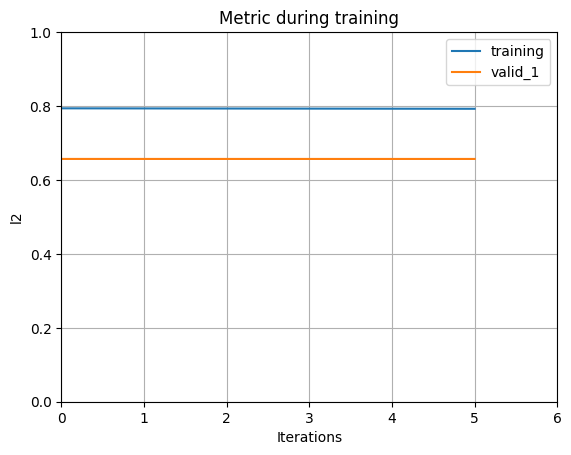

Best iteration: 205
0.6568466559025369
Val Weighted R2 score is: 0.010649453015794563
this is date_id_df
(37752, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1302,0,0,3.906331,-1.794024,1.620793,-1.400158,-1.69738,1.937306,1.760533,0.326642,2.124821,-0.475833,11,7,76,-0.407901,2.468801,0.271242,null,0.063476,null,-1.948161,-0.783262,0.412748,0.098309,1.049864,1.413159,0.376349,0.10799,1.302953,0.851631,0.043329,-0.3833,-0.560871,0.055453,null,null,-0.929577,-1.283467,0.456204,-0.137662,0.397857,null,0.944654,null,null,-0.977762,null,-1.092937,1.220715,-0.102575,1.617146,1.074374,null,2.496131,null,null,-1.187544,null,-0.777672,1.616441,null,3.471144,1.5513,1.344964,-0.29493,-0.163634,-0.346436,-2.285648,-1.322838,-0.705406,2.248816,0.269209,-0.932899,2.777192,0.265799,null,null,2.923078,2.226119,0.316346,0.598115,-0.1987,-0.301571,-0.062928,-0.250865,0.023525,-0.1359,0.07287,0.20301,-0.05056,0.440378
1302,0,1,5.05312,-1.10459,0.762159,-1.14742,-1.343009,2.30505,1.897101,0.319412,3.426389,-0.859158,11,7,76,-0.440694,9.550902,1.101264,null,-0.309991,null,-1.637701,-1.441753,-0.898358,0.278866,1.400944,0.988504,-0.944699,-1.021618,0.4074,2.092035,0.678855,-0.781349,-0.426404,0.371238,null,null,-0.985925,-1.526342,-1.787444,-0.072728,3.386007,null,0.290168,null,null,-0.634615,null,-2.061056,0.629062,-4.183554,-0.724215,-0.767806,null,1.422024,null,null,-1.41068,null,-2.450871,0.735713,null,0.498104,0.481491,1.344964,-0.458682,-0.408728,-0.328404,-1.758115,-1.69633,-0.46296,4.008308,0.476346,-0.297632,6.974867,1.895344,null,null,-0.144038,-0.305661,-0.305823,-0.442855,1.043291,-0.091463,-0.012453,-0.391784,1.248448,0.501747,1.153719,1.473158,0.47282,1.175669
1302,0,2,1.839592,-1.557027,1.372378,-1.5262,-1.592326,1.801422,1.824752,0.562601,3.81376,-0.761065,81,2,59,-1.192446,0.440127,-0.551748,null,2.030352,null,-2.443922,-1.889671,0.144041,-0.248928,-0.648701,-0.620545,-0.545699,-0.625252,0.883632,0.516426,0.09042,-0.575459,-0.491985,-0.207413,null,null,-1.937081,-1.686028,1.995375,-0.289757,-0.587831,null,1.216915,null,null,-1.838225,null,-0.745194,0.703424,2.169499,-0.612918,1.903752,null,2.468092,null,null,-3.199993,null,-1.164341,0.271832,null,1.034839,1.524374,1.344964,0.461926,-0.230309,-0.126904,-1.906419,-2.124494,-1.112929,0.1706,-0.491505,-1.463558,0.358084,-0.488234,null,null,7.510787,8.168211,1.858599,1.769807,-1.422248,-0.559386,-0.43486,-0.54861,0.811398,-0.110127,1.060903,1.101417,0.122875,2.584967
1302,0,3,1.304885,-1.401025,1.072523,-1.23421,-1.255453,2.370477,0.985541,0.276002,2.372737,-0.434517,4,3,11,-0.943725,1.306945,-0.211239,null,0.749365,null,-1.834839,-1.415685,0.079902,0.095822,-0.845697,-0.741291,1.811574,1.45618,-0.455749,-1.023914,-1.131063

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1302,967,34,2.471162,-0.174337,-0.435853,-0.722493,-0.521033,0.811036,0.086339,0.898596,0.337832,0.764571,42,5,150,-0.584679,0.012463,-0.354562,-0.618974,-0.377323,-0.87342,2.096314,-0.416946,-0.167914,-0.170609,-0.06613,-0.619073,0.208919,-0.217249,-0.784142,0.507675,1.899022,-0.818527,-0.631799,-0.167062,-0.14649,-0.190484,-0.786145,-0.207613,-0.423113,1.519448,0.965303,0.12536,-0.160291,0.943239,1.022228,0.204601,0.744056,0.09177,-2.505775,0.220018,0.969778,0.555503,0.736884,-0.876593,-0.0089,2.27529,0.747532,2.291456,-0.246191,-2.041395,0.228435,1.009224,0.53625,1.344964,-0.458037,-0.304228,-0.327452,1.461764,-1.768281,-0.669584,-0.286379,-0.377507,-0.487057,0.318578,-0.25916,0.165889,0.052386,-0.211598,-0.31239,-0.121708,-0.181726,-0.327939,-2.590283,-1.225316,-0.530161,-0.575494,-0.377543,-0.211959,-0.148636,-0.044721,-0.368315
1302,967,35,2.014901,-0.404105,0.428198,-0.659394,-0.210774,0.63884,0.079282,0.687922,0.424239,0.751627,11,7,76,-0.20145,0.682333,-0.174952,1.294255,1.359651,1.217869,-0.24717,-1.313069,0.022536,0.650601,-0.409911,0.965735,1.269001,1.403313,0.133989,-1.967431,-1.911474,2.201284,0.886433,1.150661,0.204607,0.343069,-0.089458,-0.54977,-1.223779,0.568277,0.849353,0.451122,1.434045,1.615966,1.424661,0.420739,0.835098,0.818919,-0.016549,0.484969,0.424275,0.376094,0.870329,1.662858,0.923516,1.639452,-0.416763,0.57588,0.838691,-0.986592,0.724593,0.243208,0.648189,1.344964,-0.045548,0.036069,0.189901,-0.970775,-0.27334,-0.484502,-0.268319,-0.390464,0.100698,1.409145,0.423722,-0.328733,-0.401509,-0.270705,-0.412658,-0.237602,-0.265246,0.191,1.294224,-1.669716,-1.027379,0.728099,0.394877,-0.648106,-1.455333,-0.527295,-3.570545
1302,967,36,2.1246,-0.747346,0.127731,-0.475866,0.078073,0.630667,0.027969,0.825785,0.226519,0.632894,68,6,388,-0.452025,-0.220087,-0.317177,-0.071903,-0.262119,-0.161005,1.667428,-0.54069,-0.4037,0.86635,-0.263993,1.475076,2.246392,1.303715,-0.315975,-1.647233,-1.676553,0.526634,-0.08274,0.896054,-0.440451,1.726927,-1.571821,-0.951337,0.999841,-0.265183,-0.768101,0.185898,-0.209967,0.67231,1.418238,-0.112478,1.13695,0.173709,-0.774504,0.47928,-0.028256,0.174967,-0.042762,-0.18507,-0.775551,0.958386,-0.797041,-0.324452,-0.026889,-0.176444,0.265596,0.056484,0.075958,1.344964,-0.206474,-0.404345,-0.21938,1.855647,-1.097426,-0.501253,-0.058043,-0.369919,-0.368052,-0.357103,-0.411369,-0.518962,-0.268421,-0.168865,-0.177979,-0.323799,-0.235542,-0.128247,-0.241956,-0.18725,5.0,0.871648,0.493634,5.0,-0.030973,0.008292,-0.090152
1302,967,37,0.96179,-0.560718,0.310633,-0.351245

this is updated validation data
(14555816, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1303,0,0,4.141834,-0.296774,-0.974657,-0.250234,-0.123713,2.723572,-0.541356,0.162744,-0.352625,0.376274,11,7,76,-0.773073,1.879289,-0.198771,null,-0.561626,null,-1.51693,-1.776704,0.082687,0.038909,1.178291,1.345135,0.296648,0.210735,0.804797,0.860809,0.000482,-0.453569,-0.166233,0.044491,null,null,0.519864,-0.228099,1.140766,0.027388,0.102964,null,0.889921,null,null,0.081831,null,-1.345037,0.856869,-0.351348,0.508673,0.238235,null,0.594031,null,null,0.162153,null,-2.090822,2.930479,null,-0.522206,-0.364939,1.680321,-0.385749,-0.188519,-0.301722,-1.635448,-1.424623,-0.705842,1.533436,0.054684,-0.938697,0.466329,-0.3894,null,null,-0.135613,-0.109604,-0.335999,-0.309361,-1.323576,0.944464,0.621108,-0.819163,0.237734,-0.059301,0.593719,-0.1987,-0.59592,1.469215
1303,0,1,5.878377,-0.802796,-1.083308,-0.503801,0.187275,2.513281,-1.137699,0.232406,-0.475378,0.7162,11,7,76,-0.844172,1.568931,-0.179511,null,-0.448849,null,-0.898662,-1.893957,-1.427711,0.34037,1.985158,1.949625,-0.647671,-1.174175,0.609225,1.235133,1.195982,-0.876509,-0.405767,0.248277,null,null,-1.470816,-1.119021,-0.215291,0.044497,-0.022553,null,-0.230807,null,null,-0.495339,null,-1.742101,1.114477,-0.076398,-0.12377,-0.103467,null,-0.317373,null,null,0.32908,null,-2.482366,1.929975,null,-0.210186,-0.125155,1.680321,-0.310563,-0.331202,-0.380272,-0.957978,-2.109146,-0.843074,-0.026628,-0.544065,-0.582854,3.298173,0.173844,null,null,-0.240148,-0.307793,-0.322808,-0.265274,0.173905,-0.144838,-0.384399,0.048492,0.455743,-1.346183,0.019264,1.043291,-0.853071,-0.040665
1303,0,2,1.326961,0.327979,-1.205458,-0.741482,0.022975,2.494362,-1.501809,0.205008,-0.287508,0.467417,81,2,59,-0.812447,-0.098786,-0.603074,null,-0.135777,null,-1.279574,-2.423005,0.220863,-0.260698,-0.817411,-0.709335,-0.554875,-0.956063,0.705164,0.373443,0.026917,-0.780174,-0.47737,-0.256638,null,null,-0.614689,-0.487139,-1.601829,0.158784,0.331525,null,0.46228,null,null,-1.525764,null,-1.510757,1.362195,-3.172511,-0.599586,-0.93194,null,0.582797,null,null,-1.380544,null,-1.740958,1.591173,null,-1.034031,-0.406986,1.680321,-0.089933,-0.295683,-0.015238,-1.687193,-1.525732,-0.909254,0.022341,-0.73015,-0.69076,-0.157476,-0.603292,null,null,-0.087384,-0.127881,-0.309729,-0.342465,1.178857,3.276968,2.656405,3.213092,0.230805,0.775467,-1.834522,-1.422248,-0.525639,-5.0
1303,0,3,1.654709,0.026344,-0.93745,-0.247597,-0.083426,2.373813,-0.654411,0.093008,-0.189745,0.169307,4,3,11,-1.424317,1.158616,-0.253896,null,-0.150223,null,-1.155847,-1.309276,0.103152,0.219267,-0.704495,-0.880776,1.346944

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1698,967,34,3.242493,2.52516,-0.721981,2.544025,2.477615,0.417557,0.785812,1.117796,2.199436,0.415427,42,5,150,0.804403,1.157257,1.031543,-0.671189,-0.3286,-0.486132,1.730176,-0.006173,-0.001144,-0.213062,0.932618,1.367338,-0.238197,-0.692615,-0.121163,1.090798,1.444294,-0.675626,-1.013264,-0.242888,3.427639,-0.958278,3.139836,3.416278,-1.655316,-0.59944,-0.932876,2.493458,0.969462,1.102016,0.158982,-0.496177,0.036177,1.309866,0.828025,1.577955,1.040802,1.255398,2.577441,0.057455,0.953005,1.377051,-0.396358,0.520262,1.179617,1.127657,2.231928,0.614652,2.412886,-1.101531,-0.384833,-0.275818,-0.40804,2.427115,-0.108427,0.739734,0.830205,0.366287,1.33325,1.075499,1.798264,-0.183443,-0.190222,0.234211,0.347142,-0.044463,0.016936,-0.132337,0.501321,0.905332,-0.819582,-0.564046,-0.223018,-0.283954,-0.045938,0.009797,-0.102538
1698,967,35,1.079139,1.857906,-0.790646,2.745439,2.339877,0.845065,0.65137,1.180301,1.966379,0.321543,25,7,195,-0.075294,-0.152726,-0.20417,-0.421137,0.21708,-0.258775,1.874978,0.19988,-0.199219,-0.125619,-1.004547,-0.051933,0.450905,0.009246,0.164127,-0.939974,-1.143421,-0.320071,-0.379835,-0.142429,3.862469,-1.451786,3.477489,2.861663,0.763459,0.075972,-0.119677,0.626035,0.148815,0.653281,0.059313,-0.845099,0.098528,0.409564,-0.675728,-0.011334,0.930534,0.83198,0.808955,0.219276,-0.315776,0.687755,-1.189577,0.180146,-0.175486,-1.60435,-0.209283,0.249847,0.288816,-1.101531,-0.343868,-0.253991,-0.278832,2.050639,-0.059506,-0.029396,-0.101381,-0.187759,-0.180839,-0.0861,-0.153405,-0.196077,-0.175292,1.04578,0.739733,0.03372,0.05086,-0.249584,-1.113053,0.69719,-1.619031,-1.222743,-0.706082,-0.291133,0.167733,0.099704,0.32461
1698,967,36,1.033172,2.515527,-0.672298,2.28925,2.521592,0.255077,0.919892,1.172018,2.180496,0.24846,49,7,297,1.026715,-0.096892,0.224309,-0.528109,-0.704952,-0.704818,2.312482,0.32804,-0.108193,null,-0.945684,-0.244173,0.205989,-0.357343,null,null,-1.11075,-0.580242,-0.400568,null,2.397877,-0.637258,3.260638,3.046786,0.440965,0.234842,-0.17558,1.022406,-0.500069,2.071033,0.413488,-0.450016,-0.156616,-0.253755,-0.769588,0.066086,0.047826,1.713707,0.772772,-0.549192,1.338474,0.933568,0.032978,-0.519118,-0.290343,-0.806786,0.106295,0.183461,1.830421,-1.101531,-0.341991,-0.249132,-0.34365,2.251358,0.601888,1.035051,-0.283241,0.107244,0.86016,0.024223,0.374852,-0.220933,-0.161584,0.032771,0.036888,0.168908,0.152333,-0.065355,-1.019353,-0.460962,-2.026678,-0.848606,-0.305448,-1.256913,-0.109359,-0.027474,-0.253956
1698,967,37,1.243116,2.663298,-0.889112,2.313155,3.101428,0.324454,

<Figure size 640x480 with 0 Axes>

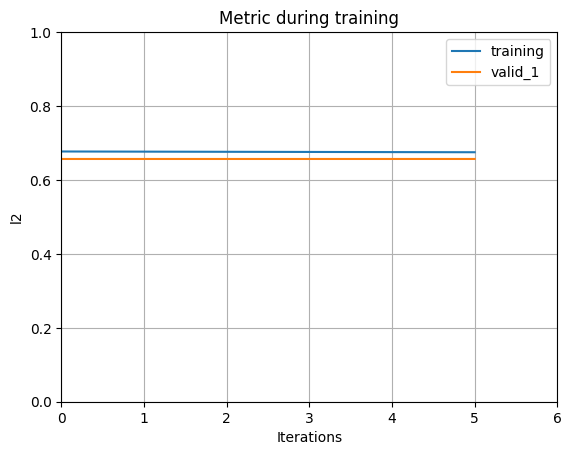

Best iteration: 208
0.6567717902250693
Val Weighted R2 score is: 0.010683597518455934
this is date_id_df
(37752, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1303,0,0,4.141834,-0.296774,-0.974657,-0.250234,-0.123713,2.723572,-0.541356,0.162744,-0.352625,0.376274,11,7,76,-0.773073,1.879289,-0.198771,null,-0.561626,null,-1.51693,-1.776704,0.082687,0.038909,1.178291,1.345135,0.296648,0.210735,0.804797,0.860809,0.000482,-0.453569,-0.166233,0.044491,null,null,0.519864,-0.228099,1.140766,0.027388,0.102964,null,0.889921,null,null,0.081831,null,-1.345037,0.856869,-0.351348,0.508673,0.238235,null,0.594031,null,null,0.162153,null,-2.090822,2.930479,null,-0.522206,-0.364939,1.680321,-0.385749,-0.188519,-0.301722,-1.635448,-1.424623,-0.705842,1.533436,0.054684,-0.938697,0.466329,-0.3894,null,null,-0.135613,-0.109604,-0.335999,-0.309361,-1.323576,0.944464,0.621108,-0.819163,0.237734,-0.059301,0.593719,-0.1987,-0.59592,1.469215
1303,0,1,5.878377,-0.802796,-1.083308,-0.503801,0.187275,2.513281,-1.137699,0.232406,-0.475378,0.7162,11,7,76,-0.844172,1.568931,-0.179511,null,-0.448849,null,-0.898662,-1.893957,-1.427711,0.34037,1.985158,1.949625,-0.647671,-1.174175,0.609225,1.235133,1.195982,-0.876509,-0.405767,0.248277,null,null,-1.470816,-1.119021,-0.215291,0.044497,-0.022553,null,-0.230807,null,null,-0.495339,null,-1.742101,1.114477,-0.076398,-0.12377,-0.103467,null,-0.317373,null,null,0.32908,null,-2.482366,1.929975,null,-0.210186,-0.125155,1.680321,-0.310563,-0.331202,-0.380272,-0.957978,-2.109146,-0.843074,-0.026628,-0.544065,-0.582854,3.298173,0.173844,null,null,-0.240148,-0.307793,-0.322808,-0.265274,0.173905,-0.144838,-0.384399,0.048492,0.455743,-1.346183,0.019264,1.043291,-0.853071,-0.040665
1303,0,2,1.326961,0.327979,-1.205458,-0.741482,0.022975,2.494362,-1.501809,0.205008,-0.287508,0.467417,81,2,59,-0.812447,-0.098786,-0.603074,null,-0.135777,null,-1.279574,-2.423005,0.220863,-0.260698,-0.817411,-0.709335,-0.554875,-0.956063,0.705164,0.373443,0.026917,-0.780174,-0.47737,-0.256638,null,null,-0.614689,-0.487139,-1.601829,0.158784,0.331525,null,0.46228,null,null,-1.525764,null,-1.510757,1.362195,-3.172511,-0.599586,-0.93194,null,0.582797,null,null,-1.380544,null,-1.740958,1.591173,null,-1.034031,-0.406986,1.680321,-0.089933,-0.295683,-0.015238,-1.687193,-1.525732,-0.909254,0.022341,-0.73015,-0.69076,-0.157476,-0.603292,null,null,-0.087384,-0.127881,-0.309729,-0.342465,1.178857,3.276968,2.656405,3.213092,0.230805,0.775467,-1.834522,-1.422248,-0.525639,-5.0
1303,0,3,1.654709,0.026344,-0.93745,-0.247597,-0.083426,2.373813,-0.654411,0.093008,-0.189745,0.169307,4,3,11,-1.424317,1.158616,-0.253896,null,-0.150223,null,-1.155847,-1.309276,0.103152,0.219267,-0.704495,-0.880776,1.346944

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1303,967,34,1.940656,-0.410357,0.526546,-1.234913,-0.81606,1.869989,1.980287,0.894419,1.116369,-3.213637,42,5,150,0.166649,0.231967,0.01871,-0.678259,-0.260384,-0.826494,-1.169254,2.397299,-0.203841,-0.229003,-0.106885,-0.434314,0.252777,-0.017621,-1.011777,0.396542,1.451273,-0.670578,-0.836422,-0.154971,-0.799478,1.009798,-0.159843,-0.032862,-0.223154,-0.750255,-1.306761,1.066358,-0.635207,0.542325,-1.459556,-1.156264,-0.53636,1.94411,-0.036962,0.754595,-0.416534,-0.399532,1.36571,0.887696,1.095338,-1.07785,-0.060436,-0.312909,2.171187,-0.320928,1.210579,-0.006348,-0.155454,1.680321,-0.36682,-0.285585,-0.350698,-0.492804,2.836623,0.055006,0.300956,0.03163,0.325383,-0.1834,0.024479,0.574682,0.76672,1.096584,1.508096,0.575598,0.650582,0.164862,0.783147,0.389176,0.704515,0.39435,0.152881,0.082848,-0.327939,-0.101008,-0.644402
1303,967,35,2.667894,-1.584909,0.410102,-0.890097,-0.637113,2.077824,1.768265,2.10589,0.686117,-2.758366,11,7,76,-0.398784,-0.287492,-0.400836,1.190549,-0.330131,0.487956,-0.274146,3.033213,-0.109706,1.82285,-0.109926,0.934537,0.965142,1.698246,0.101074,-1.534653,-1.68925,1.90059,1.370247,1.442552,-1.107732,-0.910341,-1.10423,-0.619511,1.070801,-1.974829,-2.588297,0.215238,1.742224,1.070972,-2.041698,1.618984,0.575262,2.344904,-0.524555,0.523475,-0.001701,-0.565608,0.553176,0.98367,-0.356612,-1.588689,-1.50353,-1.432367,2.130368,-0.547705,0.848527,0.039562,-0.84882,1.680321,0.027878,-0.332029,0.179607,0.189541,2.408494,-0.40208,-0.194348,-0.138109,-0.288632,-0.406147,-0.430993,-0.319975,-0.120582,-0.19307,-0.054784,-0.289551,-0.117899,-0.088297,-0.331031,1.437967,-1.580831,-0.078651,-0.029397,0.640045,0.191,0.111314,0.542452
1303,967,36,2.48792,-0.482028,0.546329,-1.213749,-0.894748,1.485161,1.984753,1.321686,0.693308,-1.995444,68,6,388,0.498414,0.064341,0.344752,-0.153947,-0.10063,-0.286425,0.10717,2.921027,-0.411751,0.76887,-0.273058,1.446388,1.285718,1.994825,-0.339179,-1.82099,-1.02393,0.364242,-0.053678,0.662343,-0.934875,0.129301,-1.770056,-0.88163,1.188558,-1.975726,-2.138048,0.880022,0.841282,0.048441,-1.711593,-0.57485,-0.696398,2.552259,0.267227,1.276633,-0.374595,-0.358028,0.075814,0.481044,-0.986774,-1.837662,-0.972825,-1.625569,1.791279,-0.398786,1.92635,-1.765012,-1.124101,1.680321,-0.349528,-0.126351,-0.277495,-0.531702,2.976842,0.408674,0.246207,0.462381,0.59614,-0.285259,0.45415,-0.294719,-0.037969,-0.31997,-0.021263,-0.130001,-0.006157,-0.053643,0.339187,-0.176677,-0.469959,0.096252,0.075242,-0.059231,-0.128247,-0.015335,-0.254357
1303,967,37,1.112702,-0.708801,0.692443,-0

this is updated validation data
(14518064, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1304,0,0,3.914653,-0.579671,-2.374725,-0.813218,-0.284998,2.212595,-1.681462,1.5439,-0.188845,0.365302,11,7,76,-0.959358,0.012182,-0.658919,null,-0.299499,null,-1.224791,-1.397469,-0.008918,0.047536,1.413716,0.902764,0.470457,0.4002,1.291334,1.487138,-0.100024,-0.425572,-0.604256,0.052331,null,null,-0.599507,-0.764347,-0.659913,0.067116,0.162043,null,1.413535,null,null,0.087123,null,-1.431615,1.034637,-0.713041,0.286528,-0.18399,null,0.600581,null,null,-0.634045,null,-1.739636,2.010373,null,-0.362385,-0.413237,2.163822,-0.195409,-0.17203,-0.355788,-2.782484,-1.665088,-0.99007,-0.027759,-0.511913,-1.158312,0.055986,-0.492045,null,null,0.638718,0.491161,-0.068838,-0.09087,0.17075,-0.416049,-0.173584,-0.041634,-1.076373,-1.12515,-0.386269,-1.323576,-1.549583,-0.666998
1304,0,1,4.61504,-1.21195,-2.597049,-0.626007,-0.524396,2.389375,-2.0693,2.067591,-0.274144,0.4686,11,7,76,-0.877277,0.41089,-0.360317,null,-0.766795,null,-0.826187,-1.704459,-1.586134,0.329197,2.883485,1.365709,-0.457091,-0.804726,0.720304,1.694564,1.515144,-0.678663,-0.69763,0.223569,null,null,-1.460719,-1.342782,0.295077,0.025589,-0.088366,null,0.413045,null,null,-0.049094,null,-0.812944,1.416127,-0.021255,-0.005896,-0.008748,null,0.039487,null,null,0.736547,null,-1.930285,2.8935,null,-0.086489,-0.067994,2.163822,-0.319074,-0.203793,-0.607049,-1.03957,-2.094145,-0.853563,-0.394652,-0.777538,-0.841793,1.446525,-0.08414,null,null,-0.232404,-0.271961,-0.172908,-0.319686,0.194236,0.194703,-0.062116,0.183057,0.254886,-0.295495,-0.597959,0.173905,-0.348672,-0.547854
1304,0,2,1.789582,-0.93046,-2.774969,-0.241582,-0.382487,1.94759,-1.971342,2.922793,-0.275363,0.500941,81,2,59,-0.902594,0.415697,-0.53775,null,0.287663,null,-2.643903,-1.633943,-0.188966,-0.271201,-0.715993,-0.665722,-0.41914,-1.03932,0.585886,0.899902,0.054979,-0.748997,-0.586461,-0.330902,null,null,0.214663,0.325394,-2.821012,0.11372,-0.011073,null,2.218259,null,null,1.064945,null,-0.107619,1.456465,-1.272301,8.334475,2.428833,null,3.299493,null,null,-1.326131,null,-0.349915,1.78082,null,3.436747,0.716224,2.163822,-0.148979,0.037536,0.002705,-1.848292,-1.610477,-0.717209,0.461632,-0.483925,-1.159663,0.580186,-0.489519,null,null,5.124052,4.777213,6.138562,10.409495,0.711587,-0.47645,-0.282917,-0.074881,0.366715,2.935093,1.672683,1.178857,3.420776,4.59191
1304,0,3,2.055281,-1.293807,-2.113443,-0.610515,-0.205316,1.702428,-0.882265,1.365112,-0.178456,0.293704,4,3,11,-0.928385,2.127794,-0.128248,null,-0.161365,null,-1.268023,-1.091812,0.088468,0.259877,-0.458061,-0.78472,1.035165,2.193889,-0

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1698,967,34,3.242493,2.52516,-0.721981,2.544025,2.477615,0.417557,0.785812,1.117796,2.199436,0.415427,42,5,150,0.804403,1.157257,1.031543,-0.671189,-0.3286,-0.486132,1.730176,-0.006173,-0.001144,-0.213062,0.932618,1.367338,-0.238197,-0.692615,-0.121163,1.090798,1.444294,-0.675626,-1.013264,-0.242888,3.427639,-0.958278,3.139836,3.416278,-1.655316,-0.59944,-0.932876,2.493458,0.969462,1.102016,0.158982,-0.496177,0.036177,1.309866,0.828025,1.577955,1.040802,1.255398,2.577441,0.057455,0.953005,1.377051,-0.396358,0.520262,1.179617,1.127657,2.231928,0.614652,2.412886,-1.101531,-0.384833,-0.275818,-0.40804,2.427115,-0.108427,0.739734,0.830205,0.366287,1.33325,1.075499,1.798264,-0.183443,-0.190222,0.234211,0.347142,-0.044463,0.016936,-0.132337,0.501321,0.905332,-0.819582,-0.564046,-0.223018,-0.283954,-0.045938,0.009797,-0.102538
1698,967,35,1.079139,1.857906,-0.790646,2.745439,2.339877,0.845065,0.65137,1.180301,1.966379,0.321543,25,7,195,-0.075294,-0.152726,-0.20417,-0.421137,0.21708,-0.258775,1.874978,0.19988,-0.199219,-0.125619,-1.004547,-0.051933,0.450905,0.009246,0.164127,-0.939974,-1.143421,-0.320071,-0.379835,-0.142429,3.862469,-1.451786,3.477489,2.861663,0.763459,0.075972,-0.119677,0.626035,0.148815,0.653281,0.059313,-0.845099,0.098528,0.409564,-0.675728,-0.011334,0.930534,0.83198,0.808955,0.219276,-0.315776,0.687755,-1.189577,0.180146,-0.175486,-1.60435,-0.209283,0.249847,0.288816,-1.101531,-0.343868,-0.253991,-0.278832,2.050639,-0.059506,-0.029396,-0.101381,-0.187759,-0.180839,-0.0861,-0.153405,-0.196077,-0.175292,1.04578,0.739733,0.03372,0.05086,-0.249584,-1.113053,0.69719,-1.619031,-1.222743,-0.706082,-0.291133,0.167733,0.099704,0.32461
1698,967,36,1.033172,2.515527,-0.672298,2.28925,2.521592,0.255077,0.919892,1.172018,2.180496,0.24846,49,7,297,1.026715,-0.096892,0.224309,-0.528109,-0.704952,-0.704818,2.312482,0.32804,-0.108193,null,-0.945684,-0.244173,0.205989,-0.357343,null,null,-1.11075,-0.580242,-0.400568,null,2.397877,-0.637258,3.260638,3.046786,0.440965,0.234842,-0.17558,1.022406,-0.500069,2.071033,0.413488,-0.450016,-0.156616,-0.253755,-0.769588,0.066086,0.047826,1.713707,0.772772,-0.549192,1.338474,0.933568,0.032978,-0.519118,-0.290343,-0.806786,0.106295,0.183461,1.830421,-1.101531,-0.341991,-0.249132,-0.34365,2.251358,0.601888,1.035051,-0.283241,0.107244,0.86016,0.024223,0.374852,-0.220933,-0.161584,0.032771,0.036888,0.168908,0.152333,-0.065355,-1.019353,-0.460962,-2.026678,-0.848606,-0.305448,-1.256913,-0.109359,-0.027474,-0.253956
1698,967,37,1.243116,2.663298,-0.889112,2.313155,3.101428,0.324454,

<Figure size 640x480 with 0 Axes>

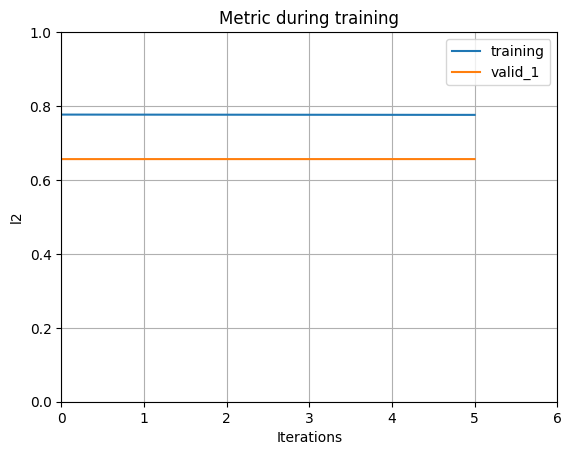

Best iteration: 209
0.6564449323199698
Val Weighted R2 score is: 0.0106513662728136
this is date_id_df
(37752, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1304,0,0,3.914653,-0.579671,-2.374725,-0.813218,-0.284998,2.212595,-1.681462,1.5439,-0.188845,0.365302,11,7,76,-0.959358,0.012182,-0.658919,null,-0.299499,null,-1.224791,-1.397469,-0.008918,0.047536,1.413716,0.902764,0.470457,0.4002,1.291334,1.487138,-0.100024,-0.425572,-0.604256,0.052331,null,null,-0.599507,-0.764347,-0.659913,0.067116,0.162043,null,1.413535,null,null,0.087123,null,-1.431615,1.034637,-0.713041,0.286528,-0.18399,null,0.600581,null,null,-0.634045,null,-1.739636,2.010373,null,-0.362385,-0.413237,2.163822,-0.195409,-0.17203,-0.355788,-2.782484,-1.665088,-0.99007,-0.027759,-0.511913,-1.158312,0.055986,-0.492045,null,null,0.638718,0.491161,-0.068838,-0.09087,0.17075,-0.416049,-0.173584,-0.041634,-1.076373,-1.12515,-0.386269,-1.323576,-1.549583,-0.666998
1304,0,1,4.61504,-1.21195,-2.597049,-0.626007,-0.524396,2.389375,-2.0693,2.067591,-0.274144,0.4686,11,7,76,-0.877277,0.41089,-0.360317,null,-0.766795,null,-0.826187,-1.704459,-1.586134,0.329197,2.883485,1.365709,-0.457091,-0.804726,0.720304,1.694564,1.515144,-0.678663,-0.69763,0.223569,null,null,-1.460719,-1.342782,0.295077,0.025589,-0.088366,null,0.413045,null,null,-0.049094,null,-0.812944,1.416127,-0.021255,-0.005896,-0.008748,null,0.039487,null,null,0.736547,null,-1.930285,2.8935,null,-0.086489,-0.067994,2.163822,-0.319074,-0.203793,-0.607049,-1.03957,-2.094145,-0.853563,-0.394652,-0.777538,-0.841793,1.446525,-0.08414,null,null,-0.232404,-0.271961,-0.172908,-0.319686,0.194236,0.194703,-0.062116,0.183057,0.254886,-0.295495,-0.597959,0.173905,-0.348672,-0.547854
1304,0,2,1.789582,-0.93046,-2.774969,-0.241582,-0.382487,1.94759,-1.971342,2.922793,-0.275363,0.500941,81,2,59,-0.902594,0.415697,-0.53775,null,0.287663,null,-2.643903,-1.633943,-0.188966,-0.271201,-0.715993,-0.665722,-0.41914,-1.03932,0.585886,0.899902,0.054979,-0.748997,-0.586461,-0.330902,null,null,0.214663,0.325394,-2.821012,0.11372,-0.011073,null,2.218259,null,null,1.064945,null,-0.107619,1.456465,-1.272301,8.334475,2.428833,null,3.299493,null,null,-1.326131,null,-0.349915,1.78082,null,3.436747,0.716224,2.163822,-0.148979,0.037536,0.002705,-1.848292,-1.610477,-0.717209,0.461632,-0.483925,-1.159663,0.580186,-0.489519,null,null,5.124052,4.777213,6.138562,10.409495,0.711587,-0.47645,-0.282917,-0.074881,0.366715,2.935093,1.672683,1.178857,3.420776,4.59191
1304,0,3,2.055281,-1.293807,-2.113443,-0.610515,-0.205316,1.702428,-0.882265,1.365112,-0.178456,0.293704,4,3,11,-0.928385,2.127794,-0.128248,null,-0.161365,null,-1.268023,-1.091812,0.088468,0.259877,-0.458061,-0.78472,1.035165,2.193889,-0

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1304,967,34,1.80745,-0.814511,0.66856,-0.271339,-1.047772,1.208728,-1.220116,-2.151777,-1.28534,1.039241,42,5,150,-0.154943,-0.197063,-0.367458,-0.909362,-0.573646,-0.749834,1.895957,0.478113,-0.137722,-0.154742,-0.044869,-0.629138,0.418434,-0.198596,-0.919914,0.240895,1.757157,-0.415663,-0.751456,-0.1936,-0.852056,-0.625039,-1.059372,-1.150324,0.277511,0.778001,0.397809,-0.448705,0.395593,-0.325374,-1.014646,-0.606933,-0.05975,-1.136925,-1.310551,-0.609851,-0.038546,-0.124881,-1.58875,-0.593345,-0.622968,-1.40483,0.297688,0.857628,-0.870473,-1.675881,-0.643531,-0.011376,-0.19739,2.163822,-0.346633,-0.418959,-0.271873,2.019614,0.654506,-0.126461,-0.205599,-0.346817,-0.163317,-0.196658,-0.266509,0.134634,0.03497,-0.312078,-0.299856,-0.205412,-0.141704,-0.197085,-0.076067,-0.506333,-2.447103,0.900057,0.802032,-0.64072,0.164862,0.129638,0.444108
1304,967,35,2.109503,-0.535005,0.522457,-0.902119,-0.331165,0.936547,-1.090091,-1.49857,-1.329512,1.572577,11,7,76,-0.657556,-0.32437,-0.42074,1.264588,1.500354,0.963148,-1.388912,1.307913,0.123517,1.154557,-0.23555,1.635999,0.92615,2.017168,0.142319,-1.868736,-1.681153,1.545752,1.145888,0.829204,-0.036929,-1.078249,0.008914,-0.759955,-1.439088,-1.761199,-1.596184,-0.547176,1.42791,0.484342,-2.199473,1.045371,-1.027532,1.772075,-0.61154,-0.413005,-0.105648,-0.223937,0.550348,0.565569,0.002026,-1.16261,-1.903178,-0.712612,1.30246,-0.858915,-0.297285,-0.085231,-0.166213,2.163822,-0.096523,0.331713,0.07561,-0.923835,0.887987,-0.400617,-0.421293,-0.418927,-0.749644,-0.303904,-0.697143,-0.245993,-0.136145,-0.222485,-0.141012,-0.249968,-0.085043,0.027937,1.135119,0.202729,0.945914,0.584056,0.367753,0.343291,-0.088297,-0.012947,-0.221573
1304,967,36,1.769366,-0.371205,0.646077,-0.806595,-0.534568,0.487653,-0.724209,-1.920233,-1.073767,0.973494,68,6,388,-0.242085,0.249631,-0.424577,-0.066378,0.003623,-0.027668,-0.251021,0.94838,0.034937,1.097699,-0.508021,1.062869,1.700755,2.423571,-0.287787,-1.007884,-2.092081,0.791727,-0.013593,0.934923,-0.42316,1.097082,-1.170485,-0.610803,2.164589,-0.275595,-0.144801,-0.19587,-0.032745,0.239152,-1.368865,-1.133835,0.378249,0.257948,-0.808747,0.139235,0.077906,0.188794,-1.866419,0.553362,0.52904,-1.082952,-0.363631,0.133649,0.279337,-0.6636,-0.018091,0.479632,-0.155037,2.163822,-0.281377,-0.187809,-0.205717,2.184461,1.231853,-0.231847,-0.156192,-0.489914,-0.135385,0.814028,-0.195024,-0.435037,-0.424208,-0.257716,-0.186917,-0.329871,-0.320318,-0.24488,1.304366,1.20192,-1.160322,-0.399664,-0.1943,-0.520049,-0.053643,0.004439,-0.122627
1304,967,3

this is updated validation data
(14480312, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1305,0,0,3.166444,-0.071764,1.1344,-0.933239,-0.52049,2.356614,-0.222291,-0.389642,-0.184016,0.218901,11,7,76,-1.023434,0.853918,-0.428255,null,-0.092563,null,-1.375775,-1.595768,0.014939,0.006429,1.126304,1.085117,0.544333,0.276318,0.925062,0.522847,-0.09236,-0.524577,-0.473596,0.012015,null,null,3.063149,3.06115,1.365833,-0.012482,0.319531,null,-0.654828,null,null,-1.291396,null,-1.958148,1.245369,-0.272083,0.046397,0.255246,null,0.61953,null,null,-0.89387,null,-1.550084,1.478266,null,0.14634,0.055712,-1.261689,-0.333721,-0.313637,-0.364428,-1.525985,-1.579697,-0.833622,1.304363,-0.128903,-0.825039,0.228277,-0.600322,null,null,0.657524,0.428116,-0.091746,-0.130084,-0.350762,0.396233,0.001525,0.846803,0.332435,0.329863,0.076458,0.17075,0.459133,-0.348662
1305,0,1,5.162778,-0.267399,0.821405,-1.26949,-0.348502,2.715996,-0.651851,-0.373887,-0.233995,0.546209,11,7,76,-0.607429,2.2352,0.02567,null,-0.694785,null,-0.708007,-1.291517,-2.014383,0.350222,1.563943,1.924942,-0.715832,-0.811932,0.324233,1.07439,1.286823,-0.728389,-0.388504,0.369903,null,null,-1.182873,-1.172975,-1.060672,0.089588,0.046209,null,-0.322693,null,null,0.316266,null,-1.844078,1.852809,-0.169567,-0.295984,-0.339809,null,0.05253,null,null,-0.174143,null,-2.477896,1.846889,null,-0.363609,-0.225997,-1.261689,-0.51359,-0.322775,-0.310682,-1.764038,-1.712747,-0.591011,1.148063,0.058577,-0.600825,2.340341,0.007521,null,null,-0.160629,-0.182325,-0.436682,-0.297191,-0.003339,-0.109933,-0.084607,-0.062709,0.035507,-0.490865,0.254768,0.194236,-0.807762,0.571183
1305,0,2,1.436669,-0.309528,1.299342,-0.493765,-0.269393,2.246774,-0.539725,-0.448022,-0.380807,0.413638,81,2,59,-1.060661,1.135098,-0.286363,null,0.064573,null,-1.751712,-2.09326,-0.248113,-0.238929,-0.934996,-0.541534,-0.350893,-0.806901,0.907907,0.488809,-0.015948,-0.628505,-0.496765,-0.219231,null,null,-1.871592,-2.060249,1.720448,0.368068,0.396579,null,-0.75943,null,null,-2.018439,null,-2.291903,0.541139,-1.825226,-2.835867,-1.259477,null,1.463838,null,null,-2.581113,null,-0.979095,1.297047,null,-7.288229,-3.133935,-1.261689,-0.421273,0.338845,-0.191117,-1.859838,-1.337219,-0.569866,0.961263,-0.207674,-0.982345,0.729782,-0.501919,null,null,0.233546,0.230787,-0.139344,-0.160996,0.192322,-0.119981,0.082893,0.850783,0.339909,1.687594,-1.337649,0.711587,1.642472,-3.525435
1305,0,3,1.639768,-0.104124,1.47155,-0.660029,-0.353963,2.407128,-0.16852,-0.35089,-0.170108,0.272724,4,3,11,-0.6121,1.966884,-0.130319,null,-0.295105,null,-0.960361,-2.11412,0.205892,0.114227,-0.746164,-0.648943,1.412602,1.665

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1698,967,34,3.242493,2.52516,-0.721981,2.544025,2.477615,0.417557,0.785812,1.117796,2.199436,0.415427,42,5,150,0.804403,1.157257,1.031543,-0.671189,-0.3286,-0.486132,1.730176,-0.006173,-0.001144,-0.213062,0.932618,1.367338,-0.238197,-0.692615,-0.121163,1.090798,1.444294,-0.675626,-1.013264,-0.242888,3.427639,-0.958278,3.139836,3.416278,-1.655316,-0.59944,-0.932876,2.493458,0.969462,1.102016,0.158982,-0.496177,0.036177,1.309866,0.828025,1.577955,1.040802,1.255398,2.577441,0.057455,0.953005,1.377051,-0.396358,0.520262,1.179617,1.127657,2.231928,0.614652,2.412886,-1.101531,-0.384833,-0.275818,-0.40804,2.427115,-0.108427,0.739734,0.830205,0.366287,1.33325,1.075499,1.798264,-0.183443,-0.190222,0.234211,0.347142,-0.044463,0.016936,-0.132337,0.501321,0.905332,-0.819582,-0.564046,-0.223018,-0.283954,-0.045938,0.009797,-0.102538
1698,967,35,1.079139,1.857906,-0.790646,2.745439,2.339877,0.845065,0.65137,1.180301,1.966379,0.321543,25,7,195,-0.075294,-0.152726,-0.20417,-0.421137,0.21708,-0.258775,1.874978,0.19988,-0.199219,-0.125619,-1.004547,-0.051933,0.450905,0.009246,0.164127,-0.939974,-1.143421,-0.320071,-0.379835,-0.142429,3.862469,-1.451786,3.477489,2.861663,0.763459,0.075972,-0.119677,0.626035,0.148815,0.653281,0.059313,-0.845099,0.098528,0.409564,-0.675728,-0.011334,0.930534,0.83198,0.808955,0.219276,-0.315776,0.687755,-1.189577,0.180146,-0.175486,-1.60435,-0.209283,0.249847,0.288816,-1.101531,-0.343868,-0.253991,-0.278832,2.050639,-0.059506,-0.029396,-0.101381,-0.187759,-0.180839,-0.0861,-0.153405,-0.196077,-0.175292,1.04578,0.739733,0.03372,0.05086,-0.249584,-1.113053,0.69719,-1.619031,-1.222743,-0.706082,-0.291133,0.167733,0.099704,0.32461
1698,967,36,1.033172,2.515527,-0.672298,2.28925,2.521592,0.255077,0.919892,1.172018,2.180496,0.24846,49,7,297,1.026715,-0.096892,0.224309,-0.528109,-0.704952,-0.704818,2.312482,0.32804,-0.108193,null,-0.945684,-0.244173,0.205989,-0.357343,null,null,-1.11075,-0.580242,-0.400568,null,2.397877,-0.637258,3.260638,3.046786,0.440965,0.234842,-0.17558,1.022406,-0.500069,2.071033,0.413488,-0.450016,-0.156616,-0.253755,-0.769588,0.066086,0.047826,1.713707,0.772772,-0.549192,1.338474,0.933568,0.032978,-0.519118,-0.290343,-0.806786,0.106295,0.183461,1.830421,-1.101531,-0.341991,-0.249132,-0.34365,2.251358,0.601888,1.035051,-0.283241,0.107244,0.86016,0.024223,0.374852,-0.220933,-0.161584,0.032771,0.036888,0.168908,0.152333,-0.065355,-1.019353,-0.460962,-2.026678,-0.848606,-0.305448,-1.256913,-0.109359,-0.027474,-0.253956
1698,967,37,1.243116,2.663298,-0.889112,2.313155,3.101428,0.324454,

<Figure size 640x480 with 0 Axes>

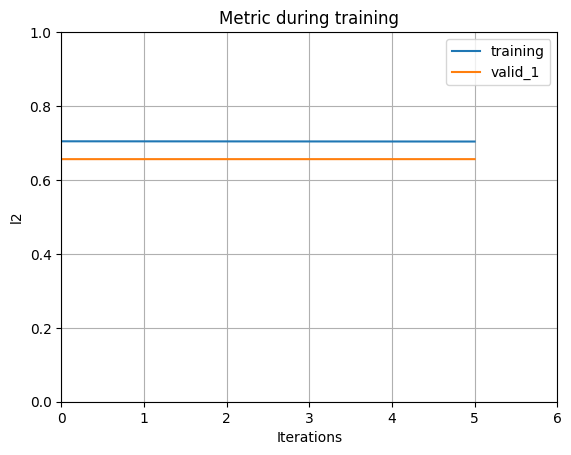

Best iteration: 210
0.6563205830832565
Val Weighted R2 score is: 0.010649254745534131
this is date_id_df
(37752, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1305,0,0,3.166444,-0.071764,1.1344,-0.933239,-0.52049,2.356614,-0.222291,-0.389642,-0.184016,0.218901,11,7,76,-1.023434,0.853918,-0.428255,null,-0.092563,null,-1.375775,-1.595768,0.014939,0.006429,1.126304,1.085117,0.544333,0.276318,0.925062,0.522847,-0.09236,-0.524577,-0.473596,0.012015,null,null,3.063149,3.06115,1.365833,-0.012482,0.319531,null,-0.654828,null,null,-1.291396,null,-1.958148,1.245369,-0.272083,0.046397,0.255246,null,0.61953,null,null,-0.89387,null,-1.550084,1.478266,null,0.14634,0.055712,-1.261689,-0.333721,-0.313637,-0.364428,-1.525985,-1.579697,-0.833622,1.304363,-0.128903,-0.825039,0.228277,-0.600322,null,null,0.657524,0.428116,-0.091746,-0.130084,-0.350762,0.396233,0.001525,0.846803,0.332435,0.329863,0.076458,0.17075,0.459133,-0.348662
1305,0,1,5.162778,-0.267399,0.821405,-1.26949,-0.348502,2.715996,-0.651851,-0.373887,-0.233995,0.546209,11,7,76,-0.607429,2.2352,0.02567,null,-0.694785,null,-0.708007,-1.291517,-2.014383,0.350222,1.563943,1.924942,-0.715832,-0.811932,0.324233,1.07439,1.286823,-0.728389,-0.388504,0.369903,null,null,-1.182873,-1.172975,-1.060672,0.089588,0.046209,null,-0.322693,null,null,0.316266,null,-1.844078,1.852809,-0.169567,-0.295984,-0.339809,null,0.05253,null,null,-0.174143,null,-2.477896,1.846889,null,-0.363609,-0.225997,-1.261689,-0.51359,-0.322775,-0.310682,-1.764038,-1.712747,-0.591011,1.148063,0.058577,-0.600825,2.340341,0.007521,null,null,-0.160629,-0.182325,-0.436682,-0.297191,-0.003339,-0.109933,-0.084607,-0.062709,0.035507,-0.490865,0.254768,0.194236,-0.807762,0.571183
1305,0,2,1.436669,-0.309528,1.299342,-0.493765,-0.269393,2.246774,-0.539725,-0.448022,-0.380807,0.413638,81,2,59,-1.060661,1.135098,-0.286363,null,0.064573,null,-1.751712,-2.09326,-0.248113,-0.238929,-0.934996,-0.541534,-0.350893,-0.806901,0.907907,0.488809,-0.015948,-0.628505,-0.496765,-0.219231,null,null,-1.871592,-2.060249,1.720448,0.368068,0.396579,null,-0.75943,null,null,-2.018439,null,-2.291903,0.541139,-1.825226,-2.835867,-1.259477,null,1.463838,null,null,-2.581113,null,-0.979095,1.297047,null,-7.288229,-3.133935,-1.261689,-0.421273,0.338845,-0.191117,-1.859838,-1.337219,-0.569866,0.961263,-0.207674,-0.982345,0.729782,-0.501919,null,null,0.233546,0.230787,-0.139344,-0.160996,0.192322,-0.119981,0.082893,0.850783,0.339909,1.687594,-1.337649,0.711587,1.642472,-3.525435
1305,0,3,1.639768,-0.104124,1.47155,-0.660029,-0.353963,2.407128,-0.16852,-0.35089,-0.170108,0.272724,4,3,11,-0.6121,1.966884,-0.130319,null,-0.295105,null,-0.960361,-2.11412,0.205892,0.114227,-0.746164,-0.648943,1.412602,1.665

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1305,967,34,2.033708,-0.752451,-1.591192,-0.902803,-1.03529,-0.994752,0.562649,-0.019167,-0.058369,-0.820262,42,5,150,-0.193318,0.196668,0.074696,-0.634946,0.226685,-0.43521,1.178405,1.199809,-0.057336,-0.179819,-0.055001,-0.602751,0.293117,-0.139507,-0.740741,0.249376,1.802045,-0.910767,-0.884552,-0.140197,1.90856,1.306674,1.799366,2.214123,1.210391,-0.426051,-0.05189,0.289405,-0.111085,0.328585,-0.850209,-1.011072,-0.892093,0.711259,0.200092,0.374592,0.748554,0.159416,0.374665,1.063267,1.491118,-0.325495,-1.275733,-2.277121,0.710484,0.111709,0.117959,0.684917,-0.163909,-1.261689,-0.304219,-0.025471,-0.328021,0.69364,3.005198,-0.330907,-0.103235,-0.092769,-0.080728,0.536204,0.171326,0.499137,0.506683,6.825765,4.990936,1.576037,1.475876,0.06558,-0.136163,0.000685,-0.536008,-0.338798,-0.205133,-0.43013,-0.197085,-0.034165,-0.238805
1305,967,35,1.880996,-0.756345,-1.37788,-0.256135,-0.543958,-0.666582,0.541178,-0.016172,-0.037341,-0.796241,11,7,76,-0.624899,0.20336,-0.053916,0.320434,-0.442847,-0.197567,0.986031,2.005321,-0.075976,0.974614,-0.219189,2.1682,1.32814,1.665227,0.157473,-1.717119,-1.20438,1.306112,0.703448,1.133096,3.219448,0.074796,3.070751,3.287752,-1.230151,0.633192,0.867145,0.279251,0.041991,0.875786,-2.318732,-1.099971,-1.848287,0.031849,-0.958475,-2.037035,-0.106916,-2.461969,-0.723386,0.497633,-0.317105,-1.985572,-2.095633,-1.872402,-0.098717,-1.324181,-1.243963,-1.063412,-2.584252,-1.261689,-0.122287,0.218279,-0.060391,0.165789,2.038028,-0.510324,0.552578,0.223217,-0.617962,-0.354184,-0.292427,-0.31151,-0.506162,-0.210379,-0.33241,-0.142268,-0.254462,0.550881,-2.829844,-0.479917,3.349841,-0.009365,-0.001801,0.482484,0.027937,0.034325,0.040797
1305,967,36,1.705646,-1.19122,-1.464858,-0.379386,-1.037737,-1.103295,0.613567,-0.018018,-0.038296,-0.581927,68,6,388,-0.406997,-0.14366,-0.564114,-0.16287,0.154097,-0.072533,1.157653,1.331719,0.125909,0.764285,-0.531536,1.499004,1.760573,3.518701,-0.271088,-2.038534,-1.477885,0.647922,0.004403,0.564562,3.07366,-1.270704,2.684276,3.135157,-1.145721,0.25255,0.378826,-1.25509,0.299118,-0.039102,-1.005699,0.420376,-0.584672,0.598846,-0.678466,0.022564,-0.00994,-0.141232,-0.363664,0.432901,-0.528316,0.294672,-0.205723,0.266045,0.649238,0.119768,0.174006,0.077066,-0.023293,-1.261689,-0.244276,-0.183051,-0.266271,0.897518,1.507626,-0.407316,-0.37362,-0.396483,-0.312179,0.106127,-0.525085,-0.402034,-0.430466,-0.191367,-0.26947,-0.275549,-0.284569,0.128666,-0.666188,-0.094992,-2.604221,-0.029495,-0.013584,-1.743918,-0.24488,-0.098626,-0.505899
1305,967,37,0.7428

this is updated validation data
(14442560, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1306,0,0,3.13989,3.384871,0.005487,2.832221,2.923156,2.381715,-0.514894,0.107299,0.149146,0.449922,11,7,76,-0.658728,0.368991,-0.686645,null,-0.697812,null,-0.958045,-1.923938,0.04438,-0.0108,1.318521,1.251964,0.558619,0.266867,0.967536,0.516287,-0.083411,-0.478412,-0.21742,-0.0137,null,null,2.800765,2.405627,1.018182,0.073079,0.201258,null,-0.111987,null,null,-0.141507,null,-1.915909,1.474698,-0.05904,-0.680467,-0.193265,null,0.411837,null,null,-0.51761,null,-1.54383,2.251062,null,-0.443866,-0.255792,-0.966342,-0.47918,-0.393813,-0.389869,-1.266641,-1.929482,-0.991898,0.45868,-0.512923,-1.062001,-0.141891,-0.682815,null,null,-0.02831,-0.047032,-0.269893,-0.188425,3.07163,-0.43804,-0.283059,0.241247,-0.454847,-1.234912,1.3121,-0.350762,-1.047875,1.753332
1306,0,1,4.624646,3.422935,-0.383838,3.077091,3.092109,3.290656,-0.668193,0.151467,0.167511,0.617898,11,7,76,-1.018568,0.204634,-0.416839,null,-0.784725,null,-1.628239,-1.20067,-1.754201,0.271813,1.779267,1.673437,-0.522075,-0.701307,0.169127,0.812983,1.58639,-0.611368,-0.612531,0.299272,null,null,-0.533824,-0.811797,-1.019605,0.00576,-0.023591,null,-0.652106,null,null,-0.49437,null,-2.252284,1.151001,0.789868,-0.308433,-0.146133,null,0.805959,null,null,-0.338724,null,-1.686088,2.275408,null,0.52126,0.244528,-0.966342,-0.362806,-0.317262,-0.480743,-1.054504,-1.880523,-0.811994,0.192236,-0.498559,-1.082392,0.379283,-0.446475,null,null,-0.271625,-0.302505,-0.27797,-0.29395,0.369605,0.335357,0.377188,0.137611,0.237383,0.456919,0.12482,-0.003339,0.465377,0.112316
1306,0,2,1.329375,3.14877,-0.070929,2.669857,2.844349,2.652243,-0.630974,0.177323,0.217913,0.558564,81,2,59,-0.560798,0.583982,-0.394215,null,0.224515,null,-0.829186,-2.077834,-0.07979,-0.281631,-0.418023,-0.815793,-0.564014,-1.134138,0.539499,0.373442,-0.023116,-0.638961,-0.600101,-0.271102,null,null,1.49944,1.243723,1.975647,0.339446,-0.731647,null,0.797778,null,null,-1.905747,null,-0.547208,0.278971,-1.692358,-1.799391,-0.798665,null,1.741721,null,null,-2.716222,null,-0.619039,0.354328,null,-3.741258,-2.610292,-0.966342,-0.174442,0.069331,-0.168334,-1.890188,-2.13331,-1.000731,0.165508,-0.384966,-0.729791,0.811149,-0.514077,null,null,1.571108,1.880867,0.212818,0.239784,0.340764,2.309508,-0.251121,1.295363,1.770964,2.689301,2.245826,0.192322,2.496475,1.548047
1306,0,3,1.615635,3.251619,-0.772577,3.020361,3.643548,3.132568,-0.484095,0.131564,0.134305,0.356326,4,3,11,-0.707626,0.8313,-0.457905,null,-0.189158,null,-1.015135,-1.284616,0.183652,0.175477,-0.889877,-0.915636,1.686075,1.046306,-0.400524,-1.4300

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1698,967,34,3.242493,2.52516,-0.721981,2.544025,2.477615,0.417557,0.785812,1.117796,2.199436,0.415427,42,5,150,0.804403,1.157257,1.031543,-0.671189,-0.3286,-0.486132,1.730176,-0.006173,-0.001144,-0.213062,0.932618,1.367338,-0.238197,-0.692615,-0.121163,1.090798,1.444294,-0.675626,-1.013264,-0.242888,3.427639,-0.958278,3.139836,3.416278,-1.655316,-0.59944,-0.932876,2.493458,0.969462,1.102016,0.158982,-0.496177,0.036177,1.309866,0.828025,1.577955,1.040802,1.255398,2.577441,0.057455,0.953005,1.377051,-0.396358,0.520262,1.179617,1.127657,2.231928,0.614652,2.412886,-1.101531,-0.384833,-0.275818,-0.40804,2.427115,-0.108427,0.739734,0.830205,0.366287,1.33325,1.075499,1.798264,-0.183443,-0.190222,0.234211,0.347142,-0.044463,0.016936,-0.132337,0.501321,0.905332,-0.819582,-0.564046,-0.223018,-0.283954,-0.045938,0.009797,-0.102538
1698,967,35,1.079139,1.857906,-0.790646,2.745439,2.339877,0.845065,0.65137,1.180301,1.966379,0.321543,25,7,195,-0.075294,-0.152726,-0.20417,-0.421137,0.21708,-0.258775,1.874978,0.19988,-0.199219,-0.125619,-1.004547,-0.051933,0.450905,0.009246,0.164127,-0.939974,-1.143421,-0.320071,-0.379835,-0.142429,3.862469,-1.451786,3.477489,2.861663,0.763459,0.075972,-0.119677,0.626035,0.148815,0.653281,0.059313,-0.845099,0.098528,0.409564,-0.675728,-0.011334,0.930534,0.83198,0.808955,0.219276,-0.315776,0.687755,-1.189577,0.180146,-0.175486,-1.60435,-0.209283,0.249847,0.288816,-1.101531,-0.343868,-0.253991,-0.278832,2.050639,-0.059506,-0.029396,-0.101381,-0.187759,-0.180839,-0.0861,-0.153405,-0.196077,-0.175292,1.04578,0.739733,0.03372,0.05086,-0.249584,-1.113053,0.69719,-1.619031,-1.222743,-0.706082,-0.291133,0.167733,0.099704,0.32461
1698,967,36,1.033172,2.515527,-0.672298,2.28925,2.521592,0.255077,0.919892,1.172018,2.180496,0.24846,49,7,297,1.026715,-0.096892,0.224309,-0.528109,-0.704952,-0.704818,2.312482,0.32804,-0.108193,null,-0.945684,-0.244173,0.205989,-0.357343,null,null,-1.11075,-0.580242,-0.400568,null,2.397877,-0.637258,3.260638,3.046786,0.440965,0.234842,-0.17558,1.022406,-0.500069,2.071033,0.413488,-0.450016,-0.156616,-0.253755,-0.769588,0.066086,0.047826,1.713707,0.772772,-0.549192,1.338474,0.933568,0.032978,-0.519118,-0.290343,-0.806786,0.106295,0.183461,1.830421,-1.101531,-0.341991,-0.249132,-0.34365,2.251358,0.601888,1.035051,-0.283241,0.107244,0.86016,0.024223,0.374852,-0.220933,-0.161584,0.032771,0.036888,0.168908,0.152333,-0.065355,-1.019353,-0.460962,-2.026678,-0.848606,-0.305448,-1.256913,-0.109359,-0.027474,-0.253956
1698,967,37,1.243116,2.663298,-0.889112,2.313155,3.101428,0.324454,

<Figure size 640x480 with 0 Axes>

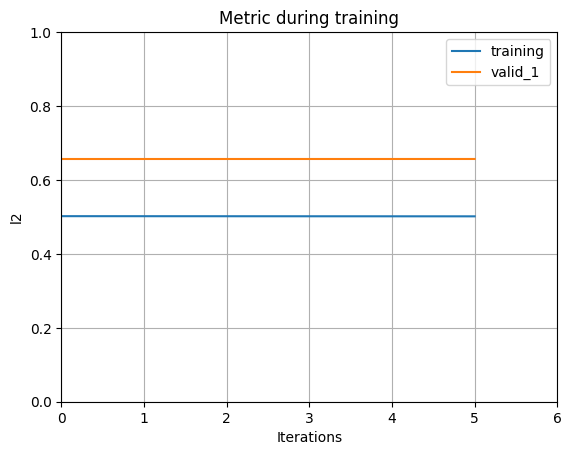

Best iteration: 211
0.656708172041801
Val Weighted R2 score is: 0.010636525612092718
this is date_id_df
(37752, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1306,0,0,3.13989,3.384871,0.005487,2.832221,2.923156,2.381715,-0.514894,0.107299,0.149146,0.449922,11,7,76,-0.658728,0.368991,-0.686645,null,-0.697812,null,-0.958045,-1.923938,0.04438,-0.0108,1.318521,1.251964,0.558619,0.266867,0.967536,0.516287,-0.083411,-0.478412,-0.21742,-0.0137,null,null,2.800765,2.405627,1.018182,0.073079,0.201258,null,-0.111987,null,null,-0.141507,null,-1.915909,1.474698,-0.05904,-0.680467,-0.193265,null,0.411837,null,null,-0.51761,null,-1.54383,2.251062,null,-0.443866,-0.255792,-0.966342,-0.47918,-0.393813,-0.389869,-1.266641,-1.929482,-0.991898,0.45868,-0.512923,-1.062001,-0.141891,-0.682815,null,null,-0.02831,-0.047032,-0.269893,-0.188425,3.07163,-0.43804,-0.283059,0.241247,-0.454847,-1.234912,1.3121,-0.350762,-1.047875,1.753332
1306,0,1,4.624646,3.422935,-0.383838,3.077091,3.092109,3.290656,-0.668193,0.151467,0.167511,0.617898,11,7,76,-1.018568,0.204634,-0.416839,null,-0.784725,null,-1.628239,-1.20067,-1.754201,0.271813,1.779267,1.673437,-0.522075,-0.701307,0.169127,0.812983,1.58639,-0.611368,-0.612531,0.299272,null,null,-0.533824,-0.811797,-1.019605,0.00576,-0.023591,null,-0.652106,null,null,-0.49437,null,-2.252284,1.151001,0.789868,-0.308433,-0.146133,null,0.805959,null,null,-0.338724,null,-1.686088,2.275408,null,0.52126,0.244528,-0.966342,-0.362806,-0.317262,-0.480743,-1.054504,-1.880523,-0.811994,0.192236,-0.498559,-1.082392,0.379283,-0.446475,null,null,-0.271625,-0.302505,-0.27797,-0.29395,0.369605,0.335357,0.377188,0.137611,0.237383,0.456919,0.12482,-0.003339,0.465377,0.112316
1306,0,2,1.329375,3.14877,-0.070929,2.669857,2.844349,2.652243,-0.630974,0.177323,0.217913,0.558564,81,2,59,-0.560798,0.583982,-0.394215,null,0.224515,null,-0.829186,-2.077834,-0.07979,-0.281631,-0.418023,-0.815793,-0.564014,-1.134138,0.539499,0.373442,-0.023116,-0.638961,-0.600101,-0.271102,null,null,1.49944,1.243723,1.975647,0.339446,-0.731647,null,0.797778,null,null,-1.905747,null,-0.547208,0.278971,-1.692358,-1.799391,-0.798665,null,1.741721,null,null,-2.716222,null,-0.619039,0.354328,null,-3.741258,-2.610292,-0.966342,-0.174442,0.069331,-0.168334,-1.890188,-2.13331,-1.000731,0.165508,-0.384966,-0.729791,0.811149,-0.514077,null,null,1.571108,1.880867,0.212818,0.239784,0.340764,2.309508,-0.251121,1.295363,1.770964,2.689301,2.245826,0.192322,2.496475,1.548047
1306,0,3,1.615635,3.251619,-0.772577,3.020361,3.643548,3.132568,-0.484095,0.131564,0.134305,0.356326,4,3,11,-0.707626,0.8313,-0.457905,null,-0.189158,null,-1.015135,-1.284616,0.183652,0.175477,-0.889877,-0.915636,1.686075,1.046306,-0.400524,-1.4300

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1306,967,34,2.063044,2.60755,0.943972,2.593326,2.925504,-0.659406,-0.475247,-0.777331,-0.076269,-0.094658,42,5,150,0.266379,0.813992,0.619112,-0.818637,-0.54695,-0.752494,1.635528,0.245865,-0.05471,-0.175717,-0.348738,-0.3869,0.186914,-0.215882,-0.874307,0.344618,1.799361,-0.357083,-0.735683,-0.214759,2.453603,-0.456876,2.345348,2.280761,-0.188805,-0.157398,-0.089623,0.976471,0.320266,0.767309,-0.527423,0.050327,0.677901,0.409229,-0.550482,0.404226,1.534488,0.973807,0.824159,0.209454,1.224065,-0.00366,0.507039,0.585367,-0.155894,0.004664,0.361584,1.579997,1.428199,-0.966342,-0.357451,-0.339773,-0.319125,1.67818,0.715926,0.229228,0.055097,0.156081,0.450385,1.237366,1.250361,0.704566,0.626428,4.633879,4.436042,2.229448,1.388864,0.32953,-0.256724,-0.241357,-2.267805,-0.010764,-0.003911,-0.48842,0.06558,0.067867,0.113706
1306,967,35,2.265762,3.108546,0.571666,2.947163,2.200047,-0.426158,-0.292871,-0.475703,-0.140188,-0.093288,11,7,76,-0.371368,-0.292694,-0.444325,0.559385,1.408905,0.253087,-0.374069,0.766901,0.106698,1.481936,-0.135313,1.970842,1.135351,1.801844,0.110079,-1.97769,-1.606222,1.669091,1.590086,1.146845,2.953848,-0.671872,2.872708,2.624526,2.175735,-0.810748,-0.85005,1.421186,1.573642,1.262511,1.339415,-0.381027,-0.008973,0.692896,-0.250423,0.617515,0.386823,0.85903,1.117847,1.560111,0.509773,-1.294515,-1.392711,-1.536407,1.129089,-0.37683,0.504086,-1.347485,-0.457659,-0.966342,-0.073944,0.215167,0.142209,-0.570963,1.122976,-0.294114,-0.16255,-0.409508,-0.447543,-0.249828,-0.446912,-0.266525,-0.132074,-0.223067,-0.253792,-0.244769,-0.146858,-0.051451,2.074128,0.920903,-2.326566,0.930266,0.298825,1.167352,0.550881,0.359956,1.011462
1306,967,36,1.81918,2.924451,0.387716,3.409963,2.592965,0.030307,-0.237001,-0.332603,-0.088852,-0.067651,68,6,388,-0.232107,0.13502,-0.013852,-0.104268,-0.092883,-0.166437,-0.952151,2.379539,0.156662,0.515152,-0.423501,1.118492,1.981921,2.31615,-0.446625,-1.563854,-1.658763,0.474925,0.002039,0.320399,2.359787,0.205325,2.868963,2.773334,1.177013,-0.165862,-0.104081,0.78292,1.005372,1.048459,-0.674398,0.617525,0.225082,-0.689734,0.029942,-0.436031,0.193414,-0.143039,-0.915266,0.886333,0.409903,-0.616671,0.16587,0.844593,-0.10164,-0.430637,-0.657009,0.025373,-0.459543,-0.966342,-0.281204,0.054413,-0.145568,-1.118692,1.449934,-0.201053,-0.226739,0.05804,-0.331931,0.618168,-0.071398,-0.355726,-0.288148,-0.169103,-0.252293,-0.22405,-0.250736,-0.327635,2.389779,0.444592,2.806014,1.140265,0.56818,1.814579,0.128666,0.070984,0.172291
1306,967,37,0.994381,3.123984,1.443599,3.265572,2.3

this is updated validation data
(14404808, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1307,0,0,3.664165,3.204483,-0.887518,2.724679,3.083375,3.219579,-2.677166,-0.470632,-1.257333,1.342254,11,7,76,-0.717158,0.328039,-0.219664,null,-0.220069,null,-0.728924,-1.435284,-0.068773,-0.011456,0.759178,1.401372,0.520387,0.158953,0.969541,0.832685,-0.160879,-0.449182,-0.459218,-0.010193,null,null,2.386491,2.302209,0.704393,0.146792,0.670539,null,1.244502,null,null,-0.255298,null,-0.313953,1.178867,-0.909604,1.545123,0.218402,null,0.064809,null,null,-1.573483,null,-2.435092,1.337531,null,-1.456981,-0.937604,-0.825222,-0.335363,-0.243649,-0.503388,-2.861064,-1.438625,-1.147181,0.171394,-0.632525,-1.189284,0.43086,-0.468382,null,null,0.709296,0.542912,-0.031919,-0.078631,-0.789082,-0.614958,-0.13157,-1.19684,1.547356,-0.384893,1.035972,3.07163,-0.146963,2.287796
1307,0,1,4.523115,3.393743,-1.51135,2.839575,2.909152,2.831378,-2.878379,-0.697287,-2.269496,1.828644,11,7,76,-0.492043,0.514215,-0.451293,null,-0.496664,null,-1.909252,-1.744797,-1.421574,0.304613,1.439211,1.924005,-0.936511,-0.997175,-0.147061,0.488465,1.255943,-0.588862,-0.283352,0.231187,null,null,-0.700567,0.759045,-0.264536,0.006391,0.018314,null,0.440912,null,null,-0.541444,null,-1.369054,1.345145,-0.283144,-0.516151,-0.253389,null,0.919655,null,null,-0.21327,null,-1.636456,2.026867,null,-0.124739,-0.064732,-0.825222,-0.376704,-0.255126,-0.285159,-1.866158,-1.786828,-0.833147,0.91696,-0.364875,-1.147107,0.394399,-0.528922,null,null,-0.181597,-0.287212,-0.243762,-0.440776,-0.035927,0.039194,-0.118931,-0.489347,0.498573,0.459312,-0.104631,0.369605,0.531497,0.211732
1307,0,2,1.642587,3.269533,-2.154779,3.225203,3.047261,3.359844,-3.148289,-0.524877,-0.993499,1.19712,81,2,59,-1.109755,2.542353,-0.076283,null,-0.145483,null,-1.645507,-1.053212,-0.138737,-0.168167,-0.645255,-0.915565,-0.186533,-0.668711,0.762417,0.698249,-0.044133,-0.545662,-0.619821,-0.194514,null,null,1.340751,1.106932,1.820087,0.00615,0.56533,null,1.561892,null,null,-0.582931,null,-0.959351,0.664088,-0.223924,2.263379,0.88389,null,2.488275,null,null,-0.535783,null,-0.63791,1.547131,null,3.338625,0.673135,-0.825222,-0.205387,0.189225,-0.256466,-1.995629,-2.671183,-1.049932,1.113382,-0.268048,-0.704279,3.42776,0.186032,null,null,0.466676,0.633381,-0.088484,-0.090083,-0.251854,-0.602017,0.483673,1.676545,-0.322553,-1.928,-0.58874,0.340764,-3.065854,-2.687907
1307,0,3,1.747213,3.301191,-1.423706,2.995613,3.0086,3.275723,-2.442505,-0.446664,-1.038777,0.94471,4,3,11,-0.652557,0.207526,-0.610626,null,-0.585031,null,-0.796016,-2.60481,0.105558,0.173469,-0.731377,-0.75472,1.122091,1.6693

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1698,967,34,3.242493,2.52516,-0.721981,2.544025,2.477615,0.417557,0.785812,1.117796,2.199436,0.415427,42,5,150,0.804403,1.157257,1.031543,-0.671189,-0.3286,-0.486132,1.730176,-0.006173,-0.001144,-0.213062,0.932618,1.367338,-0.238197,-0.692615,-0.121163,1.090798,1.444294,-0.675626,-1.013264,-0.242888,3.427639,-0.958278,3.139836,3.416278,-1.655316,-0.59944,-0.932876,2.493458,0.969462,1.102016,0.158982,-0.496177,0.036177,1.309866,0.828025,1.577955,1.040802,1.255398,2.577441,0.057455,0.953005,1.377051,-0.396358,0.520262,1.179617,1.127657,2.231928,0.614652,2.412886,-1.101531,-0.384833,-0.275818,-0.40804,2.427115,-0.108427,0.739734,0.830205,0.366287,1.33325,1.075499,1.798264,-0.183443,-0.190222,0.234211,0.347142,-0.044463,0.016936,-0.132337,0.501321,0.905332,-0.819582,-0.564046,-0.223018,-0.283954,-0.045938,0.009797,-0.102538
1698,967,35,1.079139,1.857906,-0.790646,2.745439,2.339877,0.845065,0.65137,1.180301,1.966379,0.321543,25,7,195,-0.075294,-0.152726,-0.20417,-0.421137,0.21708,-0.258775,1.874978,0.19988,-0.199219,-0.125619,-1.004547,-0.051933,0.450905,0.009246,0.164127,-0.939974,-1.143421,-0.320071,-0.379835,-0.142429,3.862469,-1.451786,3.477489,2.861663,0.763459,0.075972,-0.119677,0.626035,0.148815,0.653281,0.059313,-0.845099,0.098528,0.409564,-0.675728,-0.011334,0.930534,0.83198,0.808955,0.219276,-0.315776,0.687755,-1.189577,0.180146,-0.175486,-1.60435,-0.209283,0.249847,0.288816,-1.101531,-0.343868,-0.253991,-0.278832,2.050639,-0.059506,-0.029396,-0.101381,-0.187759,-0.180839,-0.0861,-0.153405,-0.196077,-0.175292,1.04578,0.739733,0.03372,0.05086,-0.249584,-1.113053,0.69719,-1.619031,-1.222743,-0.706082,-0.291133,0.167733,0.099704,0.32461
1698,967,36,1.033172,2.515527,-0.672298,2.28925,2.521592,0.255077,0.919892,1.172018,2.180496,0.24846,49,7,297,1.026715,-0.096892,0.224309,-0.528109,-0.704952,-0.704818,2.312482,0.32804,-0.108193,null,-0.945684,-0.244173,0.205989,-0.357343,null,null,-1.11075,-0.580242,-0.400568,null,2.397877,-0.637258,3.260638,3.046786,0.440965,0.234842,-0.17558,1.022406,-0.500069,2.071033,0.413488,-0.450016,-0.156616,-0.253755,-0.769588,0.066086,0.047826,1.713707,0.772772,-0.549192,1.338474,0.933568,0.032978,-0.519118,-0.290343,-0.806786,0.106295,0.183461,1.830421,-1.101531,-0.341991,-0.249132,-0.34365,2.251358,0.601888,1.035051,-0.283241,0.107244,0.86016,0.024223,0.374852,-0.220933,-0.161584,0.032771,0.036888,0.168908,0.152333,-0.065355,-1.019353,-0.460962,-2.026678,-0.848606,-0.305448,-1.256913,-0.109359,-0.027474,-0.253956
1698,967,37,1.243116,2.663298,-0.889112,2.313155,3.101428,0.324454,

<Figure size 640x480 with 0 Axes>

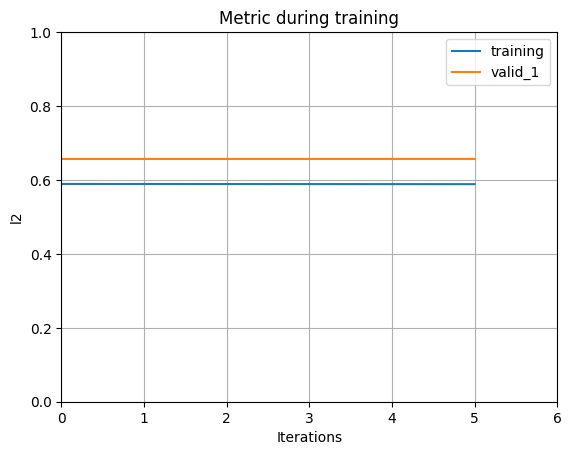

Best iteration: 212
0.6568797897091007
Val Weighted R2 score is: 0.010639707582423719
this is date_id_df
(36784, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1307,0,0,3.664165,3.204483,-0.887518,2.724679,3.083375,3.219579,-2.677166,-0.470632,-1.257333,1.342254,11,7,76,-0.717158,0.328039,-0.219664,null,-0.220069,null,-0.728924,-1.435284,-0.068773,-0.011456,0.759178,1.401372,0.520387,0.158953,0.969541,0.832685,-0.160879,-0.449182,-0.459218,-0.010193,null,null,2.386491,2.302209,0.704393,0.146792,0.670539,null,1.244502,null,null,-0.255298,null,-0.313953,1.178867,-0.909604,1.545123,0.218402,null,0.064809,null,null,-1.573483,null,-2.435092,1.337531,null,-1.456981,-0.937604,-0.825222,-0.335363,-0.243649,-0.503388,-2.861064,-1.438625,-1.147181,0.171394,-0.632525,-1.189284,0.43086,-0.468382,null,null,0.709296,0.542912,-0.031919,-0.078631,-0.789082,-0.614958,-0.13157,-1.19684,1.547356,-0.384893,1.035972,3.07163,-0.146963,2.287796
1307,0,1,4.523115,3.393743,-1.51135,2.839575,2.909152,2.831378,-2.878379,-0.697287,-2.269496,1.828644,11,7,76,-0.492043,0.514215,-0.451293,null,-0.496664,null,-1.909252,-1.744797,-1.421574,0.304613,1.439211,1.924005,-0.936511,-0.997175,-0.147061,0.488465,1.255943,-0.588862,-0.283352,0.231187,null,null,-0.700567,0.759045,-0.264536,0.006391,0.018314,null,0.440912,null,null,-0.541444,null,-1.369054,1.345145,-0.283144,-0.516151,-0.253389,null,0.919655,null,null,-0.21327,null,-1.636456,2.026867,null,-0.124739,-0.064732,-0.825222,-0.376704,-0.255126,-0.285159,-1.866158,-1.786828,-0.833147,0.91696,-0.364875,-1.147107,0.394399,-0.528922,null,null,-0.181597,-0.287212,-0.243762,-0.440776,-0.035927,0.039194,-0.118931,-0.489347,0.498573,0.459312,-0.104631,0.369605,0.531497,0.211732
1307,0,2,1.642587,3.269533,-2.154779,3.225203,3.047261,3.359844,-3.148289,-0.524877,-0.993499,1.19712,81,2,59,-1.109755,2.542353,-0.076283,null,-0.145483,null,-1.645507,-1.053212,-0.138737,-0.168167,-0.645255,-0.915565,-0.186533,-0.668711,0.762417,0.698249,-0.044133,-0.545662,-0.619821,-0.194514,null,null,1.340751,1.106932,1.820087,0.00615,0.56533,null,1.561892,null,null,-0.582931,null,-0.959351,0.664088,-0.223924,2.263379,0.88389,null,2.488275,null,null,-0.535783,null,-0.63791,1.547131,null,3.338625,0.673135,-0.825222,-0.205387,0.189225,-0.256466,-1.995629,-2.671183,-1.049932,1.113382,-0.268048,-0.704279,3.42776,0.186032,null,null,0.466676,0.633381,-0.088484,-0.090083,-0.251854,-0.602017,0.483673,1.676545,-0.322553,-1.928,-0.58874,0.340764,-3.065854,-2.687907
1307,0,3,1.747213,3.301191,-1.423706,2.995613,3.0086,3.275723,-2.442505,-0.446664,-1.038777,0.94471,4,3,11,-0.652557,0.207526,-0.610626,null,-0.585031,null,-0.796016,-2.60481,0.105558,0.173469,-0.731377,-0.75472,1.122091,1.6693

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1307,967,34,2.119364,3.307284,-0.691351,3.641287,2.667446,0.813335,0.238963,-0.560619,-0.59308,1.687246,42,5,150,0.24803,0.727789,0.149991,-0.798623,-0.570254,-0.553807,1.715716,2.419296,-0.270565,-0.220254,-0.232485,-0.520978,0.105495,-0.343409,-0.972428,0.672275,1.175492,-0.578436,-0.549316,-0.183887,2.205897,-0.616214,2.05619,1.923606,-0.150368,-0.802596,-0.1812,-0.417218,0.371708,0.15691,-0.105359,-0.123914,0.516117,1.878276,0.93823,0.954956,0.060042,0.094397,-0.028683,0.244786,0.198117,0.636647,0.402565,1.434847,0.640636,1.345569,1.323144,0.479611,0.33043,-0.825222,-0.350881,-0.280982,-0.323478,-1.494063,2.507806,-0.029358,0.144899,-0.003577,0.393875,1.007937,0.712439,-0.1525,-0.110986,0.065059,0.157114,-0.103331,-0.078107,-0.241263,0.869412,0.438304,-0.261096,0.24392,0.118339,0.066495,0.32953,0.097957,0.44791
1307,967,35,2.197865,3.299857,-1.082792,3.654349,3.145875,-0.1368,0.1621,-0.567222,-0.548017,1.269659,11,7,76,-0.875067,-0.254682,-0.437766,1.117608,1.025753,1.410527,1.765037,0.798097,0.021696,0.73149,-0.276015,1.386616,0.868201,1.545358,0.134402,-1.829001,-2.522737,2.44646,1.101007,0.895784,2.010396,-1.064074,3.02677,2.850537,0.114006,-0.937844,-0.319865,0.128492,1.581954,1.577476,-0.225055,-0.397224,-0.036497,0.599891,-2.119206,0.411358,0.55287,0.218564,-0.183262,0.924221,0.471174,-0.546699,-0.773231,0.298246,0.652338,-0.489785,0.680257,0.169918,0.150601,-0.825222,-0.016502,0.422385,0.169015,-1.490499,-0.102428,-0.898655,-0.317005,-0.561332,-0.684234,-0.086812,-0.334685,-0.327331,-0.496455,-0.211301,-0.171493,-0.206966,-0.251941,-0.141891,-0.62324,0.551031,-2.095304,-0.380984,-0.236523,-0.147203,-0.051451,0.005446,-0.148527
1307,967,36,2.111356,3.458421,-1.444028,3.032766,3.288159,0.925569,0.100279,-0.540718,-0.54501,1.069857,68,6,388,-0.075928,0.073726,-0.294668,-0.07086,-0.103199,-0.0834,1.15098,-0.377325,0.056795,0.52386,-0.488223,1.132581,2.052134,1.735336,-0.279691,-1.386012,-1.749478,0.554475,0.004183,0.522521,2.759957,-0.541881,2.850713,2.747868,-1.190759,-0.033237,0.666059,-0.140006,0.110551,0.980022,-0.351806,-0.978549,-0.54802,0.496568,0.986147,0.406955,-0.003757,-0.036907,-0.626071,0.538645,-0.709606,0.268336,0.111368,0.069987,0.50439,-0.047237,0.749094,-0.064461,-0.008146,-0.825222,-0.342506,-0.081008,-0.2075,1.850742,-0.576799,-0.397896,0.219052,-0.316779,0.179903,-0.148716,-0.384683,-0.401445,-0.350648,-0.230777,-0.472063,-0.291839,-0.318641,-0.050558,-0.215224,0.151941,0.591572,-0.375843,-0.290856,-0.096961,-0.327635,-0.165674,-0.644517
1307,967,37,0.971545,3.120388,-1.195009,2.862

this is updated validation data
(14368024, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1308,0,0,2.887684,3.027576,1.787128,2.951052,2.566097,-2.028119,1.520984,2.476138,2.022141,-1.137497,11,7,76,-0.918761,0.561217,-0.351289,null,-0.387939,null,-1.694443,-1.645637,-0.072114,-0.00816,1.028562,1.318391,0.450759,0.186345,1.438508,0.655457,-0.139583,-0.358343,-0.352044,-0.010816,null,null,2.166785,2.017746,2.292399,-0.016519,-0.419868,null,0.964965,null,null,-0.368321,null,-1.271649,1.555068,1.290397,0.08375,0.595807,null,0.737045,null,null,-1.048115,null,-0.965352,1.683293,null,-0.204623,-0.034137,-0.722337,-0.405615,-0.223093,-0.356693,-1.809564,-1.414545,-0.755391,0.600207,-0.170938,-1.180101,0.747437,-0.34443,null,null,0.185809,0.16619,-0.152953,-0.115095,0.304785,0.09209,-0.061114,0.763198,-0.664357,-0.712512,0.592873,-0.789082,-0.476005,0.796918
1308,0,1,5.082413,2.827529,2.004158,2.7735,2.960715,-2.093643,3.93491,2.813426,4.886672,-1.049575,11,7,76,-0.958353,1.259481,-0.241356,null,-0.700305,null,-1.241549,-1.246437,-2.97766,0.535239,2.680547,1.933292,-0.560338,-0.392762,-0.175816,0.254855,1.241857,-0.543582,-0.503309,0.382699,null,null,-1.427169,-1.194636,1.108884,0.086252,-0.054983,null,-0.161572,null,null,-0.424615,null,-1.846841,1.635674,1.231416,0.065899,0.25145,null,-0.576138,null,null,0.151631,null,-2.220599,1.669148,null,-0.016431,-0.018416,-0.722337,-0.481557,-0.228801,-0.339048,-1.799987,-1.837709,-0.742496,2.179501,0.144348,-1.486928,-0.271339,-0.666722,null,null,-0.266759,-0.325321,-0.391476,-0.351659,0.283982,-0.609371,-0.761065,-0.186787,-0.273826,-0.540864,-0.417708,-0.035927,-0.064652,-0.273496
1308,0,2,1.55158,3.073052,1.493118,2.82352,2.198702,-2.422809,2.928499,2.460554,2.862683,-0.898673,81,2,59,-1.134922,0.796651,-0.215888,null,-0.206031,null,-1.597341,-0.552399,-0.111346,-0.187389,-0.912651,-0.750423,-0.199536,-0.620454,0.536264,0.623745,-0.059124,-0.598337,-0.702691,-0.33608,null,null,2.254816,2.637911,2.559493,0.167142,-0.23903,null,0.125769,null,null,-1.461056,null,-1.605375,1.093644,0.795065,0.122625,0.392403,null,-1.351631,null,null,-1.946082,null,-3.194927,0.909623,null,-5.653128,-1.453082,-0.722337,-0.336056,0.00516,-0.207531,-1.62998,-1.957224,-0.77884,0.775112,-0.334415,-0.833531,0.776615,-0.193248,null,null,0.43725,0.754536,-0.086927,-0.09181,-2.604979,0.950882,0.377836,0.418447,0.208116,-1.160307,1.428661,-0.251854,-1.805166,2.312986
1308,0,3,1.637416,2.634048,1.508222,2.23217,2.731521,-2.421481,1.798143,2.746108,2.304681,-0.897079,4,3,11,-0.921214,0.602964,-0.532541,null,0.519745,null,-2.042388,-0.892371,0.075864,0.138083,-0.861424,-0.854072,1.159652,2.370121

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1698,967,34,3.242493,2.52516,-0.721981,2.544025,2.477615,0.417557,0.785812,1.117796,2.199436,0.415427,42,5,150,0.804403,1.157257,1.031543,-0.671189,-0.3286,-0.486132,1.730176,-0.006173,-0.001144,-0.213062,0.932618,1.367338,-0.238197,-0.692615,-0.121163,1.090798,1.444294,-0.675626,-1.013264,-0.242888,3.427639,-0.958278,3.139836,3.416278,-1.655316,-0.59944,-0.932876,2.493458,0.969462,1.102016,0.158982,-0.496177,0.036177,1.309866,0.828025,1.577955,1.040802,1.255398,2.577441,0.057455,0.953005,1.377051,-0.396358,0.520262,1.179617,1.127657,2.231928,0.614652,2.412886,-1.101531,-0.384833,-0.275818,-0.40804,2.427115,-0.108427,0.739734,0.830205,0.366287,1.33325,1.075499,1.798264,-0.183443,-0.190222,0.234211,0.347142,-0.044463,0.016936,-0.132337,0.501321,0.905332,-0.819582,-0.564046,-0.223018,-0.283954,-0.045938,0.009797,-0.102538
1698,967,35,1.079139,1.857906,-0.790646,2.745439,2.339877,0.845065,0.65137,1.180301,1.966379,0.321543,25,7,195,-0.075294,-0.152726,-0.20417,-0.421137,0.21708,-0.258775,1.874978,0.19988,-0.199219,-0.125619,-1.004547,-0.051933,0.450905,0.009246,0.164127,-0.939974,-1.143421,-0.320071,-0.379835,-0.142429,3.862469,-1.451786,3.477489,2.861663,0.763459,0.075972,-0.119677,0.626035,0.148815,0.653281,0.059313,-0.845099,0.098528,0.409564,-0.675728,-0.011334,0.930534,0.83198,0.808955,0.219276,-0.315776,0.687755,-1.189577,0.180146,-0.175486,-1.60435,-0.209283,0.249847,0.288816,-1.101531,-0.343868,-0.253991,-0.278832,2.050639,-0.059506,-0.029396,-0.101381,-0.187759,-0.180839,-0.0861,-0.153405,-0.196077,-0.175292,1.04578,0.739733,0.03372,0.05086,-0.249584,-1.113053,0.69719,-1.619031,-1.222743,-0.706082,-0.291133,0.167733,0.099704,0.32461
1698,967,36,1.033172,2.515527,-0.672298,2.28925,2.521592,0.255077,0.919892,1.172018,2.180496,0.24846,49,7,297,1.026715,-0.096892,0.224309,-0.528109,-0.704952,-0.704818,2.312482,0.32804,-0.108193,null,-0.945684,-0.244173,0.205989,-0.357343,null,null,-1.11075,-0.580242,-0.400568,null,2.397877,-0.637258,3.260638,3.046786,0.440965,0.234842,-0.17558,1.022406,-0.500069,2.071033,0.413488,-0.450016,-0.156616,-0.253755,-0.769588,0.066086,0.047826,1.713707,0.772772,-0.549192,1.338474,0.933568,0.032978,-0.519118,-0.290343,-0.806786,0.106295,0.183461,1.830421,-1.101531,-0.341991,-0.249132,-0.34365,2.251358,0.601888,1.035051,-0.283241,0.107244,0.86016,0.024223,0.374852,-0.220933,-0.161584,0.032771,0.036888,0.168908,0.152333,-0.065355,-1.019353,-0.460962,-2.026678,-0.848606,-0.305448,-1.256913,-0.109359,-0.027474,-0.253956
1698,967,37,1.243116,2.663298,-0.889112,2.313155,3.101428,0.324454,

<Figure size 640x480 with 0 Axes>

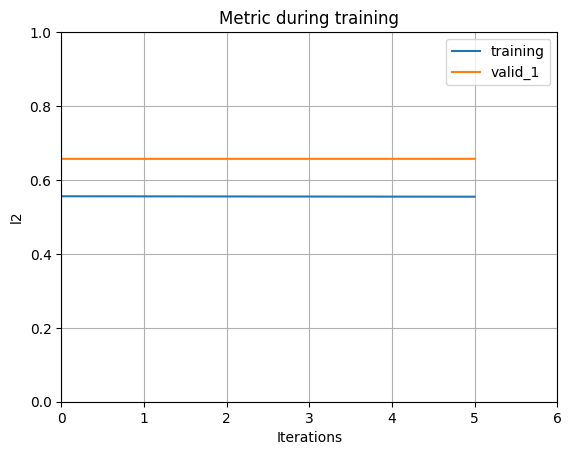

Best iteration: 213
0.6571277144519904
Val Weighted R2 score is: 0.01062326238242528
this is date_id_df
(36784, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1308,0,0,2.887684,3.027576,1.787128,2.951052,2.566097,-2.028119,1.520984,2.476138,2.022141,-1.137497,11,7,76,-0.918761,0.561217,-0.351289,null,-0.387939,null,-1.694443,-1.645637,-0.072114,-0.00816,1.028562,1.318391,0.450759,0.186345,1.438508,0.655457,-0.139583,-0.358343,-0.352044,-0.010816,null,null,2.166785,2.017746,2.292399,-0.016519,-0.419868,null,0.964965,null,null,-0.368321,null,-1.271649,1.555068,1.290397,0.08375,0.595807,null,0.737045,null,null,-1.048115,null,-0.965352,1.683293,null,-0.204623,-0.034137,-0.722337,-0.405615,-0.223093,-0.356693,-1.809564,-1.414545,-0.755391,0.600207,-0.170938,-1.180101,0.747437,-0.34443,null,null,0.185809,0.16619,-0.152953,-0.115095,0.304785,0.09209,-0.061114,0.763198,-0.664357,-0.712512,0.592873,-0.789082,-0.476005,0.796918
1308,0,1,5.082413,2.827529,2.004158,2.7735,2.960715,-2.093643,3.93491,2.813426,4.886672,-1.049575,11,7,76,-0.958353,1.259481,-0.241356,null,-0.700305,null,-1.241549,-1.246437,-2.97766,0.535239,2.680547,1.933292,-0.560338,-0.392762,-0.175816,0.254855,1.241857,-0.543582,-0.503309,0.382699,null,null,-1.427169,-1.194636,1.108884,0.086252,-0.054983,null,-0.161572,null,null,-0.424615,null,-1.846841,1.635674,1.231416,0.065899,0.25145,null,-0.576138,null,null,0.151631,null,-2.220599,1.669148,null,-0.016431,-0.018416,-0.722337,-0.481557,-0.228801,-0.339048,-1.799987,-1.837709,-0.742496,2.179501,0.144348,-1.486928,-0.271339,-0.666722,null,null,-0.266759,-0.325321,-0.391476,-0.351659,0.283982,-0.609371,-0.761065,-0.186787,-0.273826,-0.540864,-0.417708,-0.035927,-0.064652,-0.273496
1308,0,2,1.55158,3.073052,1.493118,2.82352,2.198702,-2.422809,2.928499,2.460554,2.862683,-0.898673,81,2,59,-1.134922,0.796651,-0.215888,null,-0.206031,null,-1.597341,-0.552399,-0.111346,-0.187389,-0.912651,-0.750423,-0.199536,-0.620454,0.536264,0.623745,-0.059124,-0.598337,-0.702691,-0.33608,null,null,2.254816,2.637911,2.559493,0.167142,-0.23903,null,0.125769,null,null,-1.461056,null,-1.605375,1.093644,0.795065,0.122625,0.392403,null,-1.351631,null,null,-1.946082,null,-3.194927,0.909623,null,-5.653128,-1.453082,-0.722337,-0.336056,0.00516,-0.207531,-1.62998,-1.957224,-0.77884,0.775112,-0.334415,-0.833531,0.776615,-0.193248,null,null,0.43725,0.754536,-0.086927,-0.09181,-2.604979,0.950882,0.377836,0.418447,0.208116,-1.160307,1.428661,-0.251854,-1.805166,2.312986
1308,0,3,1.637416,2.634048,1.508222,2.23217,2.731521,-2.421481,1.798143,2.746108,2.304681,-0.897079,4,3,11,-0.921214,0.602964,-0.532541,null,0.519745,null,-2.042388,-0.892371,0.075864,0.138083,-0.861424,-0.854072,1.159652,2.370121

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1308,967,34,2.254158,2.465925,-1.808359,3.086504,3.138962,-2.148496,-1.916932,-0.688246,-2.874486,-0.59636,42,5,150,0.588537,0.191889,0.60873,-0.51754,-0.526118,-0.733444,0.115452,2.041001,-0.211203,-0.170738,-0.323754,-0.413648,0.131503,-0.249405,-0.738922,0.651641,0.5618,-0.921444,-1.021204,-0.22055,2.495464,-0.205834,1.49477,1.889952,0.063853,-0.65147,-0.800712,-0.895466,0.231,0.508009,-1.176621,0.561949,-0.631147,0.858143,-1.505155,-0.835638,-0.103145,-0.636089,-0.945111,0.335606,-0.413971,-1.28463,0.212174,-0.485163,0.785744,-0.717501,-0.807149,0.023954,-1.009744,-0.722337,-0.367475,-0.296016,-0.375342,-0.265855,0.977195,0.374741,0.208501,1.141165,0.300639,0.056812,0.010836,0.073874,0.140287,-0.118596,-0.016005,-0.030025,0.034621,-0.472065,0.170218,-0.031969,0.405454,-1.284822,-0.477158,-0.102202,-0.241263,-0.083598,-0.586844
1308,967,35,1.93089,2.950783,-1.892202,2.547207,2.614638,-2.493334,-0.659964,-0.481355,-2.191051,-0.636515,11,7,76,-0.589871,-0.378511,-0.754847,0.570366,0.782352,0.799328,1.887507,-1.261348,0.283451,1.183427,-0.578996,1.362405,1.015925,1.646389,0.095654,-2.299084,-2.284826,1.961447,0.990029,0.74493,2.27168,-0.341584,2.297494,2.286519,1.777488,0.631822,-0.004052,0.480984,-1.324907,0.644298,-0.744171,-1.211097,-0.95673,-0.379697,-0.50293,-0.159938,-0.002892,-0.305159,-0.078869,0.714975,0.92785,-0.843342,-1.345626,-0.80081,-0.695816,-0.269131,-0.3638,-0.236675,-0.638331,-0.722337,-0.14649,-0.194174,-0.133794,1.776499,1.044045,-0.986884,-0.223922,-0.640484,-0.981451,-0.426546,-0.805433,-0.296716,-0.436117,-0.213422,-0.181464,-0.320307,-0.333334,-0.190884,0.538408,0.006545,-2.368412,0.452917,0.172278,0.36589,-0.141891,-0.041934,-0.452902
1308,967,36,2.213084,2.923341,-1.821226,3.067055,2.580642,-2.620527,-1.519244,-0.645155,-1.583147,-0.410104,68,6,388,-0.027842,0.923388,0.32597,-0.08636,-0.220817,-0.111607,1.324843,1.601743,0.149221,0.55712,-0.773407,0.885946,1.309868,2.820584,-0.294596,-1.700067,-1.747402,0.657154,-0.012808,0.642756,1.887594,1.07513,1.947767,1.700518,1.720403,0.488284,0.317386,-0.294448,0.045566,0.483453,-1.487876,0.345791,-0.283249,0.502676,-1.054916,-0.560058,-0.155031,-0.400964,-0.665312,0.255969,0.329095,-1.396722,-0.345622,-0.745367,0.511944,-0.57835,-0.722062,-0.213061,-1.158618,-0.722337,-0.24426,-0.196684,-0.239752,1.451336,1.364621,0.282861,2.020831,0.990189,-0.41708,-0.096413,-0.311626,-0.333098,-0.471156,-0.223589,-0.32307,-0.282837,-0.405233,-0.173045,0.115019,0.276112,-1.347405,0.081219,0.062067,-0.067638,-0.050558,0.007166,-0.118246
1308,967,37,0.841506,2

this is updated validation data
(14331240, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1309,0,0,3.377367,2.821043,2.034805,2.757153,3.125676,1.8279,0.394708,-0.777105,-0.76642,0.006962,11,7,76,-1.015978,0.112763,-0.416777,null,-0.419292,null,-1.363913,-1.903826,-0.166166,-0.012297,0.866744,0.64089,0.44126,0.123857,0.816155,1.018195,-0.14145,-0.372966,-0.539205,-0.012833,null,null,2.239973,1.682941,0.003607,0.049657,-0.127802,null,0.762442,null,null,-1.025781,null,-1.504023,0.357259,0.083749,0.371802,0.064029,null,-0.328958,null,null,-1.746493,null,-2.552068,1.223085,null,-1.643772,-0.867774,-0.275999,-0.40381,-0.014412,-0.269044,-1.436131,-2.152638,-0.927544,0.151715,-0.452659,-0.801966,0.052881,-0.427056,null,null,-0.260798,-0.227222,-0.300148,-0.255302,-1.252792,-0.036047,-0.829735,-0.032891,0.108149,0.082569,0.908647,0.304785,0.627925,1.213906
1309,0,1,4.912787,2.761551,2.098746,3.236721,3.202878,1.557542,0.476487,-1.141055,-1.106389,0.012322,11,7,76,-1.419614,-0.2991,-0.65311,null,-0.322092,null,-1.01207,-1.762593,-1.749476,0.272304,1.68587,2.081145,-0.763827,-0.959818,-0.144155,0.180756,0.693119,-0.613221,-0.718014,0.252226,null,null,-1.267616,-1.668471,0.332758,0.059477,-0.056916,null,-0.147869,null,null,-0.231913,null,-0.852034,1.531543,0.031033,-0.009151,0.018253,null,-0.770926,null,null,-0.476254,null,-3.262707,1.841582,null,-0.001978,-0.015852,-0.275999,-0.457671,-0.197778,-0.422948,-1.876673,-1.665651,-1.134837,-0.313931,-0.676337,-1.173919,-0.163728,-0.616085,null,null,-0.367105,-0.276585,-0.399258,-0.244189,-0.812724,-0.151077,-0.168455,-0.13862,0.20915,-0.4289,-0.402868,0.283982,-0.305856,-0.750965
1309,0,2,1.302541,2.714106,2.225782,2.857209,3.132305,2.143897,0.285906,-0.78801,-0.424391,0.010071,81,2,59,-0.94969,0.116515,-0.488653,null,0.519567,null,-1.187952,-1.659269,-0.05042,-0.264314,-0.886541,-0.603709,0.052998,-0.746396,0.752804,0.015112,-0.25379,-0.564711,-0.622297,-0.203942,null,null,2.653172,2.295219,0.941108,0.289481,0.18492,null,0.977315,null,null,-0.41833,null,-1.568021,0.925579,-0.85962,1.025113,-0.138317,null,1.199273,null,null,-1.78185,null,-1.066132,0.901902,null,-3.318656,-2.014119,-0.275999,-0.290215,-0.220742,-0.178991,-1.809023,-1.852351,-0.760501,0.3098,-0.475737,-1.180521,-0.249238,-0.717073,null,null,2.326772,2.114797,0.564143,0.427989,0.848683,-1.361713,-0.392494,-0.691798,-1.870307,-3.848361,1.272329,-2.604979,-3.158823,3.349915
1309,0,3,1.451503,3.033246,1.504675,2.77107,3.111407,1.276903,0.215022,-0.557094,-0.458679,0.006518,4,3,11,-0.665354,0.268505,-0.547926,null,-0.306065,null,-1.255725,-0.959323,0.072285,0.178554,-0.481985,-0.750671,1.659466,1.749891

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1698,967,34,3.242493,2.52516,-0.721981,2.544025,2.477615,0.417557,0.785812,1.117796,2.199436,0.415427,42,5,150,0.804403,1.157257,1.031543,-0.671189,-0.3286,-0.486132,1.730176,-0.006173,-0.001144,-0.213062,0.932618,1.367338,-0.238197,-0.692615,-0.121163,1.090798,1.444294,-0.675626,-1.013264,-0.242888,3.427639,-0.958278,3.139836,3.416278,-1.655316,-0.59944,-0.932876,2.493458,0.969462,1.102016,0.158982,-0.496177,0.036177,1.309866,0.828025,1.577955,1.040802,1.255398,2.577441,0.057455,0.953005,1.377051,-0.396358,0.520262,1.179617,1.127657,2.231928,0.614652,2.412886,-1.101531,-0.384833,-0.275818,-0.40804,2.427115,-0.108427,0.739734,0.830205,0.366287,1.33325,1.075499,1.798264,-0.183443,-0.190222,0.234211,0.347142,-0.044463,0.016936,-0.132337,0.501321,0.905332,-0.819582,-0.564046,-0.223018,-0.283954,-0.045938,0.009797,-0.102538
1698,967,35,1.079139,1.857906,-0.790646,2.745439,2.339877,0.845065,0.65137,1.180301,1.966379,0.321543,25,7,195,-0.075294,-0.152726,-0.20417,-0.421137,0.21708,-0.258775,1.874978,0.19988,-0.199219,-0.125619,-1.004547,-0.051933,0.450905,0.009246,0.164127,-0.939974,-1.143421,-0.320071,-0.379835,-0.142429,3.862469,-1.451786,3.477489,2.861663,0.763459,0.075972,-0.119677,0.626035,0.148815,0.653281,0.059313,-0.845099,0.098528,0.409564,-0.675728,-0.011334,0.930534,0.83198,0.808955,0.219276,-0.315776,0.687755,-1.189577,0.180146,-0.175486,-1.60435,-0.209283,0.249847,0.288816,-1.101531,-0.343868,-0.253991,-0.278832,2.050639,-0.059506,-0.029396,-0.101381,-0.187759,-0.180839,-0.0861,-0.153405,-0.196077,-0.175292,1.04578,0.739733,0.03372,0.05086,-0.249584,-1.113053,0.69719,-1.619031,-1.222743,-0.706082,-0.291133,0.167733,0.099704,0.32461
1698,967,36,1.033172,2.515527,-0.672298,2.28925,2.521592,0.255077,0.919892,1.172018,2.180496,0.24846,49,7,297,1.026715,-0.096892,0.224309,-0.528109,-0.704952,-0.704818,2.312482,0.32804,-0.108193,null,-0.945684,-0.244173,0.205989,-0.357343,null,null,-1.11075,-0.580242,-0.400568,null,2.397877,-0.637258,3.260638,3.046786,0.440965,0.234842,-0.17558,1.022406,-0.500069,2.071033,0.413488,-0.450016,-0.156616,-0.253755,-0.769588,0.066086,0.047826,1.713707,0.772772,-0.549192,1.338474,0.933568,0.032978,-0.519118,-0.290343,-0.806786,0.106295,0.183461,1.830421,-1.101531,-0.341991,-0.249132,-0.34365,2.251358,0.601888,1.035051,-0.283241,0.107244,0.86016,0.024223,0.374852,-0.220933,-0.161584,0.032771,0.036888,0.168908,0.152333,-0.065355,-1.019353,-0.460962,-2.026678,-0.848606,-0.305448,-1.256913,-0.109359,-0.027474,-0.253956
1698,967,37,1.243116,2.663298,-0.889112,2.313155,3.101428,0.324454,

<Figure size 640x480 with 0 Axes>

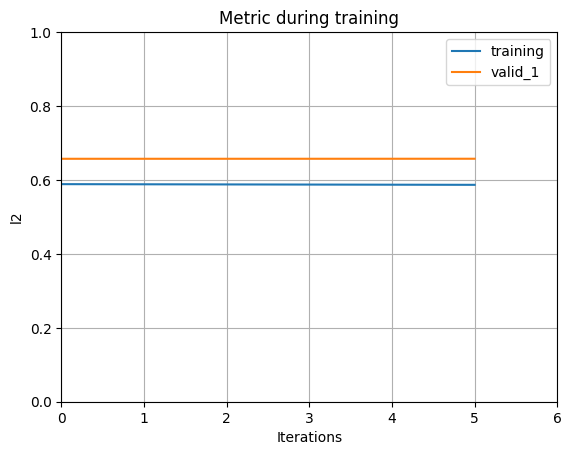

Best iteration: 214
0.6572882998290044
Val Weighted R2 score is: 0.01058355732361993
this is date_id_df
(37752, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1309,0,0,3.377367,2.821043,2.034805,2.757153,3.125676,1.8279,0.394708,-0.777105,-0.76642,0.006962,11,7,76,-1.015978,0.112763,-0.416777,null,-0.419292,null,-1.363913,-1.903826,-0.166166,-0.012297,0.866744,0.64089,0.44126,0.123857,0.816155,1.018195,-0.14145,-0.372966,-0.539205,-0.012833,null,null,2.239973,1.682941,0.003607,0.049657,-0.127802,null,0.762442,null,null,-1.025781,null,-1.504023,0.357259,0.083749,0.371802,0.064029,null,-0.328958,null,null,-1.746493,null,-2.552068,1.223085,null,-1.643772,-0.867774,-0.275999,-0.40381,-0.014412,-0.269044,-1.436131,-2.152638,-0.927544,0.151715,-0.452659,-0.801966,0.052881,-0.427056,null,null,-0.260798,-0.227222,-0.300148,-0.255302,-1.252792,-0.036047,-0.829735,-0.032891,0.108149,0.082569,0.908647,0.304785,0.627925,1.213906
1309,0,1,4.912787,2.761551,2.098746,3.236721,3.202878,1.557542,0.476487,-1.141055,-1.106389,0.012322,11,7,76,-1.419614,-0.2991,-0.65311,null,-0.322092,null,-1.01207,-1.762593,-1.749476,0.272304,1.68587,2.081145,-0.763827,-0.959818,-0.144155,0.180756,0.693119,-0.613221,-0.718014,0.252226,null,null,-1.267616,-1.668471,0.332758,0.059477,-0.056916,null,-0.147869,null,null,-0.231913,null,-0.852034,1.531543,0.031033,-0.009151,0.018253,null,-0.770926,null,null,-0.476254,null,-3.262707,1.841582,null,-0.001978,-0.015852,-0.275999,-0.457671,-0.197778,-0.422948,-1.876673,-1.665651,-1.134837,-0.313931,-0.676337,-1.173919,-0.163728,-0.616085,null,null,-0.367105,-0.276585,-0.399258,-0.244189,-0.812724,-0.151077,-0.168455,-0.13862,0.20915,-0.4289,-0.402868,0.283982,-0.305856,-0.750965
1309,0,2,1.302541,2.714106,2.225782,2.857209,3.132305,2.143897,0.285906,-0.78801,-0.424391,0.010071,81,2,59,-0.94969,0.116515,-0.488653,null,0.519567,null,-1.187952,-1.659269,-0.05042,-0.264314,-0.886541,-0.603709,0.052998,-0.746396,0.752804,0.015112,-0.25379,-0.564711,-0.622297,-0.203942,null,null,2.653172,2.295219,0.941108,0.289481,0.18492,null,0.977315,null,null,-0.41833,null,-1.568021,0.925579,-0.85962,1.025113,-0.138317,null,1.199273,null,null,-1.78185,null,-1.066132,0.901902,null,-3.318656,-2.014119,-0.275999,-0.290215,-0.220742,-0.178991,-1.809023,-1.852351,-0.760501,0.3098,-0.475737,-1.180521,-0.249238,-0.717073,null,null,2.326772,2.114797,0.564143,0.427989,0.848683,-1.361713,-0.392494,-0.691798,-1.870307,-3.848361,1.272329,-2.604979,-3.158823,3.349915
1309,0,3,1.451503,3.033246,1.504675,2.77107,3.111407,1.276903,0.215022,-0.557094,-0.458679,0.006518,4,3,11,-0.665354,0.268505,-0.547926,null,-0.306065,null,-1.255725,-0.959323,0.072285,0.178554,-0.481985,-0.750671,1.659466,1.749891

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1309,967,34,1.552926,2.955476,-1.33888,2.508309,3.098962,0.374146,-0.157326,0.118546,-0.206143,0.219155,42,5,150,0.054598,0.25703,0.009783,-0.802417,-0.506793,-0.478675,2.113718,-2.122715,-0.149531,-0.213436,-0.308159,-0.46,0.097825,-0.405655,-0.639099,0.601722,1.45418,-0.810429,-0.624895,-0.254285,1.732772,-0.126264,2.347876,1.57324,-0.058895,1.285143,1.01609,0.454412,0.610321,0.305023,-0.383909,-0.774715,-0.632424,-0.835973,-1.053835,-0.049529,-0.547361,-0.611629,0.037919,-0.474253,-1.340094,0.271071,0.609779,-0.554559,-0.635006,-1.215176,-0.077151,-0.923754,-0.618442,-0.275999,-0.446297,-0.183673,-0.279553,2.197524,-2.250261,-0.029807,0.067466,-0.006993,0.12714,0.407445,0.048607,0.150329,0.009749,0.152335,0.10749,-0.094078,-0.204336,-0.155414,1.05862,0.670259,1.865688,-0.144608,-0.102839,0.224076,-0.472065,-0.189192,-0.602018
1309,967,35,1.551605,3.197707,-0.472074,2.643258,3.376152,0.312294,-0.190243,0.084591,-0.258855,0.214629,11,7,76,-0.808933,-0.206168,-0.459712,1.013197,1.285559,1.073543,1.712241,0.237379,0.352764,0.785379,-0.884111,1.45579,1.191326,1.115552,0.15233,-1.646304,-1.776524,1.407537,0.788469,0.485764,2.501469,-1.747658,2.93415,2.600073,-1.386541,1.110142,0.684567,0.598675,1.253446,0.620549,0.47036,-0.394258,-0.148194,-0.849642,-1.73782,-0.305612,0.23235,0.053488,0.637603,2.144274,1.944908,0.59846,-1.583848,-0.607611,0.301746,-1.165137,0.247665,1.364442,0.969013,-0.275999,-0.04883,0.304934,0.146226,3.910126,0.9259,-0.617838,-0.037111,-0.714686,-0.485243,-0.295775,-0.58563,-0.349531,-0.421795,0.63959,0.341908,-0.148486,-0.287333,-0.375626,-1.255594,-0.421764,1.776718,-0.191831,-0.201007,-1.190715,-0.190884,-0.078794,-0.491512
1309,967,36,1.556982,2.917463,-1.05304,3.126794,3.185787,0.751122,-0.191617,0.083197,-0.255639,0.137299,68,6,388,0.716911,1.706276,1.703707,-0.052156,-0.057826,-0.035692,4.366046,1.271843,0.172626,0.47631,-0.38616,1.506155,1.916351,2.602431,-0.302963,-1.830693,-1.50442,0.644094,-0.010394,0.635782,1.880015,-0.917774,2.212007,2.330427,0.63973,1.368657,0.996725,-1.014235,0.761693,0.014175,-0.823873,0.399896,-1.300542,-1.462071,-1.473175,-1.01964,-0.214101,-0.730298,-1.291193,0.273406,-0.451828,-1.13429,-0.640401,-0.866379,-1.75044,-1.155689,-1.94016,-0.061102,-1.099024,-0.275999,-0.264879,-0.207923,-0.146314,4.255916,1.521647,0.903789,2.074334,1.736527,0.14297,0.27153,0.22722,-0.346727,-0.353906,-0.244066,-0.366722,-0.36223,-0.310711,-0.382463,0.654388,1.030772,2.584611,0.66459,0.234343,-0.394447,-0.173045,-0.068155,-0.361331
1309,967,37,0.688632,2.856659,-0.441993,3.282522

this is updated validation data
(14293488, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1310,0,0,3.09233,3.947917,-2.039851,3.169666,2.94385,2.268325,-1.529129,-0.481465,-0.901776,0.814455,11,7,76,-0.902997,0.703356,-0.41833,null,-0.3426,null,-1.274732,-1.442496,-0.113607,-0.015266,1.376615,1.162227,0.413889,-0.037794,1.360233,0.910005,-0.157103,-0.40842,-0.697285,-0.021017,null,null,2.345847,2.294756,2.048892,0.083659,0.111194,null,0.713058,null,null,-1.17661,null,-1.821182,0.634732,-0.297958,-0.486269,-0.141384,null,0.184951,null,null,-0.487494,null,-1.751658,1.203662,null,-0.920311,-0.976186,-0.012514,-0.352762,-0.154846,-0.384584,-0.978217,-2.108834,-0.880973,0.917556,-0.345644,-0.964848,0.335044,-0.420929,null,null,0.209208,0.143676,-0.162988,-0.195838,-1.916194,-0.274358,-0.1649,-0.529498,-1.595672,-2.203725,-0.337115,-1.252792,-1.416301,-0.159938
1310,0,1,3.303463,3.332037,-1.796796,2.920575,2.945678,2.360335,-3.144059,-0.701008,-1.124176,0.984618,11,7,76,-0.754562,-0.195079,-0.495837,null,-0.714844,null,-0.795689,-1.167416,-2.487363,0.206688,1.142116,1.574186,-0.724111,-0.720747,-0.361518,0.090137,1.480682,-0.587575,-0.576205,0.232752,null,null,-1.814959,-1.41005,0.188128,0.011557,-0.056573,null,0.778358,null,null,0.286527,null,-1.238524,1.462784,-0.048678,0.002878,0.030968,null,-0.817936,null,null,-0.029311,null,-2.958258,1.930793,null,0.005375,-0.010782,-0.012514,-0.470757,-0.20379,-0.250241,-1.377385,-1.583242,-1.03024,-0.037259,-0.500806,-1.102535,-0.434133,-0.76258,null,null,-0.317533,-0.302826,-0.266955,-0.311873,-0.193357,-0.021731,-0.156403,-0.001881,-0.461403,-0.19231,-0.087701,-0.812724,-0.055904,-0.082236
1310,0,2,1.535632,2.783569,-2.200702,3.208857,3.390831,2.665833,-1.901299,-0.393574,-0.855955,0.610737,81,2,59,-0.598471,1.597842,-0.323229,null,-0.165864,null,-1.245891,-1.52745,-0.061012,-0.212877,-0.95464,-0.727751,0.079178,-0.263998,0.624498,0.098708,-0.167526,-0.601112,-0.388473,-0.355472,null,null,2.439427,2.60873,1.346742,0.044808,0.854486,null,1.479332,null,null,-1.580186,null,-0.985923,0.883003,-1.503592,0.881588,0.354423,null,0.896982,null,null,-2.522546,null,-1.990732,0.414972,null,-1.977698,-1.091434,-0.012514,-0.339182,-0.10382,-0.288198,-1.623235,-2.488004,-0.855252,2.341681,-0.018818,-0.975623,0.210678,-0.651291,null,null,4.47041,2.734799,3.061898,3.828798,1.377281,-0.200228,0.015377,0.259832,0.396167,0.564876,-0.038602,0.848683,0.480582,-0.20943
1310,0,3,1.55146,3.163959,-2.492631,2.924488,2.925153,2.246993,-1.573423,-0.386361,-0.566398,0.574251,4,3,11,-1.007745,1.454056,-0.358592,null,-0.38375,null,-0.956821,-1.676278,-0.052652,0.047907,-0.80429,-0.92597,1.727

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1698,967,34,3.242493,2.52516,-0.721981,2.544025,2.477615,0.417557,0.785812,1.117796,2.199436,0.415427,42,5,150,0.804403,1.157257,1.031543,-0.671189,-0.3286,-0.486132,1.730176,-0.006173,-0.001144,-0.213062,0.932618,1.367338,-0.238197,-0.692615,-0.121163,1.090798,1.444294,-0.675626,-1.013264,-0.242888,3.427639,-0.958278,3.139836,3.416278,-1.655316,-0.59944,-0.932876,2.493458,0.969462,1.102016,0.158982,-0.496177,0.036177,1.309866,0.828025,1.577955,1.040802,1.255398,2.577441,0.057455,0.953005,1.377051,-0.396358,0.520262,1.179617,1.127657,2.231928,0.614652,2.412886,-1.101531,-0.384833,-0.275818,-0.40804,2.427115,-0.108427,0.739734,0.830205,0.366287,1.33325,1.075499,1.798264,-0.183443,-0.190222,0.234211,0.347142,-0.044463,0.016936,-0.132337,0.501321,0.905332,-0.819582,-0.564046,-0.223018,-0.283954,-0.045938,0.009797,-0.102538
1698,967,35,1.079139,1.857906,-0.790646,2.745439,2.339877,0.845065,0.65137,1.180301,1.966379,0.321543,25,7,195,-0.075294,-0.152726,-0.20417,-0.421137,0.21708,-0.258775,1.874978,0.19988,-0.199219,-0.125619,-1.004547,-0.051933,0.450905,0.009246,0.164127,-0.939974,-1.143421,-0.320071,-0.379835,-0.142429,3.862469,-1.451786,3.477489,2.861663,0.763459,0.075972,-0.119677,0.626035,0.148815,0.653281,0.059313,-0.845099,0.098528,0.409564,-0.675728,-0.011334,0.930534,0.83198,0.808955,0.219276,-0.315776,0.687755,-1.189577,0.180146,-0.175486,-1.60435,-0.209283,0.249847,0.288816,-1.101531,-0.343868,-0.253991,-0.278832,2.050639,-0.059506,-0.029396,-0.101381,-0.187759,-0.180839,-0.0861,-0.153405,-0.196077,-0.175292,1.04578,0.739733,0.03372,0.05086,-0.249584,-1.113053,0.69719,-1.619031,-1.222743,-0.706082,-0.291133,0.167733,0.099704,0.32461
1698,967,36,1.033172,2.515527,-0.672298,2.28925,2.521592,0.255077,0.919892,1.172018,2.180496,0.24846,49,7,297,1.026715,-0.096892,0.224309,-0.528109,-0.704952,-0.704818,2.312482,0.32804,-0.108193,null,-0.945684,-0.244173,0.205989,-0.357343,null,null,-1.11075,-0.580242,-0.400568,null,2.397877,-0.637258,3.260638,3.046786,0.440965,0.234842,-0.17558,1.022406,-0.500069,2.071033,0.413488,-0.450016,-0.156616,-0.253755,-0.769588,0.066086,0.047826,1.713707,0.772772,-0.549192,1.338474,0.933568,0.032978,-0.519118,-0.290343,-0.806786,0.106295,0.183461,1.830421,-1.101531,-0.341991,-0.249132,-0.34365,2.251358,0.601888,1.035051,-0.283241,0.107244,0.86016,0.024223,0.374852,-0.220933,-0.161584,0.032771,0.036888,0.168908,0.152333,-0.065355,-1.019353,-0.460962,-2.026678,-0.848606,-0.305448,-1.256913,-0.109359,-0.027474,-0.253956
1698,967,37,1.243116,2.663298,-0.889112,2.313155,3.101428,0.324454,

<Figure size 640x480 with 0 Axes>

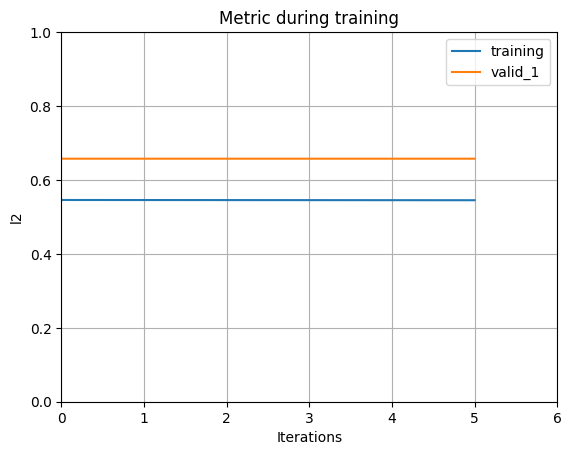

Best iteration: 220
0.657534843327539
Val Weighted R2 score is: 0.01063546915152136
this is date_id_df
(37752, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1310,0,0,3.09233,3.947917,-2.039851,3.169666,2.94385,2.268325,-1.529129,-0.481465,-0.901776,0.814455,11,7,76,-0.902997,0.703356,-0.41833,null,-0.3426,null,-1.274732,-1.442496,-0.113607,-0.015266,1.376615,1.162227,0.413889,-0.037794,1.360233,0.910005,-0.157103,-0.40842,-0.697285,-0.021017,null,null,2.345847,2.294756,2.048892,0.083659,0.111194,null,0.713058,null,null,-1.17661,null,-1.821182,0.634732,-0.297958,-0.486269,-0.141384,null,0.184951,null,null,-0.487494,null,-1.751658,1.203662,null,-0.920311,-0.976186,-0.012514,-0.352762,-0.154846,-0.384584,-0.978217,-2.108834,-0.880973,0.917556,-0.345644,-0.964848,0.335044,-0.420929,null,null,0.209208,0.143676,-0.162988,-0.195838,-1.916194,-0.274358,-0.1649,-0.529498,-1.595672,-2.203725,-0.337115,-1.252792,-1.416301,-0.159938
1310,0,1,3.303463,3.332037,-1.796796,2.920575,2.945678,2.360335,-3.144059,-0.701008,-1.124176,0.984618,11,7,76,-0.754562,-0.195079,-0.495837,null,-0.714844,null,-0.795689,-1.167416,-2.487363,0.206688,1.142116,1.574186,-0.724111,-0.720747,-0.361518,0.090137,1.480682,-0.587575,-0.576205,0.232752,null,null,-1.814959,-1.41005,0.188128,0.011557,-0.056573,null,0.778358,null,null,0.286527,null,-1.238524,1.462784,-0.048678,0.002878,0.030968,null,-0.817936,null,null,-0.029311,null,-2.958258,1.930793,null,0.005375,-0.010782,-0.012514,-0.470757,-0.20379,-0.250241,-1.377385,-1.583242,-1.03024,-0.037259,-0.500806,-1.102535,-0.434133,-0.76258,null,null,-0.317533,-0.302826,-0.266955,-0.311873,-0.193357,-0.021731,-0.156403,-0.001881,-0.461403,-0.19231,-0.087701,-0.812724,-0.055904,-0.082236
1310,0,2,1.535632,2.783569,-2.200702,3.208857,3.390831,2.665833,-1.901299,-0.393574,-0.855955,0.610737,81,2,59,-0.598471,1.597842,-0.323229,null,-0.165864,null,-1.245891,-1.52745,-0.061012,-0.212877,-0.95464,-0.727751,0.079178,-0.263998,0.624498,0.098708,-0.167526,-0.601112,-0.388473,-0.355472,null,null,2.439427,2.60873,1.346742,0.044808,0.854486,null,1.479332,null,null,-1.580186,null,-0.985923,0.883003,-1.503592,0.881588,0.354423,null,0.896982,null,null,-2.522546,null,-1.990732,0.414972,null,-1.977698,-1.091434,-0.012514,-0.339182,-0.10382,-0.288198,-1.623235,-2.488004,-0.855252,2.341681,-0.018818,-0.975623,0.210678,-0.651291,null,null,4.47041,2.734799,3.061898,3.828798,1.377281,-0.200228,0.015377,0.259832,0.396167,0.564876,-0.038602,0.848683,0.480582,-0.20943
1310,0,3,1.55146,3.163959,-2.492631,2.924488,2.925153,2.246993,-1.573423,-0.386361,-0.566398,0.574251,4,3,11,-1.007745,1.454056,-0.358592,null,-0.38375,null,-0.956821,-1.676278,-0.052652,0.047907,-0.80429,-0.92597,1.727

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1310,967,34,1.589468,2.924667,1.844055,2.948967,3.337523,0.848374,-0.243878,1.475726,-0.20399,1.126556,42,5,150,0.10502,0.032192,0.320201,-0.587056,-0.530839,-0.715583,1.690843,-1.813142,-0.247967,-0.230149,-0.189716,-0.644142,0.205461,-0.266434,-0.686746,0.9137,1.12963,-0.334892,-0.959747,-0.233961,2.506276,-0.515954,2.620112,2.822734,0.443746,1.741222,1.40313,-0.173156,0.304213,0.004548,-0.645495,0.482971,-0.579851,-0.713516,-1.132329,-0.167041,0.385814,-0.196478,-0.780526,-0.128998,-0.435472,-1.468265,0.983355,-0.25142,-0.785605,-1.587566,-0.294343,0.335704,-0.441505,-0.012514,-0.410381,-0.348883,-0.450404,1.810685,-1.425297,0.198304,-0.076875,0.2257,0.076988,0.203105,0.152943,0.086417,-0.050736,0.08341,-0.045003,0.202419,0.056363,-0.307458,2.062847,1.100402,3.55974,0.137986,0.115738,0.565908,-0.155414,-0.030624,-0.27503
1310,967,35,1.572976,3.679667,1.622938,2.648978,3.289969,0.738745,-0.119985,1.193742,-0.208522,1.151694,11,7,76,-0.756774,-0.238345,-0.795347,0.499982,0.65151,1.676665,0.301112,4.470308,0.358008,0.384472,-0.786518,1.134716,1.129364,1.626983,0.136478,-2.190993,-1.59559,2.230175,1.210876,0.593391,2.052751,0.459608,1.793208,2.432914,-0.283691,-0.330774,-0.31312,0.069581,-2.297126,-0.116339,-0.390388,-1.751566,-1.135313,1.046096,0.108548,0.095589,0.005055,0.076594,-1.6811,0.162689,-0.770816,-0.815519,-1.168556,-0.979795,0.458245,0.770027,-0.019072,-0.154906,-0.01446,-0.012514,0.0351,0.272606,0.195506,0.49892,3.659663,-0.586667,-0.218345,-0.622577,-0.952174,-0.324796,-0.831862,-0.377848,-0.3295,-0.19619,-0.260052,-0.251434,-0.240742,-0.017722,-0.193485,0.516767,-0.409673,-0.202929,-0.168613,-0.755112,-0.375626,-0.155269,-1.049539
1310,967,36,1.968782,3.21226,1.676554,2.788985,3.477035,0.577825,-0.13097,0.798682,-0.129325,1.525826,68,6,388,1.083812,0.853368,0.208248,-0.283851,-0.638188,-0.737757,3.189454,-0.873065,0.130433,0.455837,-0.305976,1.144656,1.853023,2.045636,-0.338782,-0.83491,-1.667237,0.657524,-0.084016,0.554633,1.745769,-0.424139,2.689052,2.200404,-1.414095,0.948227,1.020032,-0.466519,-0.186717,-0.41124,-0.055055,-0.97622,-1.206406,-0.945485,-1.703409,-0.381887,-1.009943,-0.398747,0.130009,0.519153,-0.928644,0.041143,-1.439951,-0.81234,-1.450539,-1.334642,-0.316738,-0.826626,-0.560538,-0.012514,-0.273722,-0.13407,-0.209711,3.340045,-0.848877,0.594937,1.024571,0.093522,0.710045,0.073547,0.276303,-0.395095,-0.417024,-0.227017,-0.407934,-0.273216,-0.482359,0.489704,1.346676,1.078151,0.701703,-0.229799,-0.067079,-1.061226,-0.382463,-0.12032,-0.686252
1310,967,37,0.909898,3.441534,1.28068

this is updated validation data
(14255736, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1311,0,0,2.690459,2.951235,-0.794353,2.704895,3.188548,2.462624,-0.604023,0.2753,0.002835,0.307357,11,7,76,-1.047239,0.880269,-0.256666,null,-0.253615,null,-1.380816,-1.275,-0.174387,-0.018763,1.333154,0.528257,0.313521,-0.066656,0.982734,0.618293,-0.156876,-0.458298,-0.505615,-0.018011,null,null,2.190701,2.283557,-1.249326,0.003522,0.001265,null,0.895803,null,null,0.135446,null,-1.129874,1.524208,0.194032,0.711585,0.192273,null,0.690257,null,null,-0.372963,null,-2.012978,1.778513,null,1.646493,0.278813,0.205428,-0.219003,-0.145981,-0.240145,-1.201939,-1.505606,-0.938795,0.219,-0.589065,-0.874992,1.33083,-0.24663,null,null,-0.188647,-0.224019,-0.332189,-0.329371,-1.052832,0.37444,0.259119,0.794464,-1.245598,-0.775719,-2.285934,-1.916194,-1.111666,-3.868173
1311,0,1,4.177297,3.144245,-0.316901,3.006691,3.071627,1.602744,-0.72921,0.277754,0.014902,0.4103,11,7,76,-1.061893,-0.248291,-0.904685,null,-0.394324,null,-1.308194,-1.087994,-1.961453,0.196216,1.867966,1.931267,-1.181319,-1.310534,-0.19943,0.024636,1.081988,-0.857222,-0.301984,0.182158,null,null,-1.580212,-1.279207,-0.052271,0.054765,-0.062442,null,-0.113655,null,null,-0.353126,null,-1.761045,1.44268,-0.002983,0.014544,-0.017686,null,-1.13579,null,null,-0.077091,null,-2.909256,1.570613,null,0.00855,-0.007692,0.205428,-0.407213,-0.202579,-0.41421,-1.817309,-1.910886,-1.109375,-0.22155,-0.553466,-1.230108,-0.478669,-0.577772,null,null,-0.240257,-0.31137,-0.209037,-0.347423,0.36929,0.230055,0.262077,0.154391,-0.050646,-0.218132,0.068351,-0.193357,-0.464173,-0.053291
1311,0,2,1.295268,3.48513,-0.661628,3.043607,3.016436,2.17376,-0.586515,0.225766,0.007157,0.354258,81,2,59,-0.764634,1.271707,-0.314603,null,-0.261984,null,-2.278331,-1.308959,-0.104375,-0.236802,-0.840164,-0.594973,0.069752,-0.539942,0.940314,0.098672,-0.126983,-0.521902,-0.347126,-0.199306,null,null,2.610993,2.455961,1.642141,-0.123476,-0.167554,null,1.623599,null,null,1.084393,null,-1.23471,2.180372,1.234812,4.355278,2.313701,null,2.157006,null,null,1.579779,null,-0.028287,3.200877,null,6.337735,2.021351,0.205428,-0.167564,-0.329213,-0.355938,-1.829381,-2.235332,-0.916692,0.031239,-0.632219,-0.881615,2.00664,0.050336,null,null,1.00953,1.374385,0.046148,0.066794,-1.227964,-0.229046,-0.741763,-0.464284,1.042963,-0.389432,1.471351,1.377281,-0.101275,2.485577
1311,0,3,1.538504,3.674636,-0.129901,2.652987,3.551991,1.973527,-0.515821,0.174391,0.002453,0.259871,4,3,11,-0.967393,0.786891,-0.236718,null,-0.289853,null,-1.455255,-1.873743,-0.068849,0.074466,-0.53122,-0.872897,1.10836,2.032745,-0.367808,-

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1698,967,34,3.242493,2.52516,-0.721981,2.544025,2.477615,0.417557,0.785812,1.117796,2.199436,0.415427,42,5,150,0.804403,1.157257,1.031543,-0.671189,-0.3286,-0.486132,1.730176,-0.006173,-0.001144,-0.213062,0.932618,1.367338,-0.238197,-0.692615,-0.121163,1.090798,1.444294,-0.675626,-1.013264,-0.242888,3.427639,-0.958278,3.139836,3.416278,-1.655316,-0.59944,-0.932876,2.493458,0.969462,1.102016,0.158982,-0.496177,0.036177,1.309866,0.828025,1.577955,1.040802,1.255398,2.577441,0.057455,0.953005,1.377051,-0.396358,0.520262,1.179617,1.127657,2.231928,0.614652,2.412886,-1.101531,-0.384833,-0.275818,-0.40804,2.427115,-0.108427,0.739734,0.830205,0.366287,1.33325,1.075499,1.798264,-0.183443,-0.190222,0.234211,0.347142,-0.044463,0.016936,-0.132337,0.501321,0.905332,-0.819582,-0.564046,-0.223018,-0.283954,-0.045938,0.009797,-0.102538
1698,967,35,1.079139,1.857906,-0.790646,2.745439,2.339877,0.845065,0.65137,1.180301,1.966379,0.321543,25,7,195,-0.075294,-0.152726,-0.20417,-0.421137,0.21708,-0.258775,1.874978,0.19988,-0.199219,-0.125619,-1.004547,-0.051933,0.450905,0.009246,0.164127,-0.939974,-1.143421,-0.320071,-0.379835,-0.142429,3.862469,-1.451786,3.477489,2.861663,0.763459,0.075972,-0.119677,0.626035,0.148815,0.653281,0.059313,-0.845099,0.098528,0.409564,-0.675728,-0.011334,0.930534,0.83198,0.808955,0.219276,-0.315776,0.687755,-1.189577,0.180146,-0.175486,-1.60435,-0.209283,0.249847,0.288816,-1.101531,-0.343868,-0.253991,-0.278832,2.050639,-0.059506,-0.029396,-0.101381,-0.187759,-0.180839,-0.0861,-0.153405,-0.196077,-0.175292,1.04578,0.739733,0.03372,0.05086,-0.249584,-1.113053,0.69719,-1.619031,-1.222743,-0.706082,-0.291133,0.167733,0.099704,0.32461
1698,967,36,1.033172,2.515527,-0.672298,2.28925,2.521592,0.255077,0.919892,1.172018,2.180496,0.24846,49,7,297,1.026715,-0.096892,0.224309,-0.528109,-0.704952,-0.704818,2.312482,0.32804,-0.108193,null,-0.945684,-0.244173,0.205989,-0.357343,null,null,-1.11075,-0.580242,-0.400568,null,2.397877,-0.637258,3.260638,3.046786,0.440965,0.234842,-0.17558,1.022406,-0.500069,2.071033,0.413488,-0.450016,-0.156616,-0.253755,-0.769588,0.066086,0.047826,1.713707,0.772772,-0.549192,1.338474,0.933568,0.032978,-0.519118,-0.290343,-0.806786,0.106295,0.183461,1.830421,-1.101531,-0.341991,-0.249132,-0.34365,2.251358,0.601888,1.035051,-0.283241,0.107244,0.86016,0.024223,0.374852,-0.220933,-0.161584,0.032771,0.036888,0.168908,0.152333,-0.065355,-1.019353,-0.460962,-2.026678,-0.848606,-0.305448,-1.256913,-0.109359,-0.027474,-0.253956
1698,967,37,1.243116,2.663298,-0.889112,2.313155,3.101428,0.324454,

<Figure size 640x480 with 0 Axes>

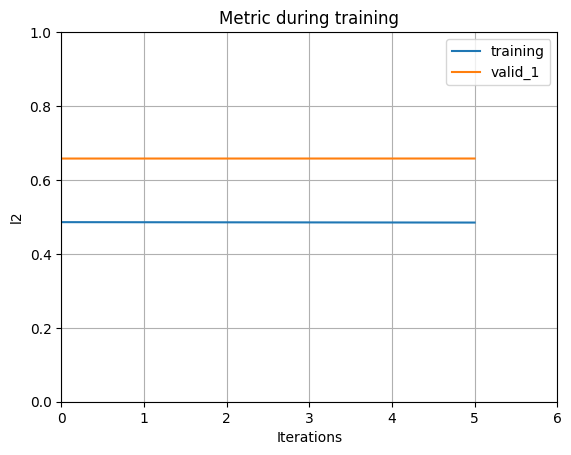

Best iteration: 221
0.657959454233267
Val Weighted R2 score is: 0.010646297774146496
this is date_id_df
(37752, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1311,0,0,2.690459,2.951235,-0.794353,2.704895,3.188548,2.462624,-0.604023,0.2753,0.002835,0.307357,11,7,76,-1.047239,0.880269,-0.256666,null,-0.253615,null,-1.380816,-1.275,-0.174387,-0.018763,1.333154,0.528257,0.313521,-0.066656,0.982734,0.618293,-0.156876,-0.458298,-0.505615,-0.018011,null,null,2.190701,2.283557,-1.249326,0.003522,0.001265,null,0.895803,null,null,0.135446,null,-1.129874,1.524208,0.194032,0.711585,0.192273,null,0.690257,null,null,-0.372963,null,-2.012978,1.778513,null,1.646493,0.278813,0.205428,-0.219003,-0.145981,-0.240145,-1.201939,-1.505606,-0.938795,0.219,-0.589065,-0.874992,1.33083,-0.24663,null,null,-0.188647,-0.224019,-0.332189,-0.329371,-1.052832,0.37444,0.259119,0.794464,-1.245598,-0.775719,-2.285934,-1.916194,-1.111666,-3.868173
1311,0,1,4.177297,3.144245,-0.316901,3.006691,3.071627,1.602744,-0.72921,0.277754,0.014902,0.4103,11,7,76,-1.061893,-0.248291,-0.904685,null,-0.394324,null,-1.308194,-1.087994,-1.961453,0.196216,1.867966,1.931267,-1.181319,-1.310534,-0.19943,0.024636,1.081988,-0.857222,-0.301984,0.182158,null,null,-1.580212,-1.279207,-0.052271,0.054765,-0.062442,null,-0.113655,null,null,-0.353126,null,-1.761045,1.44268,-0.002983,0.014544,-0.017686,null,-1.13579,null,null,-0.077091,null,-2.909256,1.570613,null,0.00855,-0.007692,0.205428,-0.407213,-0.202579,-0.41421,-1.817309,-1.910886,-1.109375,-0.22155,-0.553466,-1.230108,-0.478669,-0.577772,null,null,-0.240257,-0.31137,-0.209037,-0.347423,0.36929,0.230055,0.262077,0.154391,-0.050646,-0.218132,0.068351,-0.193357,-0.464173,-0.053291
1311,0,2,1.295268,3.48513,-0.661628,3.043607,3.016436,2.17376,-0.586515,0.225766,0.007157,0.354258,81,2,59,-0.764634,1.271707,-0.314603,null,-0.261984,null,-2.278331,-1.308959,-0.104375,-0.236802,-0.840164,-0.594973,0.069752,-0.539942,0.940314,0.098672,-0.126983,-0.521902,-0.347126,-0.199306,null,null,2.610993,2.455961,1.642141,-0.123476,-0.167554,null,1.623599,null,null,1.084393,null,-1.23471,2.180372,1.234812,4.355278,2.313701,null,2.157006,null,null,1.579779,null,-0.028287,3.200877,null,6.337735,2.021351,0.205428,-0.167564,-0.329213,-0.355938,-1.829381,-2.235332,-0.916692,0.031239,-0.632219,-0.881615,2.00664,0.050336,null,null,1.00953,1.374385,0.046148,0.066794,-1.227964,-0.229046,-0.741763,-0.464284,1.042963,-0.389432,1.471351,1.377281,-0.101275,2.485577
1311,0,3,1.538504,3.674636,-0.129901,2.652987,3.551991,1.973527,-0.515821,0.174391,0.002453,0.259871,4,3,11,-0.967393,0.786891,-0.236718,null,-0.289853,null,-1.455255,-1.873743,-0.068849,0.074466,-0.53122,-0.872897,1.10836,2.032745,-0.367808,-

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1311,967,34,1.918056,2.669483,-2.608434,3.047531,3.174924,-2.459605,-1.433641,-0.814524,-0.330545,-0.38643,42,5,150,1.304302,0.605371,1.310565,-0.715202,-0.682664,-0.825712,-1.980208,1.0069,-0.175697,-0.173804,-0.236068,-0.447038,0.28727,-0.239235,-1.232379,0.876545,0.781954,-0.752904,-1.004247,-0.222712,2.507307,-0.604427,2.634296,2.441452,-0.560638,-2.300306,-1.739797,0.040589,0.516855,1.312068,0.197406,-0.575617,-0.140891,1.856139,0.65644,0.118284,0.053972,0.067259,0.740534,0.021226,-0.231046,1.326385,0.547211,0.809132,2.159825,1.430296,0.416489,0.460378,0.204678,0.205428,-0.364397,-0.27194,-0.270346,-1.568218,0.951103,0.981416,0.273653,0.800232,0.525651,1.036482,1.449396,0.08294,0.272665,-0.211079,-0.130431,-0.206103,-0.011414,-0.47515,0.427972,0.03044,1.534318,0.514324,0.358827,0.479998,-0.307458,-0.129767,-0.628101
1311,967,35,1.557597,3.215844,-2.908392,3.246284,3.201645,-1.510761,-1.040946,-0.660656,-0.232822,-0.519866,11,7,76,-0.760357,-0.463741,-0.782361,0.696154,0.094319,0.588034,-1.15238,1.911608,0.244062,0.377461,-0.753498,1.644879,0.925322,1.594398,0.077741,-1.330306,-1.84925,2.301522,1.31262,0.452252,1.935021,-1.325433,3.155649,2.104048,0.839186,-1.224755,-1.430411,-0.178526,1.649211,0.995678,-1.050289,1.755265,-1.164606,0.998795,-0.648033,-0.444006,-0.098665,-0.039381,-0.831356,0.316055,-0.058865,-0.318787,1.783477,-0.68411,0.745023,-0.519861,-0.313552,-0.437938,-0.288588,0.205428,0.003318,0.575341,0.286714,-1.098174,1.316975,-0.664438,-0.221591,-0.561882,-0.917093,-0.348124,-0.582756,-0.448044,-0.181599,-0.261507,-0.174053,-0.260054,-0.167749,-0.314387,-0.230196,-0.274765,-1.136484,0.336616,0.159964,-0.027759,-0.017722,0.016958,-0.048388
1311,967,36,1.91594,2.878536,-2.941259,3.14187,3.288188,-2.260327,-1.123442,-0.510151,-0.21602,-0.369862,68,6,388,0.204799,0.556501,0.232921,-0.242959,-0.032711,-0.126205,-0.813484,1.988823,0.128747,0.53525,-0.238025,1.018263,1.921422,2.67011,-0.403016,-1.021988,-1.854891,0.527768,-0.195865,0.349779,2.23853,-1.101394,2.197494,2.395581,-1.184974,-2.258664,-1.657443,1.709064,0.501842,1.140069,0.499607,-0.762244,-0.298922,1.863848,-0.335571,0.374783,1.892447,1.006928,1.094962,1.091188,0.838643,0.072187,0.09266,-0.206793,1.950165,0.004847,0.450297,0.467467,0.904373,0.205428,-0.315923,0.179528,-0.10844,-2.594086,1.952001,0.063484,-0.18161,-0.204242,0.335673,1.707756,0.919454,-0.305613,-0.129575,-0.246948,-0.081804,-0.253961,-0.071605,-0.158839,1.054878,-0.010566,0.152332,0.793555,0.598594,1.000275,0.489704,0.233628,0.845882
1311,967,37,0.885817,3.331009,-2.7716,3.0

this is updated validation data
(14217984, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1312,0,0,3.567853,2.742608,2.387346,3.105009,2.862068,-3.111939,4.102027,-1.092777,0.759446,-1.528181,11,7,76,-0.807556,1.190694,-0.180114,null,-0.167959,null,-1.664987,-1.571546,-0.192222,-0.008672,1.227476,0.917005,0.259613,-0.174353,0.975036,0.270552,-0.169818,-0.509805,-0.559895,-0.017565,null,null,1.758014,2.269543,1.185675,-0.06776,-0.539308,null,0.481246,null,null,-0.705352,null,-1.077528,1.543996,1.446725,1.119834,0.805392,null,2.401803,null,null,-0.65832,null,-0.706845,1.204403,null,2.087683,1.631324,-0.362604,-0.445856,-0.240922,-0.308046,-1.64841,-1.521504,-0.634907,1.585049,-0.156136,-0.704244,0.407783,-0.636935,null,null,0.1445,0.183888,-0.173722,-0.153906,1.307348,0.027521,-0.033608,-0.435124,-1.012395,-0.263256,-0.360545,-1.052832,-0.330303,-0.554832
1312,0,1,2.450919,3.412268,2.66057,3.258972,3.156548,-3.223361,5.260575,-1.052536,1.015134,-2.185622,11,7,76,-0.73079,5.965022,0.780806,null,-0.485976,null,-2.000226,-1.325881,-2.625947,0.033884,0.991949,1.987381,-0.998159,-1.322395,-0.375365,0.099936,0.495851,-0.584832,-0.425745,0.036189,null,null,-1.908253,-1.707123,0.036207,0.023904,-0.035697,null,0.654735,null,null,-0.323709,null,-1.173128,1.510791,0.304346,0.306584,0.212334,null,0.769187,null,null,1.127763,null,-1.521461,2.774277,null,0.525328,0.301997,-0.362604,-0.286826,-0.285016,-0.485559,-1.654542,-1.825009,-0.775594,-0.330437,-0.531882,-0.046785,9.270477,2.163628,null,null,-0.164685,-0.2504,-0.149865,-0.241378,1.801614,-0.026038,0.326513,0.063442,0.261694,0.689213,-0.172746,0.36929,0.237574,-0.388905
1312,0,2,1.626604,2.969709,2.749326,3.290771,2.975981,-2.515666,2.484464,-0.856663,0.919346,-0.687278,81,2,59,-0.764317,2.245163,-0.23903,null,0.518717,null,-1.197438,-1.359825,-0.317518,-0.351569,-0.926256,-0.42646,0.231896,-0.442013,0.548348,0.104834,-0.129295,-0.505672,-0.620273,-0.4011,null,null,1.690108,1.570057,2.629494,-0.071938,-0.705962,null,0.191164,null,null,-1.02967,null,-1.086807,1.088828,1.297491,-0.988644,0.972182,null,1.472977,null,null,-1.41809,null,-0.927357,0.573848,null,2.208109,1.206618,-0.362604,0.178115,-0.100308,-0.119639,-1.349882,-0.987059,-0.776382,1.116655,-0.34634,-0.528612,2.97394,0.001181,null,null,3.032856,2.605321,0.374405,0.472799,-0.687293,0.041396,0.217458,-0.181715,-0.770896,-0.880808,0.120858,-1.227964,-0.963045,0.357122
1312,0,3,1.535033,2.81251,2.519864,3.645242,3.670204,-2.956455,1.458662,-0.638172,0.933148,-1.221634,4,3,11,-0.739545,1.359227,-0.168942,null,0.880073,null,-2.160293,-1.654243,-0.194716,0.134132,-0.894097,-0.847672,1.113799,1.762403,-0.312

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1698,967,34,3.242493,2.52516,-0.721981,2.544025,2.477615,0.417557,0.785812,1.117796,2.199436,0.415427,42,5,150,0.804403,1.157257,1.031543,-0.671189,-0.3286,-0.486132,1.730176,-0.006173,-0.001144,-0.213062,0.932618,1.367338,-0.238197,-0.692615,-0.121163,1.090798,1.444294,-0.675626,-1.013264,-0.242888,3.427639,-0.958278,3.139836,3.416278,-1.655316,-0.59944,-0.932876,2.493458,0.969462,1.102016,0.158982,-0.496177,0.036177,1.309866,0.828025,1.577955,1.040802,1.255398,2.577441,0.057455,0.953005,1.377051,-0.396358,0.520262,1.179617,1.127657,2.231928,0.614652,2.412886,-1.101531,-0.384833,-0.275818,-0.40804,2.427115,-0.108427,0.739734,0.830205,0.366287,1.33325,1.075499,1.798264,-0.183443,-0.190222,0.234211,0.347142,-0.044463,0.016936,-0.132337,0.501321,0.905332,-0.819582,-0.564046,-0.223018,-0.283954,-0.045938,0.009797,-0.102538
1698,967,35,1.079139,1.857906,-0.790646,2.745439,2.339877,0.845065,0.65137,1.180301,1.966379,0.321543,25,7,195,-0.075294,-0.152726,-0.20417,-0.421137,0.21708,-0.258775,1.874978,0.19988,-0.199219,-0.125619,-1.004547,-0.051933,0.450905,0.009246,0.164127,-0.939974,-1.143421,-0.320071,-0.379835,-0.142429,3.862469,-1.451786,3.477489,2.861663,0.763459,0.075972,-0.119677,0.626035,0.148815,0.653281,0.059313,-0.845099,0.098528,0.409564,-0.675728,-0.011334,0.930534,0.83198,0.808955,0.219276,-0.315776,0.687755,-1.189577,0.180146,-0.175486,-1.60435,-0.209283,0.249847,0.288816,-1.101531,-0.343868,-0.253991,-0.278832,2.050639,-0.059506,-0.029396,-0.101381,-0.187759,-0.180839,-0.0861,-0.153405,-0.196077,-0.175292,1.04578,0.739733,0.03372,0.05086,-0.249584,-1.113053,0.69719,-1.619031,-1.222743,-0.706082,-0.291133,0.167733,0.099704,0.32461
1698,967,36,1.033172,2.515527,-0.672298,2.28925,2.521592,0.255077,0.919892,1.172018,2.180496,0.24846,49,7,297,1.026715,-0.096892,0.224309,-0.528109,-0.704952,-0.704818,2.312482,0.32804,-0.108193,null,-0.945684,-0.244173,0.205989,-0.357343,null,null,-1.11075,-0.580242,-0.400568,null,2.397877,-0.637258,3.260638,3.046786,0.440965,0.234842,-0.17558,1.022406,-0.500069,2.071033,0.413488,-0.450016,-0.156616,-0.253755,-0.769588,0.066086,0.047826,1.713707,0.772772,-0.549192,1.338474,0.933568,0.032978,-0.519118,-0.290343,-0.806786,0.106295,0.183461,1.830421,-1.101531,-0.341991,-0.249132,-0.34365,2.251358,0.601888,1.035051,-0.283241,0.107244,0.86016,0.024223,0.374852,-0.220933,-0.161584,0.032771,0.036888,0.168908,0.152333,-0.065355,-1.019353,-0.460962,-2.026678,-0.848606,-0.305448,-1.256913,-0.109359,-0.027474,-0.253956
1698,967,37,1.243116,2.663298,-0.889112,2.313155,3.101428,0.324454,

<Figure size 640x480 with 0 Axes>

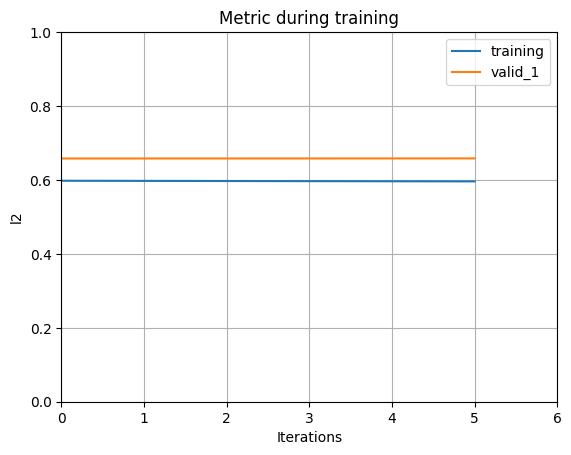

Best iteration: 222
0.6581130402075728
Val Weighted R2 score is: 0.010628061520070342
this is date_id_df
(37752, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1312,0,0,3.567853,2.742608,2.387346,3.105009,2.862068,-3.111939,4.102027,-1.092777,0.759446,-1.528181,11,7,76,-0.807556,1.190694,-0.180114,null,-0.167959,null,-1.664987,-1.571546,-0.192222,-0.008672,1.227476,0.917005,0.259613,-0.174353,0.975036,0.270552,-0.169818,-0.509805,-0.559895,-0.017565,null,null,1.758014,2.269543,1.185675,-0.06776,-0.539308,null,0.481246,null,null,-0.705352,null,-1.077528,1.543996,1.446725,1.119834,0.805392,null,2.401803,null,null,-0.65832,null,-0.706845,1.204403,null,2.087683,1.631324,-0.362604,-0.445856,-0.240922,-0.308046,-1.64841,-1.521504,-0.634907,1.585049,-0.156136,-0.704244,0.407783,-0.636935,null,null,0.1445,0.183888,-0.173722,-0.153906,1.307348,0.027521,-0.033608,-0.435124,-1.012395,-0.263256,-0.360545,-1.052832,-0.330303,-0.554832
1312,0,1,2.450919,3.412268,2.66057,3.258972,3.156548,-3.223361,5.260575,-1.052536,1.015134,-2.185622,11,7,76,-0.73079,5.965022,0.780806,null,-0.485976,null,-2.000226,-1.325881,-2.625947,0.033884,0.991949,1.987381,-0.998159,-1.322395,-0.375365,0.099936,0.495851,-0.584832,-0.425745,0.036189,null,null,-1.908253,-1.707123,0.036207,0.023904,-0.035697,null,0.654735,null,null,-0.323709,null,-1.173128,1.510791,0.304346,0.306584,0.212334,null,0.769187,null,null,1.127763,null,-1.521461,2.774277,null,0.525328,0.301997,-0.362604,-0.286826,-0.285016,-0.485559,-1.654542,-1.825009,-0.775594,-0.330437,-0.531882,-0.046785,9.270477,2.163628,null,null,-0.164685,-0.2504,-0.149865,-0.241378,1.801614,-0.026038,0.326513,0.063442,0.261694,0.689213,-0.172746,0.36929,0.237574,-0.388905
1312,0,2,1.626604,2.969709,2.749326,3.290771,2.975981,-2.515666,2.484464,-0.856663,0.919346,-0.687278,81,2,59,-0.764317,2.245163,-0.23903,null,0.518717,null,-1.197438,-1.359825,-0.317518,-0.351569,-0.926256,-0.42646,0.231896,-0.442013,0.548348,0.104834,-0.129295,-0.505672,-0.620273,-0.4011,null,null,1.690108,1.570057,2.629494,-0.071938,-0.705962,null,0.191164,null,null,-1.02967,null,-1.086807,1.088828,1.297491,-0.988644,0.972182,null,1.472977,null,null,-1.41809,null,-0.927357,0.573848,null,2.208109,1.206618,-0.362604,0.178115,-0.100308,-0.119639,-1.349882,-0.987059,-0.776382,1.116655,-0.34634,-0.528612,2.97394,0.001181,null,null,3.032856,2.605321,0.374405,0.472799,-0.687293,0.041396,0.217458,-0.181715,-0.770896,-0.880808,0.120858,-1.227964,-0.963045,0.357122
1312,0,3,1.535033,2.81251,2.519864,3.645242,3.670204,-2.956455,1.458662,-0.638172,0.933148,-1.221634,4,3,11,-0.739545,1.359227,-0.168942,null,0.880073,null,-2.160293,-1.654243,-0.194716,0.134132,-0.894097,-0.847672,1.113799,1.762403,-0.312

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1312,967,34,1.945788,3.42352,-2.31707,3.012992,3.518731,-2.357648,-1.279468,-0.159447,-0.700738,-2.620942,42,5,150,0.562681,0.230447,0.143519,-0.630013,-0.412941,-0.51165,-0.551585,1.881634,-0.309548,-0.306217,-0.234387,-0.422761,0.136083,-0.085451,-0.904698,0.685334,1.17336,-0.775981,-0.606826,-0.253,1.937965,-1.153275,2.155926,1.728804,0.120114,-0.428577,-2.059407,0.568789,0.95851,0.698774,-0.345056,-0.734763,0.734603,0.466653,-1.063456,-0.472362,0.685373,0.347705,0.420103,-0.345801,0.248782,0.069202,-1.02357,-0.510723,0.531769,-0.808548,-0.405186,0.52632,0.313638,-0.362604,-0.637498,-0.293416,-0.416879,-1.42595,1.761707,0.454192,0.489268,0.177502,0.604264,0.000843,0.13435,0.637305,0.589829,1.073493,1.158635,0.512956,0.844921,-0.033043,0.736051,0.404673,-1.542863,-0.010058,-0.006336,-1.234078,-0.47515,-0.198418,-0.679159
1312,967,35,1.367743,3.315417,-2.815061,2.534449,3.739593,-1.841987,-1.638427,-0.044844,-0.580158,-2.116013,11,7,76,-0.82558,-0.29861,-0.665065,1.117573,1.555432,1.480074,-0.096183,0.758183,0.393773,0.276465,-0.724795,1.440417,0.800196,1.931979,0.113751,-1.892274,-2.550588,2.66993,1.47071,0.240175,1.946406,-0.954309,2.895627,2.06228,-1.545903,-0.744159,-1.070921,0.643896,1.342995,0.536328,-0.913994,1.506491,-0.305791,0.473715,-1.640267,-0.851385,-0.163,-0.175776,0.977302,1.166851,0.344479,-0.944173,-2.237078,-0.599451,0.36502,-0.806084,-0.735422,0.280038,0.141592,-0.362604,-0.117172,0.159305,-0.15329,-0.125209,-0.265712,-0.771566,-0.405034,-0.307633,-0.825126,0.013416,-0.379399,-0.256101,-0.167303,-0.194151,-0.203739,-0.328541,-0.147686,0.357026,0.35243,0.391057,-0.447367,0.264385,0.131774,-0.044611,-0.314387,-0.092647,-0.333338
1312,967,36,1.961461,3.127471,-2.275079,3.116349,3.245807,-2.127767,-1.356424,-0.138911,-0.798742,-1.38315,68,6,388,0.413526,-0.005025,0.131206,-0.13027,-0.130891,-0.027299,1.310744,0.706057,-0.024652,0.427248,-0.280724,1.305852,2.456339,1.997882,-0.457137,-1.393454,-1.256553,0.451885,-0.067549,0.438775,1.129441,-0.86179,1.528528,0.971466,2.321518,0.28484,-0.127779,-0.424389,1.012891,-0.126162,-0.427993,0.516344,-0.156606,-1.028499,-1.761539,-0.898701,-0.003607,-0.395639,-1.607418,0.576609,-0.394325,-0.519056,-0.523971,-1.057226,-0.508163,-0.815309,-1.396064,-0.021124,-0.833905,-0.362604,-0.320335,-0.101369,-0.25763,1.266063,0.981174,0.261945,-0.191128,0.016323,0.360627,0.308948,0.451835,-0.332794,-0.345753,-0.246535,-0.327607,-0.395438,-0.359722,0.028172,1.195238,1.04328,-1.714931,0.020315,0.01519,-0.32595,-0.158839,-0.054248,-0.468524
1312,967,37,0.624415,3.3664,-2

this is updated validation data
(14180232, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1313,0,0,2.956696,3.136239,-0.600576,3.222824,2.81342,3.195124,-3.111375,-1.449581,-1.325028,0.58043,11,7,76,-0.857723,0.206084,-0.552813,null,-0.256359,null,-1.074837,-1.080971,-0.334973,-0.016245,1.21021,1.382135,0.335519,-0.128056,0.688639,0.458428,-0.105129,-0.375769,-0.423314,-0.011986,null,null,0.885382,1.191447,-2.062944,0.08115,0.32904,null,0.796226,null,null,0.78587,null,-1.439222,1.459621,-0.413373,0.141788,-0.550501,null,0.355595,null,null,-0.678848,null,-1.63861,1.747029,null,0.378018,0.060179,0.461533,-0.412037,-0.222364,-0.429095,-1.800354,-1.30683,-0.624109,-0.10718,-0.672555,-0.943954,0.658156,-0.457938,null,null,-0.067714,-0.075363,-0.173421,-0.299122,-2.16876,0.179471,0.155475,-0.233786,0.788351,0.028597,1.143972,1.307348,-0.1455,2.722924
1313,0,1,2.960403,3.329476,-0.827817,3.292433,3.07269,3.05877,-2.417487,-1.995793,-2.059393,0.927093,11,7,76,-0.906113,3.496179,0.328716,null,-0.70718,null,-1.425213,-0.528518,-1.381911,-0.054154,0.640855,2.174337,-1.199899,-0.786385,-0.444759,0.115665,1.365546,-0.645914,-0.715307,-0.032143,null,null,-2.021955,-1.625314,-0.056866,0.038191,-0.050489,null,0.949546,null,null,0.080665,null,-1.946917,1.394546,0.25433,0.114309,0.081103,null,0.809487,null,null,1.072457,null,-1.876545,2.486416,null,0.098332,0.067381,0.461533,-0.240157,-0.294656,-0.339632,-1.292103,-1.288416,-0.880841,-0.144574,-0.673511,-0.227323,6.448212,1.492757,null,null,-0.298875,-0.316417,-0.280162,-0.297071,0.186977,-0.445458,-0.17467,-0.286555,0.879149,0.221449,-0.127944,1.801614,0.545469,0.118646
1313,0,2,1.597048,3.007086,-0.776427,3.252562,3.158968,2.677749,-1.779856,-0.827933,-1.06941,0.49855,81,2,59,-0.747297,0.158103,-0.419804,null,-0.296171,null,-1.491099,-1.816621,-0.233421,-0.211878,-0.737854,-0.378969,0.083759,-0.544962,0.771994,0.122298,-0.059334,-0.388463,-0.683481,-0.348239,null,null,1.256253,1.849634,2.224114,0.167255,0.439676,null,0.731918,null,null,-1.063128,null,-1.444868,1.356656,-1.822408,0.391243,0.555138,null,-0.613043,null,null,-0.934979,null,-2.317331,0.907612,null,-0.862681,-0.302088,0.461533,0.289226,-0.172809,-0.035182,-1.582551,-1.964055,-0.86199,0.047857,-0.557851,-1.111833,0.224661,-0.383525,null,null,-0.214809,-0.184616,-0.337016,-0.371883,-0.296069,-0.556977,-0.106317,-0.943128,-0.753338,0.505058,0.426844,-0.687293,0.681396,0.932071
1313,0,3,1.196872,3.070146,-0.521015,2.973302,3.397895,3.133447,-1.963876,-1.191502,-0.691217,0.435799,4,3,11,-1.00792,3.730613,0.247897,null,0.412038,null,-1.501258,-1.597784,-0.003125,0.09183,-0.53777,-0.727929,0.922933,2.321275,-0

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1698,967,34,3.242493,2.52516,-0.721981,2.544025,2.477615,0.417557,0.785812,1.117796,2.199436,0.415427,42,5,150,0.804403,1.157257,1.031543,-0.671189,-0.3286,-0.486132,1.730176,-0.006173,-0.001144,-0.213062,0.932618,1.367338,-0.238197,-0.692615,-0.121163,1.090798,1.444294,-0.675626,-1.013264,-0.242888,3.427639,-0.958278,3.139836,3.416278,-1.655316,-0.59944,-0.932876,2.493458,0.969462,1.102016,0.158982,-0.496177,0.036177,1.309866,0.828025,1.577955,1.040802,1.255398,2.577441,0.057455,0.953005,1.377051,-0.396358,0.520262,1.179617,1.127657,2.231928,0.614652,2.412886,-1.101531,-0.384833,-0.275818,-0.40804,2.427115,-0.108427,0.739734,0.830205,0.366287,1.33325,1.075499,1.798264,-0.183443,-0.190222,0.234211,0.347142,-0.044463,0.016936,-0.132337,0.501321,0.905332,-0.819582,-0.564046,-0.223018,-0.283954,-0.045938,0.009797,-0.102538
1698,967,35,1.079139,1.857906,-0.790646,2.745439,2.339877,0.845065,0.65137,1.180301,1.966379,0.321543,25,7,195,-0.075294,-0.152726,-0.20417,-0.421137,0.21708,-0.258775,1.874978,0.19988,-0.199219,-0.125619,-1.004547,-0.051933,0.450905,0.009246,0.164127,-0.939974,-1.143421,-0.320071,-0.379835,-0.142429,3.862469,-1.451786,3.477489,2.861663,0.763459,0.075972,-0.119677,0.626035,0.148815,0.653281,0.059313,-0.845099,0.098528,0.409564,-0.675728,-0.011334,0.930534,0.83198,0.808955,0.219276,-0.315776,0.687755,-1.189577,0.180146,-0.175486,-1.60435,-0.209283,0.249847,0.288816,-1.101531,-0.343868,-0.253991,-0.278832,2.050639,-0.059506,-0.029396,-0.101381,-0.187759,-0.180839,-0.0861,-0.153405,-0.196077,-0.175292,1.04578,0.739733,0.03372,0.05086,-0.249584,-1.113053,0.69719,-1.619031,-1.222743,-0.706082,-0.291133,0.167733,0.099704,0.32461
1698,967,36,1.033172,2.515527,-0.672298,2.28925,2.521592,0.255077,0.919892,1.172018,2.180496,0.24846,49,7,297,1.026715,-0.096892,0.224309,-0.528109,-0.704952,-0.704818,2.312482,0.32804,-0.108193,null,-0.945684,-0.244173,0.205989,-0.357343,null,null,-1.11075,-0.580242,-0.400568,null,2.397877,-0.637258,3.260638,3.046786,0.440965,0.234842,-0.17558,1.022406,-0.500069,2.071033,0.413488,-0.450016,-0.156616,-0.253755,-0.769588,0.066086,0.047826,1.713707,0.772772,-0.549192,1.338474,0.933568,0.032978,-0.519118,-0.290343,-0.806786,0.106295,0.183461,1.830421,-1.101531,-0.341991,-0.249132,-0.34365,2.251358,0.601888,1.035051,-0.283241,0.107244,0.86016,0.024223,0.374852,-0.220933,-0.161584,0.032771,0.036888,0.168908,0.152333,-0.065355,-1.019353,-0.460962,-2.026678,-0.848606,-0.305448,-1.256913,-0.109359,-0.027474,-0.253956
1698,967,37,1.243116,2.663298,-0.889112,2.313155,3.101428,0.324454,

<Figure size 640x480 with 0 Axes>

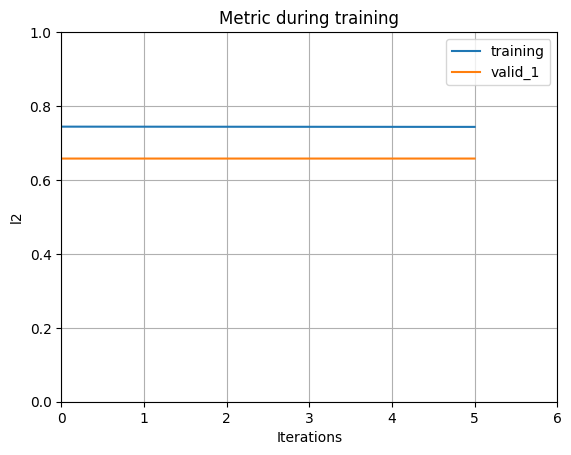

Best iteration: 223
0.657913674381948
Val Weighted R2 score is: 0.010600669413381225
this is date_id_df
(37752, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1313,0,0,2.956696,3.136239,-0.600576,3.222824,2.81342,3.195124,-3.111375,-1.449581,-1.325028,0.58043,11,7,76,-0.857723,0.206084,-0.552813,null,-0.256359,null,-1.074837,-1.080971,-0.334973,-0.016245,1.21021,1.382135,0.335519,-0.128056,0.688639,0.458428,-0.105129,-0.375769,-0.423314,-0.011986,null,null,0.885382,1.191447,-2.062944,0.08115,0.32904,null,0.796226,null,null,0.78587,null,-1.439222,1.459621,-0.413373,0.141788,-0.550501,null,0.355595,null,null,-0.678848,null,-1.63861,1.747029,null,0.378018,0.060179,0.461533,-0.412037,-0.222364,-0.429095,-1.800354,-1.30683,-0.624109,-0.10718,-0.672555,-0.943954,0.658156,-0.457938,null,null,-0.067714,-0.075363,-0.173421,-0.299122,-2.16876,0.179471,0.155475,-0.233786,0.788351,0.028597,1.143972,1.307348,-0.1455,2.722924
1313,0,1,2.960403,3.329476,-0.827817,3.292433,3.07269,3.05877,-2.417487,-1.995793,-2.059393,0.927093,11,7,76,-0.906113,3.496179,0.328716,null,-0.70718,null,-1.425213,-0.528518,-1.381911,-0.054154,0.640855,2.174337,-1.199899,-0.786385,-0.444759,0.115665,1.365546,-0.645914,-0.715307,-0.032143,null,null,-2.021955,-1.625314,-0.056866,0.038191,-0.050489,null,0.949546,null,null,0.080665,null,-1.946917,1.394546,0.25433,0.114309,0.081103,null,0.809487,null,null,1.072457,null,-1.876545,2.486416,null,0.098332,0.067381,0.461533,-0.240157,-0.294656,-0.339632,-1.292103,-1.288416,-0.880841,-0.144574,-0.673511,-0.227323,6.448212,1.492757,null,null,-0.298875,-0.316417,-0.280162,-0.297071,0.186977,-0.445458,-0.17467,-0.286555,0.879149,0.221449,-0.127944,1.801614,0.545469,0.118646
1313,0,2,1.597048,3.007086,-0.776427,3.252562,3.158968,2.677749,-1.779856,-0.827933,-1.06941,0.49855,81,2,59,-0.747297,0.158103,-0.419804,null,-0.296171,null,-1.491099,-1.816621,-0.233421,-0.211878,-0.737854,-0.378969,0.083759,-0.544962,0.771994,0.122298,-0.059334,-0.388463,-0.683481,-0.348239,null,null,1.256253,1.849634,2.224114,0.167255,0.439676,null,0.731918,null,null,-1.063128,null,-1.444868,1.356656,-1.822408,0.391243,0.555138,null,-0.613043,null,null,-0.934979,null,-2.317331,0.907612,null,-0.862681,-0.302088,0.461533,0.289226,-0.172809,-0.035182,-1.582551,-1.964055,-0.86199,0.047857,-0.557851,-1.111833,0.224661,-0.383525,null,null,-0.214809,-0.184616,-0.337016,-0.371883,-0.296069,-0.556977,-0.106317,-0.943128,-0.753338,0.505058,0.426844,-0.687293,0.681396,0.932071
1313,0,3,1.196872,3.070146,-0.521015,2.973302,3.397895,3.133447,-1.963876,-1.191502,-0.691217,0.435799,4,3,11,-1.00792,3.730613,0.247897,null,0.412038,null,-1.501258,-1.597784,-0.003125,0.09183,-0.53777,-0.727929,0.922933,2.321275,-0

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1313,967,34,1.647167,2.769441,-2.87218,3.49156,3.143739,-1.677284,-2.422094,-0.14696,-0.784178,0.692806,42,5,150,0.114763,0.025683,0.02417,-0.779941,-0.574068,-0.970134,-0.146295,1.435326,-0.326385,-0.172317,-0.10712,-0.489147,0.340779,-0.152095,-0.819536,0.955407,1.75162,-1.075261,-0.97414,-0.239645,1.804759,-1.384702,1.590502,2.110371,-0.818804,-0.213038,0.145599,0.481101,-0.431649,0.609707,0.17524,-0.107825,0.182619,-0.453975,-0.741008,-0.424471,0.243756,0.225449,0.814473,-0.66467,0.292361,0.722527,0.130032,0.958889,0.433833,0.090625,-0.169551,0.31098,0.349485,0.461533,-0.427828,-0.29073,-0.582931,-0.674582,1.355096,0.242162,-0.135579,0.039636,0.039928,0.186476,0.041549,0.248293,0.120123,-0.175166,-0.157414,0.26691,0.208246,-0.039115,0.542577,0.277509,-0.584814,-0.365341,-0.157471,0.3183,-0.033043,0.013295,-0.063699
1313,967,35,1.222021,3.105883,-2.467304,2.819167,2.790076,-1.850397,-1.61023,-0.131484,-0.456338,1.037547,11,7,76,-0.457952,-0.303911,-0.412743,0.785545,0.41879,0.662261,2.601096,2.332482,0.193161,0.174267,-0.965546,0.949628,0.941481,1.670185,0.104448,-1.537968,-2.102753,2.597704,1.680857,0.158237,1.450581,0.368918,1.667166,1.500653,-1.377768,0.439587,0.951949,0.619212,0.074181,-0.284449,-0.072202,-1.4056,-1.117485,-0.575232,-0.676884,-0.928965,-1.528986,-0.577617,1.140109,0.798205,-0.112483,0.021916,-1.617726,-0.30781,-0.480058,-0.182065,-0.66342,-0.82136,0.041632,0.461533,-0.041218,0.115314,0.040058,3.184647,2.097975,-0.401115,-0.401286,-0.467648,-0.527473,-0.098924,-0.271796,-0.2456,-0.437951,-0.272112,-0.319016,-0.296398,-0.297709,0.13991,1.9712,3.179156,-2.064831,0.27419,0.196657,0.21235,0.357026,0.132714,0.432648
1313,967,36,1.785403,2.86448,-2.458726,3.356852,3.516345,-2.152166,-1.9537,-0.117617,-0.342093,0.711716,68,6,388,0.304604,0.909271,0.231128,-0.087677,-0.116514,-0.120388,0.601794,-0.791138,0.174954,0.319158,-0.223099,1.989248,2.077216,1.70384,-0.336207,-1.767417,-1.753113,0.606438,-0.036923,0.453689,1.463634,-1.327616,1.570168,2.121948,-1.546806,1.3605,1.898588,0.148658,-0.302907,0.540032,-0.092906,-0.392281,0.031739,-0.282606,-1.485427,-0.04368,-0.0858,0.051927,0.404511,-0.093241,-0.968506,0.194366,-0.008298,-1.287201,0.176415,-1.400966,0.20726,-0.714144,0.15403,0.461533,-0.287871,-0.291262,-0.231753,0.934851,-0.6118,0.089472,0.860017,0.21269,0.529152,0.19358,0.482923,-0.457459,-0.505903,-0.361523,-0.448973,-0.426728,-0.413222,-0.057237,0.444676,0.452639,-0.418925,0.263206,0.132386,0.127262,0.028172,0.048394,0.061426
1313,967,37,0.648652,2.795405,-2.608588,3.184381,3.702226,-2.10

this is updated validation data
(14142480, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1314,0,0,2.484569,3.165923,2.096458,3.049191,3.039515,0.862054,0.692136,0.956553,0.391487,-0.204295,11,7,76,-1.227514,0.006123,-0.577503,null,-0.284329,null,-1.141678,-1.59147,-0.502106,-0.020332,1.084122,1.51157,0.283855,-0.393952,0.792094,0.226011,-0.148175,-0.356355,-0.307253,-0.024453,null,null,1.411232,1.74163,-1.589299,-0.080281,-0.244176,null,0.016842,null,null,-0.509178,null,-1.47852,0.753022,0.452061,-0.279732,-0.247053,null,0.484528,null,null,-0.867136,null,-1.927227,1.283299,null,0.660453,0.2578,-0.279074,-0.288862,-0.146119,-0.267463,-1.191004,-1.541386,-0.916043,-0.155761,-0.540674,-1.107446,0.248218,-0.578196,null,null,-0.19621,-0.136619,-0.357622,-0.296782,-2.168259,0.393561,0.326504,1.311405,-1.28707,-0.462811,-0.854627,-2.16876,-0.795829,-2.713339
1314,0,1,2.231253,3.775895,2.339827,3.31926,3.398646,0.892098,1.070149,0.986835,0.473375,-0.523881,11,7,76,-1.162782,0.481701,-0.367645,null,-0.713576,null,-1.501251,-1.504579,-3.334071,-0.033916,0.311699,1.967286,-1.110878,-1.348077,-0.335229,0.100791,1.241786,-0.565858,-0.683892,-0.03508,null,null,-1.683761,-1.681568,-1.18316,0.067945,-0.069054,null,0.371058,null,null,-1.031903,null,-1.220898,1.299535,0.109752,-0.127755,-0.195083,null,-0.072942,null,null,-0.468826,null,-2.51424,1.745079,null,0.09752,0.038699,-0.279074,-0.363505,-0.25812,-0.304649,-1.214887,-1.906104,-0.9892,-0.287458,-0.544015,-0.993418,2.258792,-0.008561,null,null,-0.247066,-0.284617,-0.353917,-0.323359,0.123866,0.122817,0.002357,0.634188,0.354873,0.158502,0.929475,0.186977,0.134495,0.34692
1314,0,2,1.375399,3.06546,2.426037,3.052953,2.831076,0.403716,1.170921,0.984347,0.577447,-0.571687,81,2,59,-0.56401,0.623881,-0.34455,null,-0.506251,null,-1.847599,-2.136204,-0.267454,-0.229552,-0.856961,-0.376902,-0.015102,-0.321457,0.667047,0.13977,-0.094126,-0.505416,-0.648,-0.198111,null,null,1.557875,1.776914,-0.724817,0.139631,0.129605,null,1.111889,null,null,-0.142314,null,-1.72859,1.240293,-0.084227,0.103968,-0.252862,null,-0.823165,null,null,-1.44247,null,-2.556977,0.772632,null,-2.744778,-0.797356,-0.279074,-0.120006,-0.131625,-0.179529,-2.103104,-1.464143,-0.925929,0.411327,-0.413927,-1.034851,0.740658,-0.420048,null,null,-1.685696,-1.485605,-2.061677,-2.000141,1.01046,0.378083,-0.276439,0.426389,-0.023076,-0.641571,1.207863,-0.296069,-0.933214,1.428808
1314,0,3,1.544368,3.143904,2.307865,3.07615,3.40809,0.56488,0.642363,0.633332,0.253298,-0.367866,4,3,11,-1.05312,-0.045599,-0.772697,null,-0.248174,null,-1.831283,-1.41095,-0.082748,0.086115,-0.437252,-0.640746,1.633519,2.021841,-0.40

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1698,967,34,3.242493,2.52516,-0.721981,2.544025,2.477615,0.417557,0.785812,1.117796,2.199436,0.415427,42,5,150,0.804403,1.157257,1.031543,-0.671189,-0.3286,-0.486132,1.730176,-0.006173,-0.001144,-0.213062,0.932618,1.367338,-0.238197,-0.692615,-0.121163,1.090798,1.444294,-0.675626,-1.013264,-0.242888,3.427639,-0.958278,3.139836,3.416278,-1.655316,-0.59944,-0.932876,2.493458,0.969462,1.102016,0.158982,-0.496177,0.036177,1.309866,0.828025,1.577955,1.040802,1.255398,2.577441,0.057455,0.953005,1.377051,-0.396358,0.520262,1.179617,1.127657,2.231928,0.614652,2.412886,-1.101531,-0.384833,-0.275818,-0.40804,2.427115,-0.108427,0.739734,0.830205,0.366287,1.33325,1.075499,1.798264,-0.183443,-0.190222,0.234211,0.347142,-0.044463,0.016936,-0.132337,0.501321,0.905332,-0.819582,-0.564046,-0.223018,-0.283954,-0.045938,0.009797,-0.102538
1698,967,35,1.079139,1.857906,-0.790646,2.745439,2.339877,0.845065,0.65137,1.180301,1.966379,0.321543,25,7,195,-0.075294,-0.152726,-0.20417,-0.421137,0.21708,-0.258775,1.874978,0.19988,-0.199219,-0.125619,-1.004547,-0.051933,0.450905,0.009246,0.164127,-0.939974,-1.143421,-0.320071,-0.379835,-0.142429,3.862469,-1.451786,3.477489,2.861663,0.763459,0.075972,-0.119677,0.626035,0.148815,0.653281,0.059313,-0.845099,0.098528,0.409564,-0.675728,-0.011334,0.930534,0.83198,0.808955,0.219276,-0.315776,0.687755,-1.189577,0.180146,-0.175486,-1.60435,-0.209283,0.249847,0.288816,-1.101531,-0.343868,-0.253991,-0.278832,2.050639,-0.059506,-0.029396,-0.101381,-0.187759,-0.180839,-0.0861,-0.153405,-0.196077,-0.175292,1.04578,0.739733,0.03372,0.05086,-0.249584,-1.113053,0.69719,-1.619031,-1.222743,-0.706082,-0.291133,0.167733,0.099704,0.32461
1698,967,36,1.033172,2.515527,-0.672298,2.28925,2.521592,0.255077,0.919892,1.172018,2.180496,0.24846,49,7,297,1.026715,-0.096892,0.224309,-0.528109,-0.704952,-0.704818,2.312482,0.32804,-0.108193,null,-0.945684,-0.244173,0.205989,-0.357343,null,null,-1.11075,-0.580242,-0.400568,null,2.397877,-0.637258,3.260638,3.046786,0.440965,0.234842,-0.17558,1.022406,-0.500069,2.071033,0.413488,-0.450016,-0.156616,-0.253755,-0.769588,0.066086,0.047826,1.713707,0.772772,-0.549192,1.338474,0.933568,0.032978,-0.519118,-0.290343,-0.806786,0.106295,0.183461,1.830421,-1.101531,-0.341991,-0.249132,-0.34365,2.251358,0.601888,1.035051,-0.283241,0.107244,0.86016,0.024223,0.374852,-0.220933,-0.161584,0.032771,0.036888,0.168908,0.152333,-0.065355,-1.019353,-0.460962,-2.026678,-0.848606,-0.305448,-1.256913,-0.109359,-0.027474,-0.253956
1698,967,37,1.243116,2.663298,-0.889112,2.313155,3.101428,0.324454,

In [ ]:
val_online_learning(val_df, lgb_model, 300, lgb_params_dict)

In [ ]:
cols = train_df.drop(['date_id', 'time_id', 'symbol_id']).columns
imp_df = pd.DataFrame(sorted(zip(cols, first_shap_importance)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

In [ ]:
print(imp_df.shape)

In [ ]:
imp_df

In [ ]:
plt.figure(figsize=(10, 40))
plt.title("Feature importances")
plt.barh(imp_df['Feature'], imp_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
unimportant_df = imp_df[imp_df['Importance'] <= imp_df['Importance'].quantile(0.3)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [ ]:
train_selected_df = train_df.drop(unimportant_cols)
print(train_selected_df.shape)
train_selected_df.head()

In [ ]:
second_shap_importance = lgb_train(train_selected_df, y_sr)